# <div style="text-align: center;">Project 2: Cluster Analysis</div>

In [1]:
# Define all the required packages
packages <- c(
  "tidyverse", "ggrepel", "ggcorrplot", "DT", "gridExtra",
  "sf", "modeest", "factoextra", "kableExtra", "reshape2",
  "knitr", "caret", "car", "lubridate", "tigris", "viridis",
  "mclust", "dbscan", "maps", "mapproj", "corrplot", "kernlab", 
  "meanShiftR", "stringr", "tidygeocoder"
)

# Install any that aren't already installed
installed <- packages %in% rownames(installed.packages())
if (any(!installed)) {
  install.packages(packages[!installed])
}

In [3]:
# List of required libraries
libs <- c(
  "tidyverse", "ggrepel", "ggcorrplot", "DT", "gridExtra",
  "sf", "modeest", "knitr", "factoextra", "reshape2",
  "kableExtra", "stringr", "caret", "car", "lubridate",
  "tigris", "mclust", "cluster", "dbscan", "maps", "mapproj", 
  "corrplot", "kernlab", "meanShiftR", "viridis", "tidygeocoder"
)

# Load all required libraries silently
invisible(
  suppressMessages(
    suppressWarnings(
      lapply(libs, library, character.only = TRUE)
    )
  )
)

In [4]:
# Define base directory
#base_dir <- "../../../../../COVID-19/"
#base_dir <- "C:/Users/leona/OneDrive/CSMS/Data Mining (CS7331)/Projects/Project 1/COVID-19/"
base_dir <- "/Users/salissa/Desktop/Data Mining/Datasets/COVID-19"

# Use file.path() for better compatibility
global_mobility_path <- file.path(base_dir, "Global_Mobility_Report.csv")
covid_cases_census_path <- file.path(base_dir, "c19_census.csv")
covid_cases_tx_path <- file.path(base_dir, "c19_tx.csv")

In [6]:
# Custom function to read CSV files
read_data <- function(file_path, dataset_name) {
  if (file.exists(file_path)) {
    cat(paste0("\n--- Loading ", dataset_name, " ---\n"))
    # Suppress col_type messages
    return(read_csv(file_path, show_col_types = FALSE))
  } else {
    stop(paste0("Error: File not found -> ", file_path))
  }
}

# Load datasets
global_mobility <- read_data(global_mobility_path, "Global Mobility Data")
c19_census <- read_data(covid_cases_census_path, "COVID-19 Cases and Census Data")
covid_cases_tx <- read_data(covid_cases_tx_path, "COVID-19 Cases for Texas")

cat("\n--- All datasets successfully loaded! ---\n")


--- Loading Global Mobility Data ---

--- Loading COVID-19 Cases and Census Data ---

--- Loading COVID-19 Cases for Texas ---

--- All datasets successfully loaded! ---


In [8]:
# Randomly display 10 rows
c19_census %>%
  sample_n(10)

county_fips_code county_name         state state_fips_code date      
1  22127            Winn Parish         LA    22              2021-01-19
2  31147            Richardson County   NE    31              2021-01-19
3  48447            Throckmorton County TX    48              2021-01-19
4  37077            Granville County    NC    37              2021-01-19
5  20169            Saline County       KS    20              2021-01-19
6  27119            Polk County         MN    27              2021-01-19
7  32031            Washoe County       NV    32              2021-01-19
8  51103            Lancaster County    VA    51              2021-01-19
9  21133            Letcher County      KY    21              2021-01-19
10 55137            Waushara County     WI    55              2021-01-19
   confirmed_cases deaths geo_id nonfamily_households family_households ⋯
1   1320            34    22127   1697                  3685            ⋯
2    575            15    31147   1433                  2365            ⋯
3     56             3    48447    248                   464            ⋯
4   4369            70    37077   6082                 14863            ⋯
5   5233            83    20169   8331                 13963            ⋯
6   3286            58    27119   4701                  7908            ⋯
7  39679           567    32031  66537                106982            ⋯
8    476             3    51103   2030                  3051            ⋯
9   1378             5    21133   3115                  6950            ⋯
10  2218            24    55137   3299                  6552            ⋯
   speak_only_english_at_home speak_spanish_at_home
1  NA                         NA                   
2  NA                         NA                   
3  NA                         NA                   
4  NA                         NA                   
5  NA                         NA                   
6  NA                         NA                   
7  NA                         NA                   
8  NA                         NA                   
9  NA                         NA                   
10 NA                         NA                   
   speak_spanish_at_home_low_english pop_15_and_over pop_never_married
1  NA                                NA              NA               
2  NA                                NA              NA               
3  NA                                NA              NA               
4  NA                                NA              NA               
5  NA                                NA              NA               
6  NA                                NA              NA               
7  NA                                NA              NA               
8  NA                                NA              NA               
9  NA                                NA              NA               
10 NA                                NA              NA               
   pop_now_married pop_separated pop_widowed pop_divorced do_date 
1  NA              NA            NA          NA           20132017
2  NA              NA            NA          NA           20132017
3  NA              NA            NA          NA           20132017
4  NA              NA            NA          NA           20132017
5  NA              NA            NA          NA           20132017
6  NA              NA            NA          NA           20132017
7  NA              NA            NA          NA           20132017
8  NA              NA            NA          NA           20132017
9  NA              NA            NA          NA           20132017
10 NA              NA            NA          NA           20132017

In [10]:
# View of data
glimpse(c19_census)

Rows: 3,142
Columns: 259
$ county_fips_code                                               <chr> "50009"…
$ county_name                                                    <chr> "Essex …
$ state                                                          <chr> "VT", "…
$ state_fips_code                                                <chr> "50", "…
$ date                                                           <date> 2021-0…
$ confirmed_cases                                                <dbl> 111, 36…
$ deaths                                                         <dbl> 0, 78, …
$ geo_id                                                         <chr> "50009"…
$ nonfamily_households                                           <dbl> 994, 27…
$ family_households                                              <dbl> 1726, 3…
$ median_year_structure_built                                    <dbl> 1973, 1…
$ rent_burden_not_computed                                       <dbl> 64, 115…
$ rent_over_50_

In [12]:
# Filter variables, adjust data types
covid_census_tx <- c19_census %>%
  filter(state == "TX") %>%
  mutate(
    county = as.factor(county_name),
    cases_per_100k = confirmed_cases / total_pop * 100000,
    deaths_per_100k = deaths / total_pop * 100000,
    pct_work_from_home = worked_at_home / civilian_labor_force * 100,
    pct_on_food_stamps = households_public_asst_or_food_stamps / households * 100
  ) %>%
  select(
    county,
    cases_per_100k,
    deaths_per_100k,
    poverty,
    median_income,
    pct_on_food_stamps,
    commuters_by_public_transportation,
    pct_work_from_home,
    income_per_capita,
    gini_index,
    total_pop
  ) %>%
  drop_na()

In [14]:
covid_census_tx %>%
    head()

county           cases_per_100k deaths_per_100k poverty median_income
1 Hansford County  12165.582      307.3030        1017    40678        
2 Stonewall County 12361.624      369.0037         143    46786        
3 Cochran County    7366.985      409.2769         717    37500        
4 Crockett County  12304.484      338.8947         787    52310        
5 McCulloch County  5733.579      147.3297        1296    42367        
6 Sherman County    3847.408      358.6567         448    54961        
  pct_on_food_stamps commuters_by_public_transportation pct_work_from_home
1  6.548857          9                                  0.7234727         
2  8.951965          0                                  1.5452539         
3 16.200000          7                                  1.7801858         
4 10.134656          0                                  3.3783784         
5 19.090041          2                                  1.6137566         
6  2.163688          7                                  2.3341523         
  income_per_capita gini_index total_pop
1 21989             0.4646     5532     
2 28063             0.4741     1084     
3 19195             0.4878     2932     
4 23296             0.4088     3836     
5 23398             0.4495     8145     
6 25358             0.4230     3067

In [16]:
# Verify column name change
colnames(covid_census_tx)

[1] "county"                             "cases_per_100k"                    
 [3] "deaths_per_100k"                    "poverty"                           
 [5] "median_income"                      "pct_on_food_stamps"                
 [7] "commuters_by_public_transportation" "pct_work_from_home"                
 [9] "income_per_capita"                  "gini_index"                        
[11] "total_pop"

In [18]:
# View filtered variables
glimpse(covid_census_tx)

Rows: 254
Columns: 11
$ county                             <fct> Hansford County, Stonewall County, …
$ cases_per_100k                     <dbl> 12165.582, 12361.624, 7366.985, 123…
$ deaths_per_100k                    <dbl> 307.30296, 369.00369, 409.27694, 33…
$ poverty                            <dbl> 1017, 143, 717, 787, 1296, 448, 10,…
$ median_income                      <dbl> 40678, 46786, 37500, 52310, 42367, …
$ pct_on_food_stamps                 <dbl> 6.548857, 8.951965, 16.200000, 10.1…
$ commuters_by_public_transportation <dbl> 9, 0, 7, 0, 2, 7, 0, 0, 12, 2, 0, 0…
$ pct_work_from_home                 <dbl> 0.7234727, 1.5452539, 1.7801858, 3.…
$ income_per_capita                  <dbl> 21989, 28063, 19195, 23296, 23398, …
$ gini_index                         <dbl> 0.4646, 0.4741, 0.4878, 0.4088, 0.4…
$ total_pop                          <dbl> 5532, 1084, 2932, 3836, 8145, 3067,…


In [20]:
# Ensure 'county' is a factor
covid_census_tx <- covid_census_tx %>%
  mutate(county = as.factor(county))

# Verify changes: structure, preview, and column names
glimpse(covid_census_tx)
head(covid_census_tx)

Rows: 254
Columns: 11
$ county                             <fct> Hansford County, Stonewall County, …
$ cases_per_100k                     <dbl> 12165.582, 12361.624, 7366.985, 123…
$ deaths_per_100k                    <dbl> 307.30296, 369.00369, 409.27694, 33…
$ poverty                            <dbl> 1017, 143, 717, 787, 1296, 448, 10,…
$ median_income                      <dbl> 40678, 46786, 37500, 52310, 42367, …
$ pct_on_food_stamps                 <dbl> 6.548857, 8.951965, 16.200000, 10.1…
$ commuters_by_public_transportation <dbl> 9, 0, 7, 0, 2, 7, 0, 0, 12, 2, 0, 0…
$ pct_work_from_home                 <dbl> 0.7234727, 1.5452539, 1.7801858, 3.…
$ income_per_capita                  <dbl> 21989, 28063, 19195, 23296, 23398, …
$ gini_index                         <dbl> 0.4646, 0.4741, 0.4878, 0.4088, 0.4…
$ total_pop                          <dbl> 5532, 1084, 2932, 3836, 8145, 3067,…


county           cases_per_100k deaths_per_100k poverty median_income
1 Hansford County  12165.582      307.3030        1017    40678        
2 Stonewall County 12361.624      369.0037         143    46786        
3 Cochran County    7366.985      409.2769         717    37500        
4 Crockett County  12304.484      338.8947         787    52310        
5 McCulloch County  5733.579      147.3297        1296    42367        
6 Sherman County    3847.408      358.6567         448    54961        
  pct_on_food_stamps commuters_by_public_transportation pct_work_from_home
1  6.548857          9                                  0.7234727         
2  8.951965          0                                  1.5452539         
3 16.200000          7                                  1.7801858         
4 10.134656          0                                  3.3783784         
5 19.090041          2                                  1.6137566         
6  2.163688          7                                  2.3341523         
  income_per_capita gini_index total_pop
1 21989             0.4646     5532     
2 28063             0.4741     1084     
3 19195             0.4878     2932     
4 23296             0.4088     3836     
5 23398             0.4495     8145     
6 25358             0.4230     3067

In [22]:
# Check for missing values
missing_values <- covid_census_tx %>%
  summarize(across(everything(), ~ sum(is.na(.)))) %>%
  pivot_longer(cols = everything(), names_to = "column", values_to = "missing_count") %>%
  mutate(missing_pct = (missing_count / nrow(covid_census_tx)) * 100)

# View missing values summary
print(missing_values)

# A tibble: 11 × 3
   column                             missing_count missing_pct
   <chr>                                      <int>       <dbl>
 1 county                                         0           0
 2 cases_per_100k                                 0           0
 3 deaths_per_100k                                0           0
 4 poverty                                        0           0
 5 median_income                                  0           0
 6 pct_on_food_stamps                             0           0
 7 commuters_by_public_transportation             0           0
 8 pct_work_from_home                             0           0
 9 income_per_capita                              0           0
10 gini_index                                     0           0
11 total_pop                                      0           0


In [24]:
# Remove missing values (based on variables used in analysis)
covid_census_tx <- covid_census_tx %>%
  drop_na(
    county,
    cases_per_100k,
    deaths_per_100k,
    poverty,
    median_income,
    pct_on_food_stamps,
    commuters_by_public_transportation,
    pct_work_from_home,
    income_per_capita,
    gini_index,
    total_pop
  )

# Check how much data is left
cat("Remaining rows after missing value removal:", nrow(covid_census_tx), "\n")

# Check summary statistics of the cleaned dataset
summary(covid_census_tx)

Remaining rows after missing value removal: 254 


              county    cases_per_100k  deaths_per_100k    poverty      
 Anderson County :  1   Min.   : 1351   Min.   :  0.0   Min.   :    10  
 Andrews County  :  1   1st Qu.: 5896   1st Qu.:119.9   1st Qu.:  1084  
 Angelina County :  1   Median : 7394   Median :172.7   Median :  2739  
 Aransas County  :  1   Mean   : 7799   Mean   :185.5   Mean   : 16895  
 Archer County   :  1   3rd Qu.: 9410   3rd Qu.:239.4   3rd Qu.:  7554  
 Armstrong County:  1   Max.   :18290   Max.   :628.4   Max.   :751985  
 (Other)         :248                                                   
 median_income   pct_on_food_stamps commuters_by_public_transportation
 Min.   :24794   Min.   : 0.000     Min.   :    0.00                  
 1st Qu.:42326   1st Qu.: 9.099     1st Qu.:    0.00                  
 Median :48311   Median :12.966     Median :   10.00                  
 Mean   :49894   Mean   :13.442     Mean   :  737.44                  
 3rd Qu.:55741   3rd Qu.:16.242     3rd Qu.:   56.75         

In [26]:
# Identify duplicate rows
duplicates <- covid_census_tx %>%
  filter(duplicated(.))

# Count duplicate rows
num_duplicates <- nrow(duplicates)

# View duplicates
cat("Number of duplicate rows:", num_duplicates, "\n")

# Optionally display them if needed
if (num_duplicates > 0) {
  print(duplicates)
}

Number of duplicate rows: 0 


In [28]:
# Define function to count outliers using IQR
count_outliers <- function(x) {
  Q1 <- quantile(x, 0.25, na.rm = TRUE)
  Q3 <- quantile(x, 0.75, na.rm = TRUE)
  IQR_value <- Q3 - Q1
  sum(x < (Q1 - 1.5 * IQR_value) | x > (Q3 + 1.5 * IQR_value), na.rm = TRUE)
}

# Apply to all numerical variables used in clustering (excluding 'county')
outlier_summary <- covid_census_tx %>%
  select(-county) %>%
  summarize(across(everything(), count_outliers, .names = "{.col}_outliers")) %>%
  pivot_longer(cols = everything(), names_to = "Variable", values_to = "Outlier_Count")

# Display outlier summary
print(outlier_summary, width = Inf)

# A tibble: 10 × 2
   Variable                                    Outlier_Count
   <chr>                                               <int>
 1 cases_per_100k_outliers                                 3
 2 deaths_per_100k_outliers                                5
 3 poverty_outliers                                       31
 4 median_income_outliers                                 10
 5 pct_on_food_stamps_outliers                            11
 6 commuters_by_public_transportation_outliers            39
 7 pct_work_from_home_outliers                            15
 8 income_per_capita_outliers                              9
 9 gini_index_outliers                                     9
10 total_pop_outliers                                     39


In [30]:
# Custom function to check if value is NOT an outlier using IQR
is_not_outlier <- function(x) {
  Q1 <- quantile(x, 0.25, na.rm = TRUE)
  Q3 <- quantile(x, 0.75, na.rm = TRUE)
  IQR_value <- Q3 - Q1
  x >= (Q1 - 1.5 * IQR_value) & x <= (Q3 + 1.5 * IQR_value)
}

# Remove rows containing outliers from key analysis variables
covid_census_tx_cleaned <- covid_census_tx %>%
  filter(
    is_not_outlier(cases_per_100k) &
    is_not_outlier(deaths_per_100k) &
    is_not_outlier(total_pop) &
    is_not_outlier(median_income) &
    is_not_outlier(commuters_by_public_transportation) &
    is_not_outlier(pct_on_food_stamps) &
    is_not_outlier(pct_work_from_home) &
    is_not_outlier(poverty) &
    is_not_outlier(income_per_capita) &
    is_not_outlier(gini_index)
  )

# Calculate and display how many rows were removed
rows_removed <- nrow(covid_census_tx) - nrow(covid_census_tx_cleaned)
cat("Number of rows removed due to outliers:", rows_removed, "\n")

Number of rows removed due to outliers: 80 


In [32]:
# Stats after cleaning data
summary(covid_census_tx_cleaned)

             county    cases_per_100k  deaths_per_100k    poverty     
 Anderson County:  1   Min.   : 2311   Min.   :  0.0   Min.   :   10  
 Andrews County :  1   1st Qu.: 5699   1st Qu.:125.4   1st Qu.: 1021  
 Angelina County:  1   Median : 7047   Median :176.7   Median : 2211  
 Aransas County :  1   Mean   : 7445   Mean   :186.7   Mean   : 3514  
 Archer County  :  1   3rd Qu.: 9038   3rd Qu.:243.0   3rd Qu.: 5005  
 Atascosa County:  1   Max.   :13159   Max.   :409.3   Max.   :16430  
 (Other)        :168                                                  
 median_income   pct_on_food_stamps commuters_by_public_transportation
 Min.   :24800   Min.   : 2.164     Min.   :  0.00                    
 1st Qu.:42326   1st Qu.: 9.590     1st Qu.:  0.00                    
 Median :47264   Median :12.818     Median :  4.00                    
 Mean   :48382   Mean   :12.879     Mean   : 18.40                    
 3rd Qu.:52809   3rd Qu.:15.826     3rd Qu.: 26.75                    
 Max. 

In [34]:
# Verify rows, columns, data types
glimpse(covid_census_tx_cleaned)

Rows: 174
Columns: 11
$ county                             <fct> Hansford County, Stonewall County, …
$ cases_per_100k                     <dbl> 12165.582, 12361.624, 7366.985, 123…
$ deaths_per_100k                    <dbl> 307.30296, 369.00369, 409.27694, 33…
$ poverty                            <dbl> 1017, 143, 717, 787, 1296, 448, 10,…
$ median_income                      <dbl> 40678, 46786, 37500, 52310, 42367, …
$ pct_on_food_stamps                 <dbl> 6.548857, 8.951965, 16.200000, 10.1…
$ commuters_by_public_transportation <dbl> 9, 0, 7, 0, 2, 7, 0, 12, 0, 0, 0, 3…
$ pct_work_from_home                 <dbl> 0.7234727, 1.5452539, 1.7801858, 3.…
$ income_per_capita                  <dbl> 21989, 28063, 19195, 23296, 23398, …
$ gini_index                         <dbl> 0.4646, 0.4741, 0.4878, 0.4088, 0.4…
$ total_pop                          <dbl> 5532, 1084, 2932, 3836, 8145, 3067,…


In [36]:
datatable(covid_census_tx_cleaned) %>%
  formatRound(columns = c("cases_per_100k",  "income_per_capita", "gini_index"), digits = 2) %>%
  formatPercentage(columns = c("pct_on_food_stamps", "pct_work_from_home"), digits = 2)

HTML widgets cannot be represented in plain text (need html)

In [38]:
# Function to compute key statistics for census data
compute_census_stats <- function(data, variables) {
  data %>%
    summarize(across(
      all_of(variables),
      list(
        Range = ~ max(.x, na.rm = TRUE) - min(.x, na.rm = TRUE),
        Mode = ~ mfv(.x)[1],
        Mean = ~ mean(.x, na.rm = TRUE),
        Median = ~ median(.x, na.rm = TRUE),
        Variance = ~ var(.x, na.rm = TRUE),
        SD = ~ sd(.x, na.rm = TRUE)
      ),
      .names = "{.col}_{.fn}"
    ))
}

# Define key census variables for analysis
census_variables <- c("cases_per_100k", "deaths_per_100k", "poverty", "median_income", 
                      "pct_on_food_stamps", "commuters_by_public_transportation",
                      "pct_work_from_home", "income_per_capita", 
                      "gini_index", "total_pop")

# Compute statistics
census_stats_table <- compute_census_stats(covid_census_tx_cleaned, census_variables)

# Convert to long format for better readability
census_stats_long <- census_stats_table %>%
  pivot_longer(
    cols = everything(),
    names_to = "Combined",
    values_to = "Value"
  ) %>%
  mutate(
    Variable = str_extract(Combined, ".*(?=_)"),  # Extract everything before the last underscore
    Statistic = str_extract(Combined, "[^_]+$")  # Extract everything after the last underscore
  ) %>%
  select(Variable, Statistic, Value) %>%
  pivot_wider(
    names_from = "Statistic",
    values_from = "Value",
    values_fn = function(x) x[1]  # Ensure no list-columns
  ) %>%
  # Round all numeric columns to 2 decimals
  mutate(across(where(is.numeric), ~ round(.x, 2))) %>%
  # Format large numbers with commas
  mutate(across(where(is.numeric), ~ format(.x, big.mark = ",", scientific = FALSE)))  

# Disable scientific notation globally
options(scipen = 999)

# Display as interactive table
datatable(
  census_stats_long,
  rownames = FALSE,
  options = list(
    pageLength = 10,
    autoWidth = TRUE
  ),
  caption = "Descriptive Statistics for Selected Variables"
)

HTML widgets cannot be represented in plain text (need html)

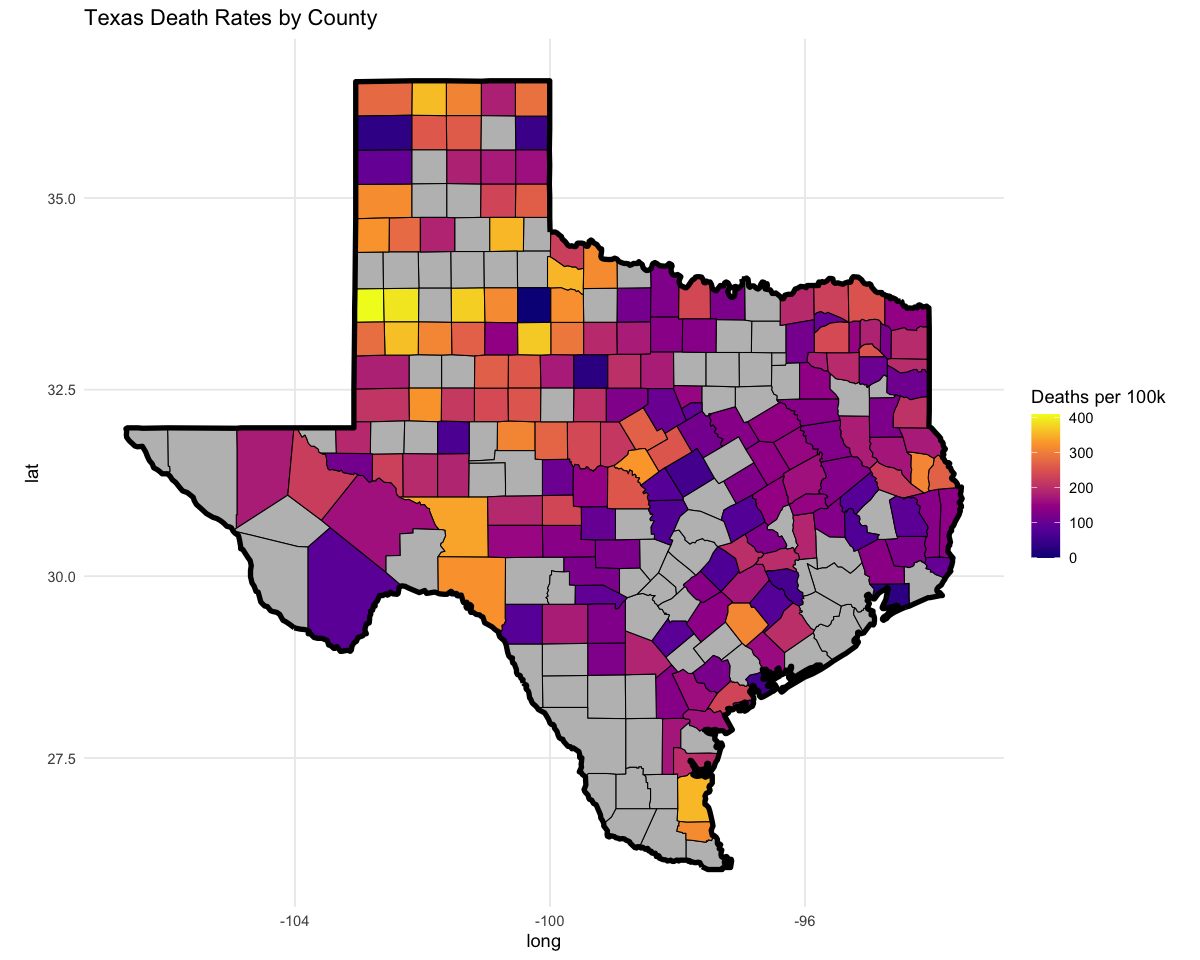

In [40]:
# Data cleaning: adjust county names in covid_census_tx_cleaned dataset
covid_census_tx_cleaned <- covid_census_tx_cleaned %>% 
  mutate(county = county %>% 
           str_to_lower() %>% 
           str_replace('\\s+county\\s*$', ''))

# Fill missing data in 'deaths_per_100k' with the median value
median_deaths <- median(covid_census_tx_cleaned$deaths_per_100k, na.rm = TRUE)
covid_census_tx_cleaned <- covid_census_tx_cleaned %>% 
  mutate(deaths_per_100k = ifelse(is.na(deaths_per_100k), median_deaths, deaths_per_100k))

# Load county polygon data
counties_polygon <- as_tibble(map_data("county"))
counties_polygon_TX <- counties_polygon %>% dplyr::filter(region == "texas") %>% 
  rename(c(county = subregion))

counties_polygon <- as_tibble(map_data("county")) %>%
  mutate(subregion = str_to_lower(subregion))  # Clean names
counties_polygon_TX <- counties_polygon %>%
  filter(region == "texas") %>%
  rename(county = subregion)

# Join the data with the counties polygon
counties_polygon_TX <- left_join(counties_polygon_TX, covid_census_tx_cleaned, by = "county")

# Load the map data for Texas border (state outline)
texas_border <- map_data("state") %>% 
  dplyr::filter(region == "texas")

# Set plot size
options(repr.plot.width = 10, repr.plot.height = 8)

# Plot the data
ggplot() + 
  # Plot the counties with death rates
  geom_polygon(data = counties_polygon_TX, 
               aes(long, lat, group = group, fill = deaths_per_100k), 
               color = "black", linewidth = 0.3) + 

  # Plot the Texas state outline
  geom_polygon(data = texas_border, 
               aes(long, lat, group = group), 
               fill = NA, color = "black", linewidth = 1.5) +  # Bold Texas border
  coord_map() +  # Alternative to coord_quickmap() for better projection
  scale_fill_viridis_c(option = "plasma", na.value = "gray") +  # Gray color for missing data
  labs(title = "Texas Death Rates by County", fill = "Deaths per 100k") +
  theme_minimal() +  # Use minimal theme for cleaner look
  theme(legend.position = "right")

In [42]:
# Select final clustering variables
clustering_df <- covid_census_tx_cleaned %>%
  select(
    cases_per_100k,
    deaths_per_100k,
    poverty,
    median_income,
    pct_on_food_stamps,
    commuters_by_public_transportation,
    pct_work_from_home,
    income_per_capita,
    gini_index,
    total_pop
  )

In [44]:
# Standardize the features
scaled_df <- scale(clustering_df) %>% as_tibble()

# Check summary statistics
summary(scaled_df)

 cases_per_100k    deaths_per_100k      poverty        median_income    
 Min.   :-2.1828   Min.   :-2.1981   Min.   :-1.0009   Min.   :-2.6869  
 1st Qu.:-0.7423   1st Qu.:-0.7212   1st Qu.:-0.7122   1st Qu.:-0.6900  
 Median :-0.1690   Median :-0.1176   Median :-0.3722   Median :-0.1274  
 Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.: 0.6775   3rd Qu.: 0.6631   3rd Qu.: 0.4257   3rd Qu.: 0.5044  
 Max.   : 2.4298   Max.   : 2.6210   Max.   : 3.6890   Max.   : 2.9608  
 pct_on_food_stamps commuters_by_public_transportation pct_work_from_home
 Min.   :-2.26370   Min.   :-0.6633                    Min.   :-2.12526  
 1st Qu.:-0.69478   1st Qu.:-0.6633                    1st Qu.:-0.66476  
 Median :-0.01291   Median :-0.5191                    Median :-0.02783  
 Mean   : 0.00000   Mean   : 0.0000                    Mean   : 0.00000  
 3rd Qu.: 0.62260   3rd Qu.: 0.3012                    3rd Qu.: 0.65907  
 Max.   : 2.83859   Max.   : 3.8798          

In [46]:
# Run K-means clustering
set.seed(123)
km <- kmeans(scaled_df, centers = 3, nstart = 10)
km

K-means clustering with 3 clusters of sizes 38, 85, 51

Cluster means:
  cases_per_100k deaths_per_100k    poverty median_income pct_on_food_stamps
1     0.02301267      -0.3739135  1.5040301    0.04696952          0.3546328
2     0.12809661       0.4143016 -0.3864884   -0.55387038          0.4473298
3    -0.23064105      -0.4119004 -0.4765026    0.88812040         -1.0097858
  commuters_by_public_transportation pct_work_from_home income_per_capita
1                          1.0797237          0.1085047       -0.03539197
2                         -0.3540751         -0.4010206       -0.50039786
3                         -0.2143749          0.5875211        0.86036692
  gini_index  total_pop
1  0.1861986  1.5341449
2  0.1159293 -0.4549249
3 -0.3319517 -0.3848802

Clustering vector:
  [1] 2 2 2 2 2 3 3 2 3 2 2 3 3 2 2 2 2 2 2 3 3 3 2 3 2 3 3 2 3 2 3 2 2 2 2 3 2
 [38] 3 2 3 3 2 2 3 2 3 2 2 2 2 2 2 3 2 2 2 3 2 3 3 3 2 3 3 1 2 1 2 3 1 2 2 2 2
 [75] 2 3 2 3 2 2 2 2 3 2 3 1 2 2 2 2 3 2 1 1 3 1

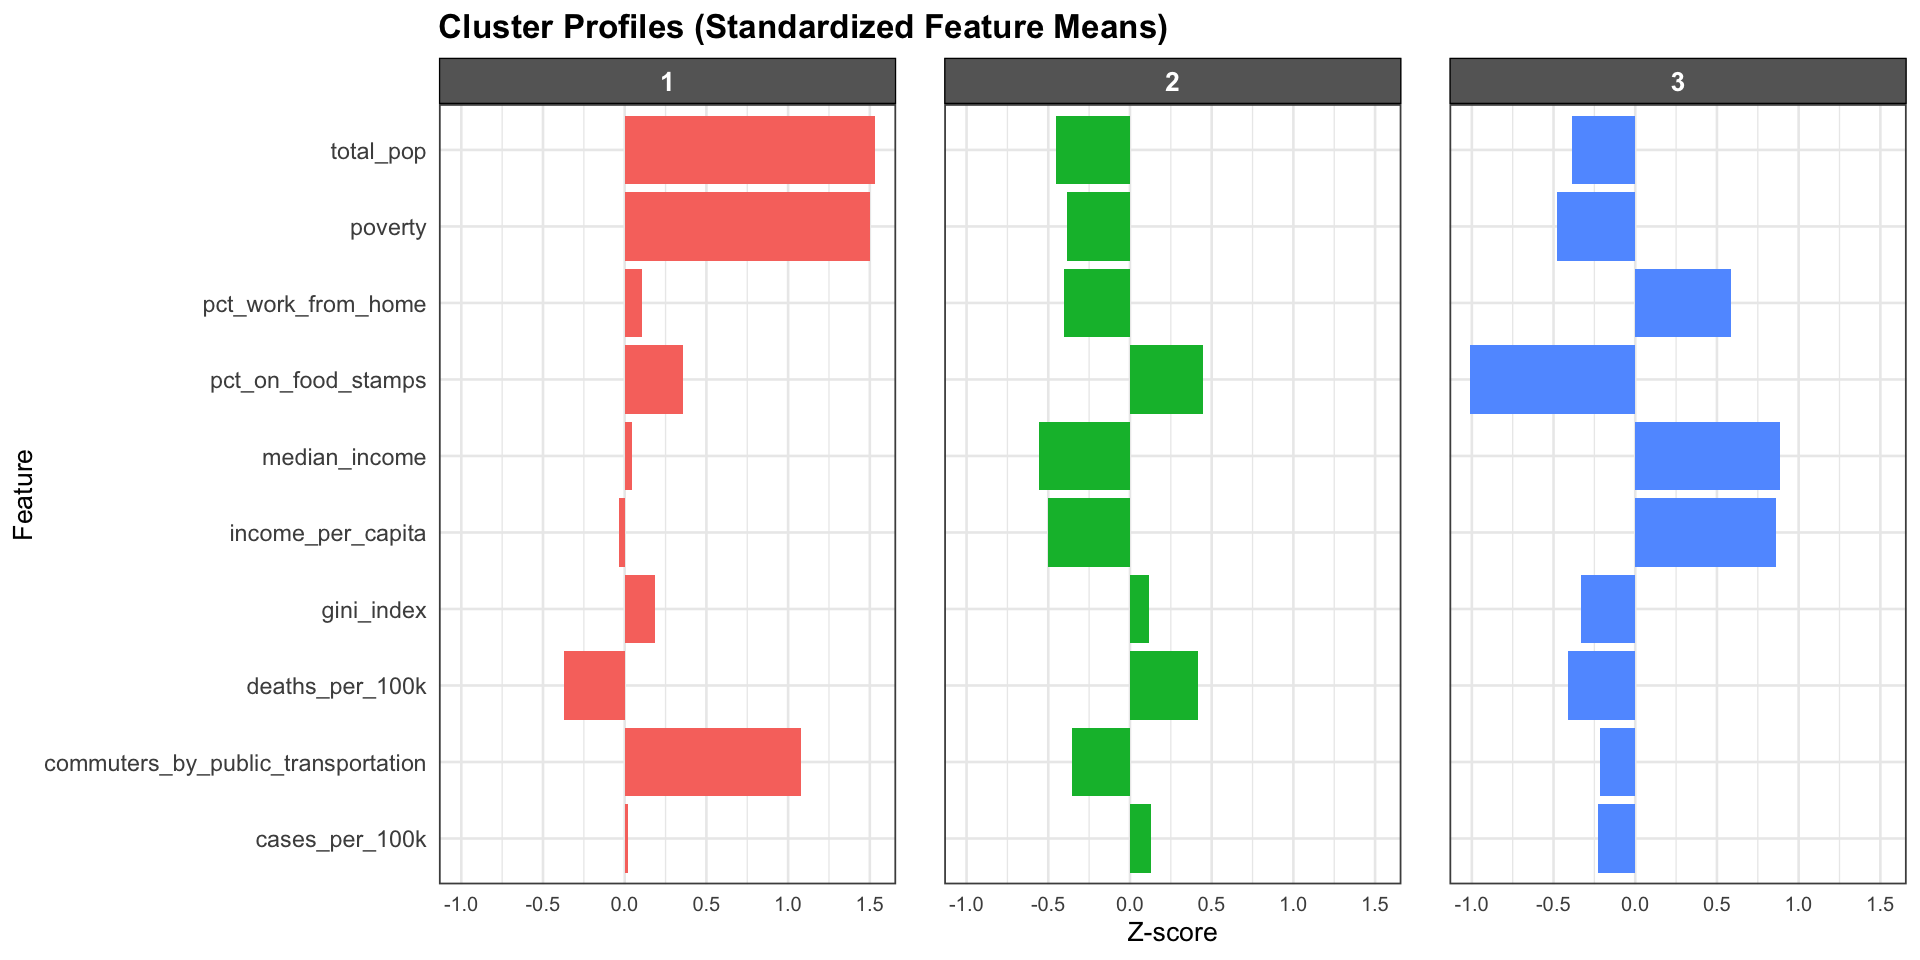

In [48]:
# Set plot size for Jupyter
options(repr.plot.width = 16, repr.plot.height = 8)

# Convert cluster to factor to get facet labels
km_centers_df <- as_tibble(km$centers, rownames = "cluster") %>%
  mutate(cluster = as.factor(cluster))

# Plot with facet box borders
ggplot(pivot_longer(km_centers_df, cols = -cluster, names_to = "name", values_to = "value"), 
       aes(y = name, x = value, fill = cluster)) +
  geom_bar(stat = "identity") +
  facet_grid(cols = vars(cluster)) +
  labs(
    y = "Feature", 
    x = "Z-score", 
    title = "Cluster Profiles (Standardized Feature Means)"
  ) +
  guides(fill = "none") +
 theme_minimal(base_size = 16) +
theme(
  plot.title = element_text(size = 20, face = "bold"),
  axis.text.y = element_text(size = 14),
  axis.text.x = element_text(size = 12),
  strip.text = element_text(size = 16, face = "bold", color = "white"),  # white text
  strip.background = element_rect(fill = "gray40", color = "black"),    # gray fill + black border
  panel.spacing = unit(2, "lines"),
  panel.border = element_rect(color = "gray30", fill = NA, linewidth = 1)  # updated from 'size'
)

In [50]:
# Compare average cases and deaths per 100k across clusters
covid_census_tx_clustered <- covid_census_tx_cleaned %>%
  mutate(county = toupper(county)) %>%
  add_column(cluster = factor(km$cluster))

covid_census_tx_clustered %>%
  group_by(cluster) %>%
  summarize(
    avg_cases_per_100k = mean(cases_per_100k),
    avg_deaths_per_100k = mean(deaths_per_100k)
  )

cluster avg_cases_per_100k avg_deaths_per_100k
1 1       7498.701           154.9234           
2 2       7745.846           221.8658           
3 3       6902.137           151.6972

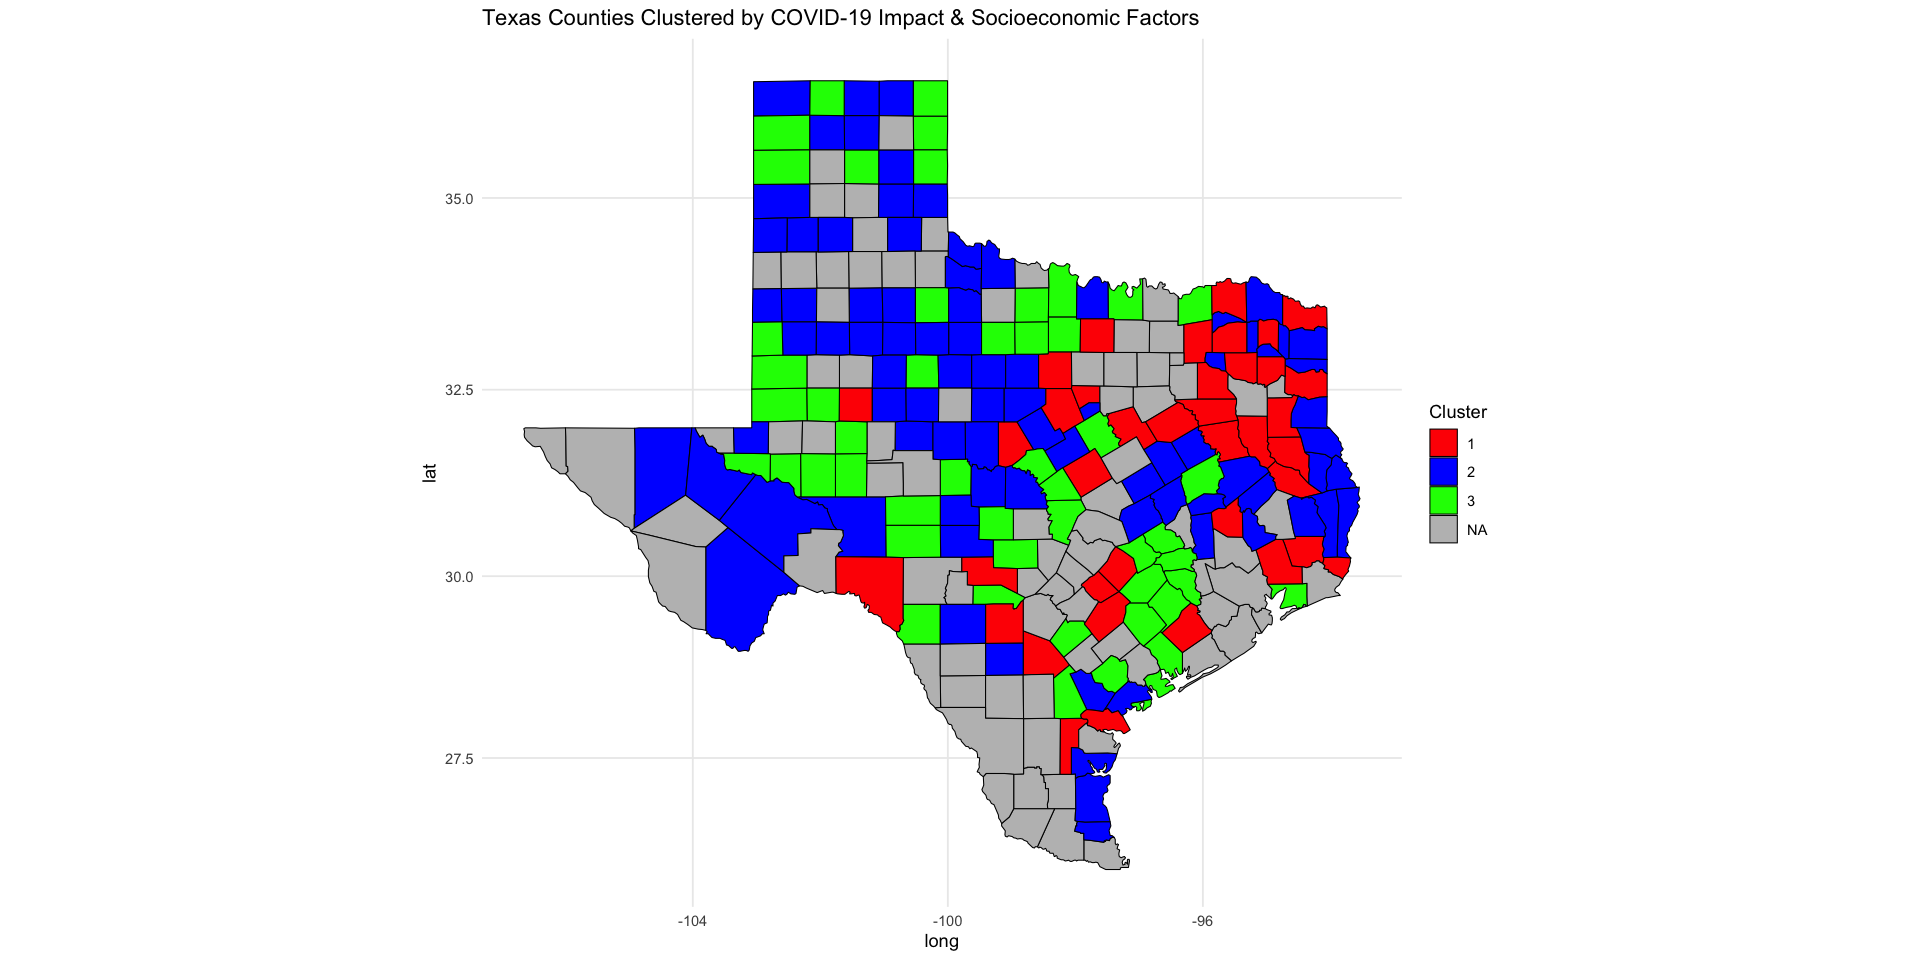

In [52]:
# Clean the COVID dataset county names
covid_census_tx_clustered <- covid_census_tx_clustered %>%
  mutate(county = str_to_lower(county) %>%
                  str_replace(" county", "") %>%
                  str_trim())

# Load county map and filter Texas only
counties_polygon <- map_data("county") %>%
  mutate(subregion = str_to_lower(subregion)) %>%
  filter(region == "texas") %>%
  rename(county = subregion)

# Join map and COVID cluster data
counties_polygon_tx <- left_join(counties_polygon, covid_census_tx_clustered, by = "county")

# Plot the map
ggplot() +
  geom_polygon(data = counties_polygon_tx,
               aes(long, lat, group = group, fill = factor(cluster)),
               color = "black", linewidth = 0.3) +
  scale_fill_manual(values = c("red", "blue", "green", "gray"), na.value = "gray") +
  labs(title = "Texas Counties Clustered by COVID-19 Impact & Socioeconomic Factors",
       fill = "Cluster") +
  theme_minimal() +
  coord_map()

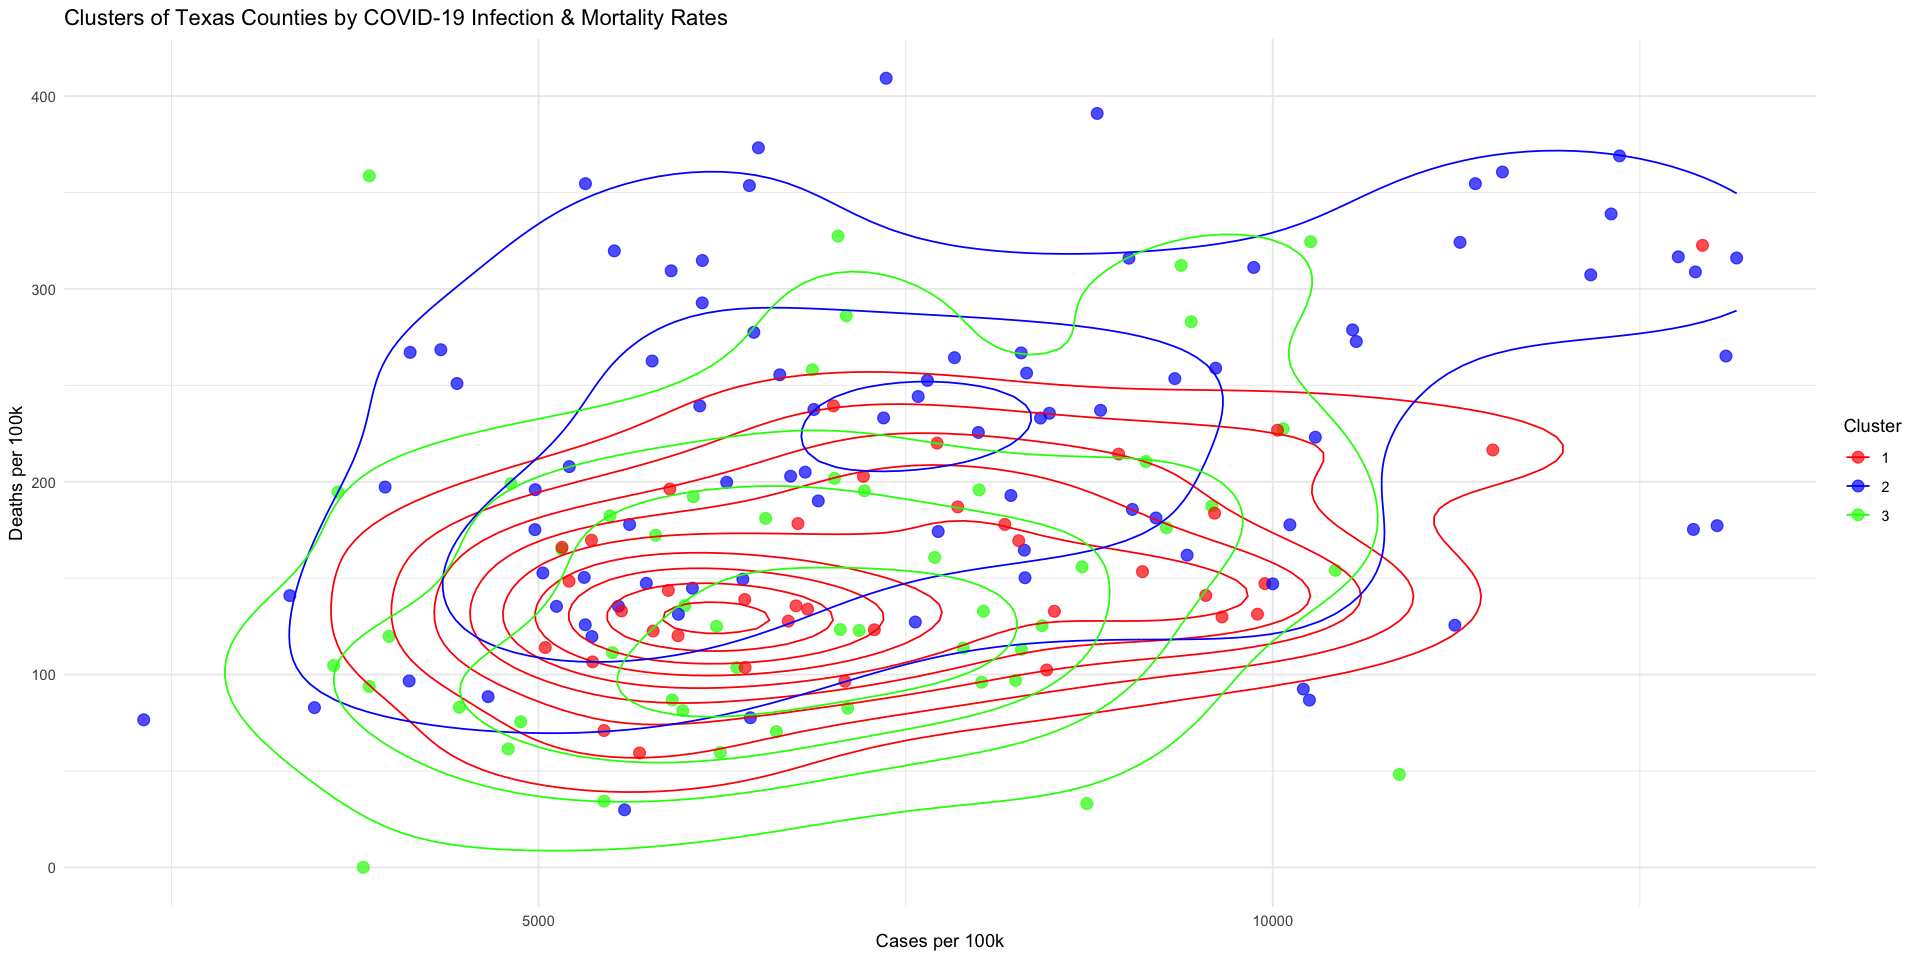

In [54]:
# Plot cluster of Texas Counties by COVID-19 Infection and Mortality
ggplot(covid_census_tx_clustered, aes(x = cases_per_100k, y = deaths_per_100k, color = factor(cluster))) +
  geom_point(size = 3, alpha = 0.7) +
  geom_density_2d() +
  scale_color_manual(values = c("red", "blue", "green")) + 
  theme_minimal() +
  labs(
    title = "Clusters of Texas Counties by COVID-19 Infection & Mortality Rates",
    x = "Cases per 100k",
    y = "Deaths per 100k",
    color = "Cluster"
  )

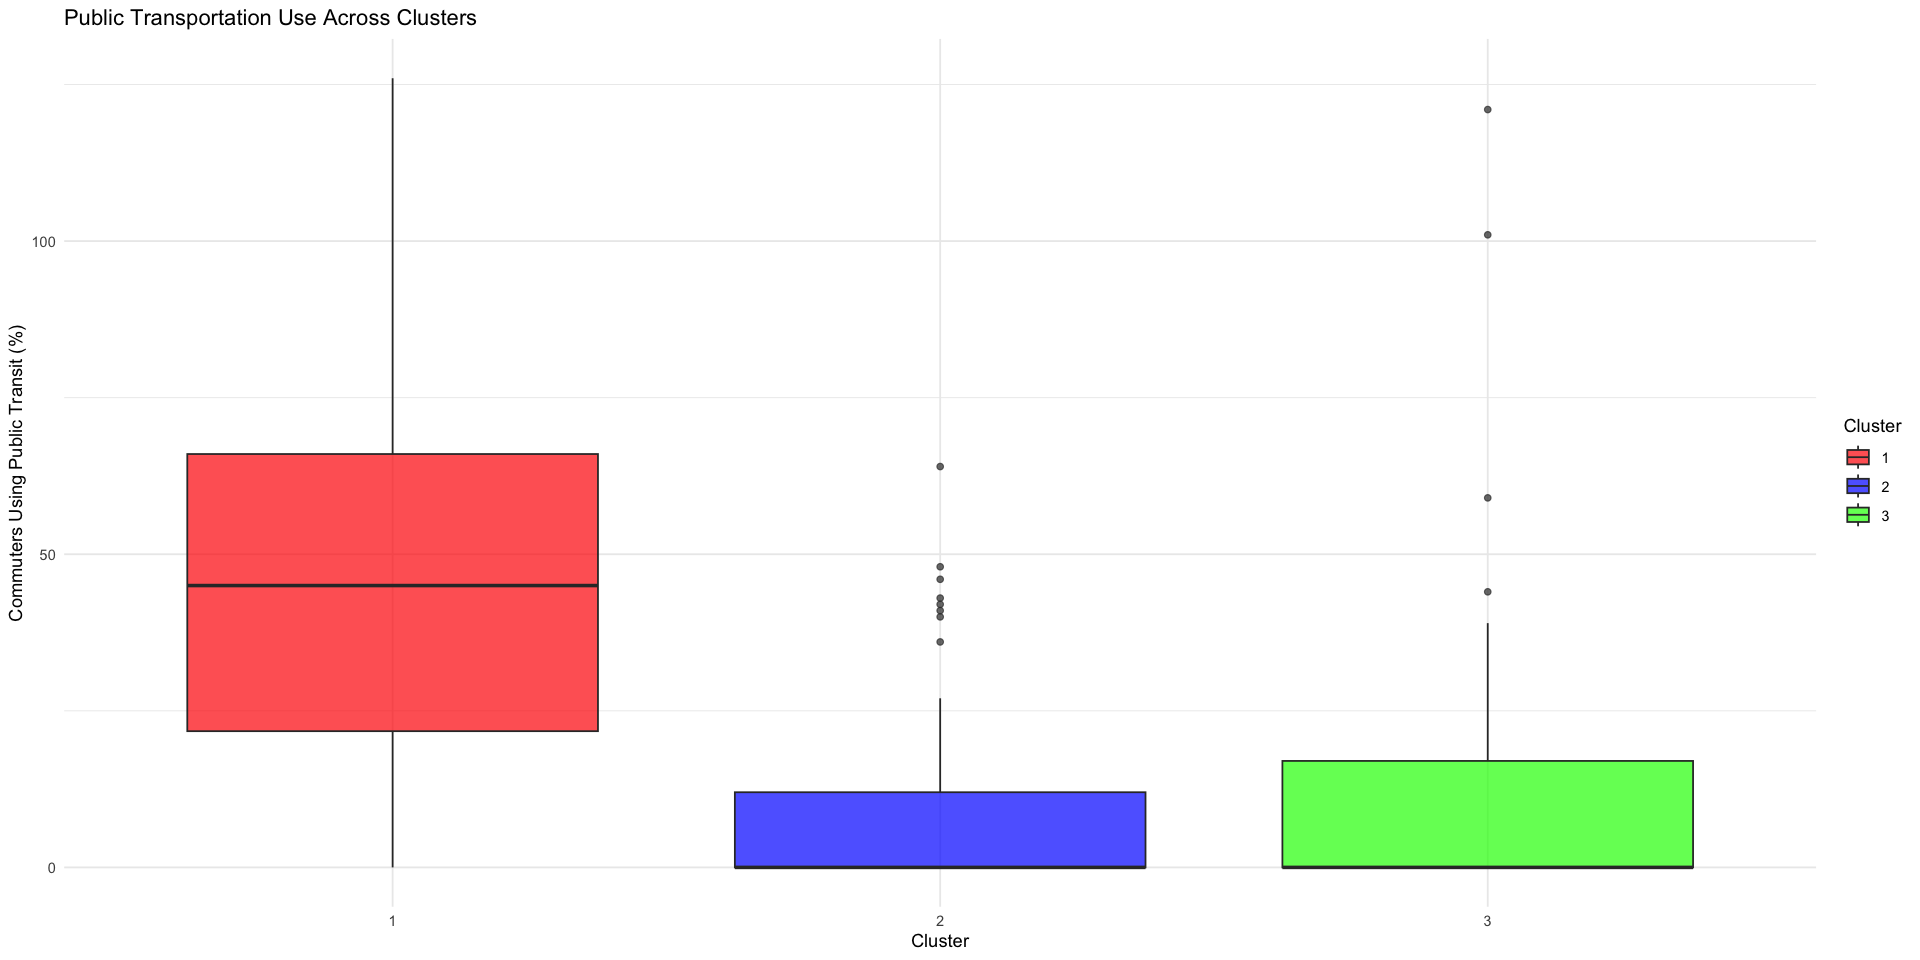

In [56]:
# Box plot: Public Transportation Use Across Clusters
ggplot(covid_census_tx_clustered, aes(x = factor(cluster), y = commuters_by_public_transportation, fill = factor(cluster))) +
  geom_boxplot(alpha = 0.7) +
  scale_fill_manual(values = c("red", "blue", "green")) +
  theme_minimal() +
  labs(
    title = "Public Transportation Use Across Clusters",
    x = "Cluster",
    y = "Commuters Using Public Transit (%)",
    fill = "Cluster"
  )

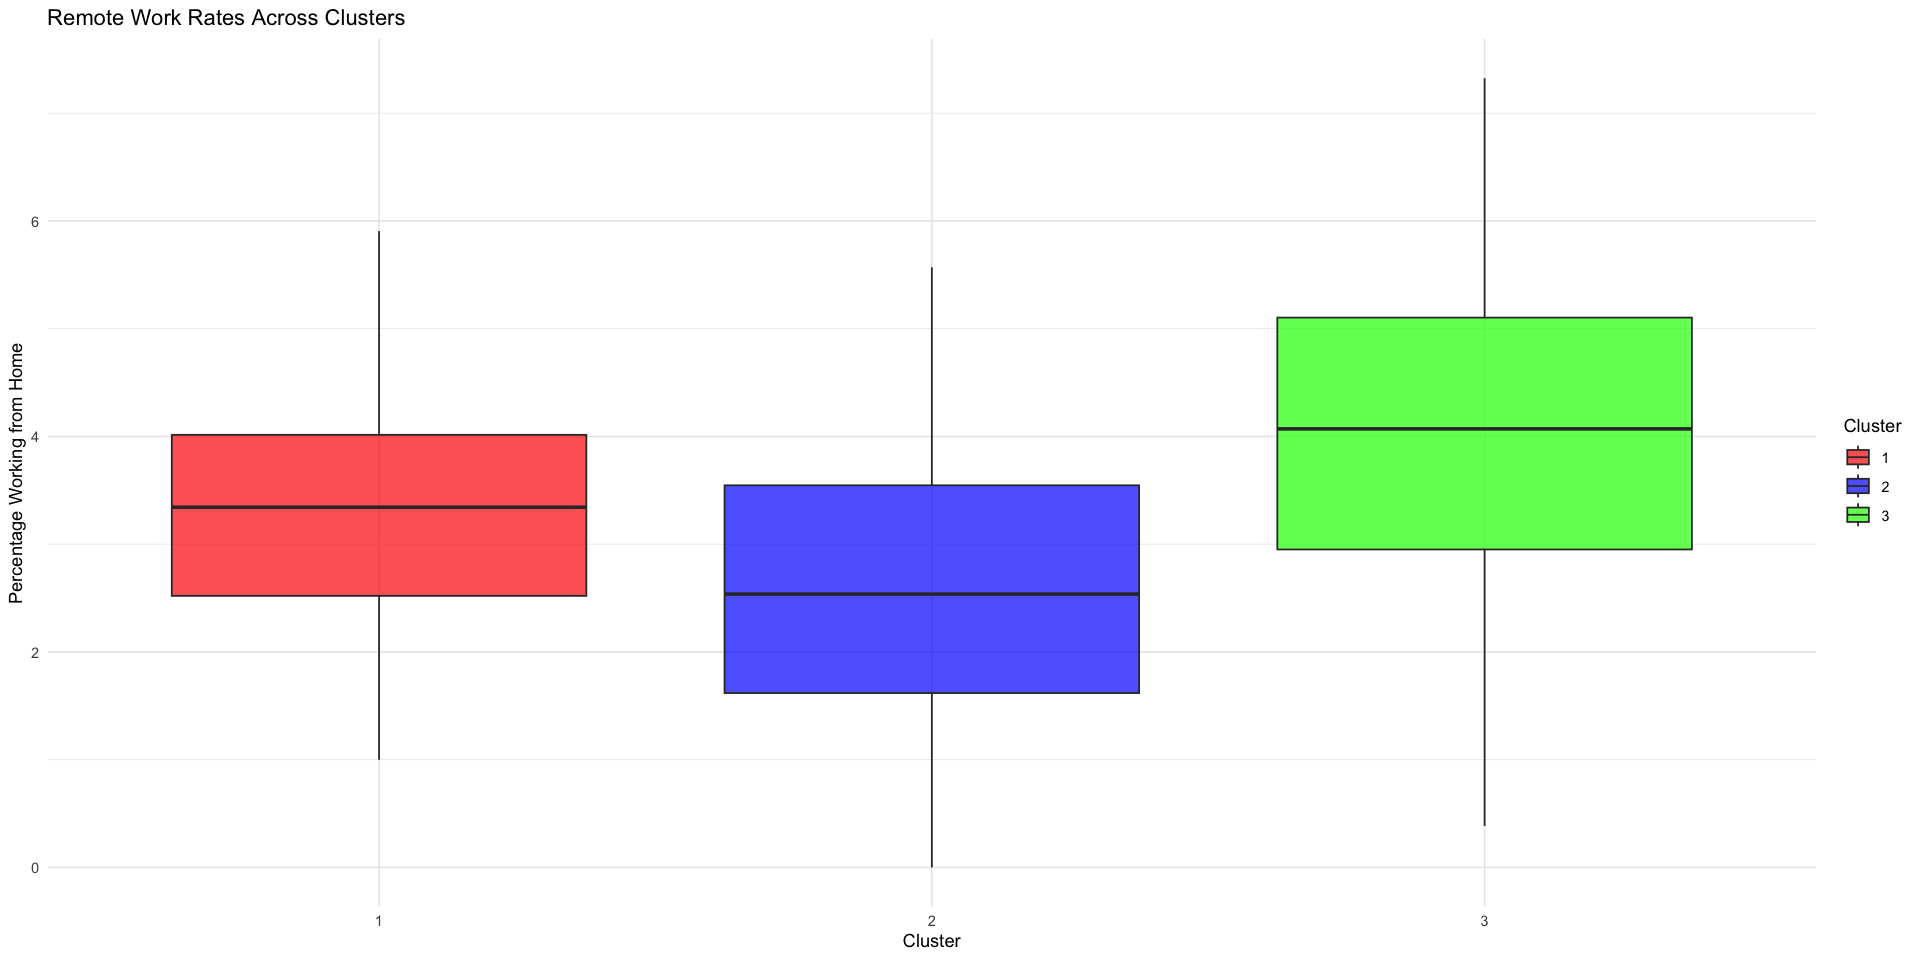

In [58]:
# Box plot: Remote work rates across clusters
ggplot(covid_census_tx_clustered, aes(x = factor(cluster), y = pct_work_from_home, fill = factor(cluster))) +
  geom_boxplot(alpha = 0.7) +
  scale_fill_manual(values = c("red", "blue", "green")) +
  theme_minimal() +
  labs(
    title = "Remote Work Rates Across Clusters",
    x = "Cluster",
    y = "Percentage Working from Home",
    fill = "Cluster"
  )

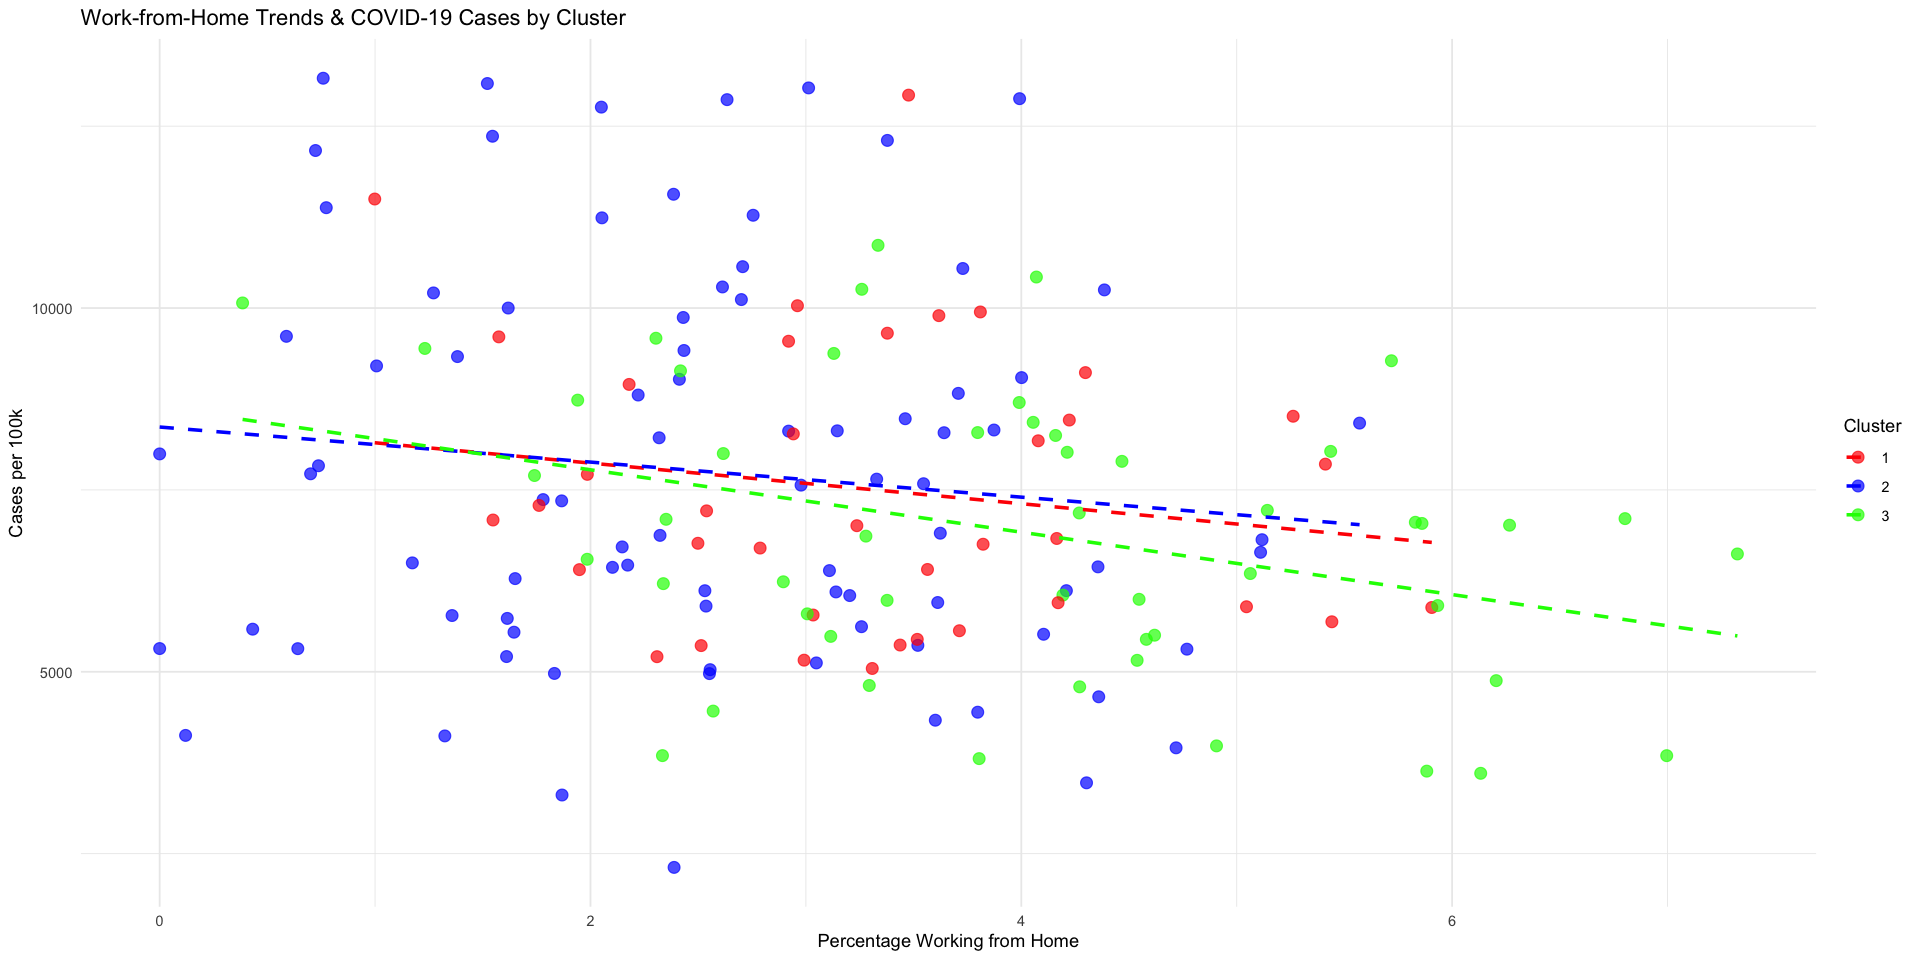

In [60]:
# Scatter plot: WFH Trends & COVID-19 Cases by Cluster
ggplot(covid_census_tx_clustered, aes(x = pct_work_from_home, y = cases_per_100k, color = factor(cluster))) +
  geom_point(size = 3, alpha = 0.7) +
  geom_smooth(method = "lm", formula = y ~ x, se = FALSE, linetype = "dashed") +
  scale_color_manual(values = c("red", "blue", "green")) +
  theme_minimal() +
  labs(
    title = "Work-from-Home Trends & COVID-19 Cases by Cluster",
    x = "Percentage Working from Home",
    y = "Cases per 100k",
    color = "Cluster"
   )

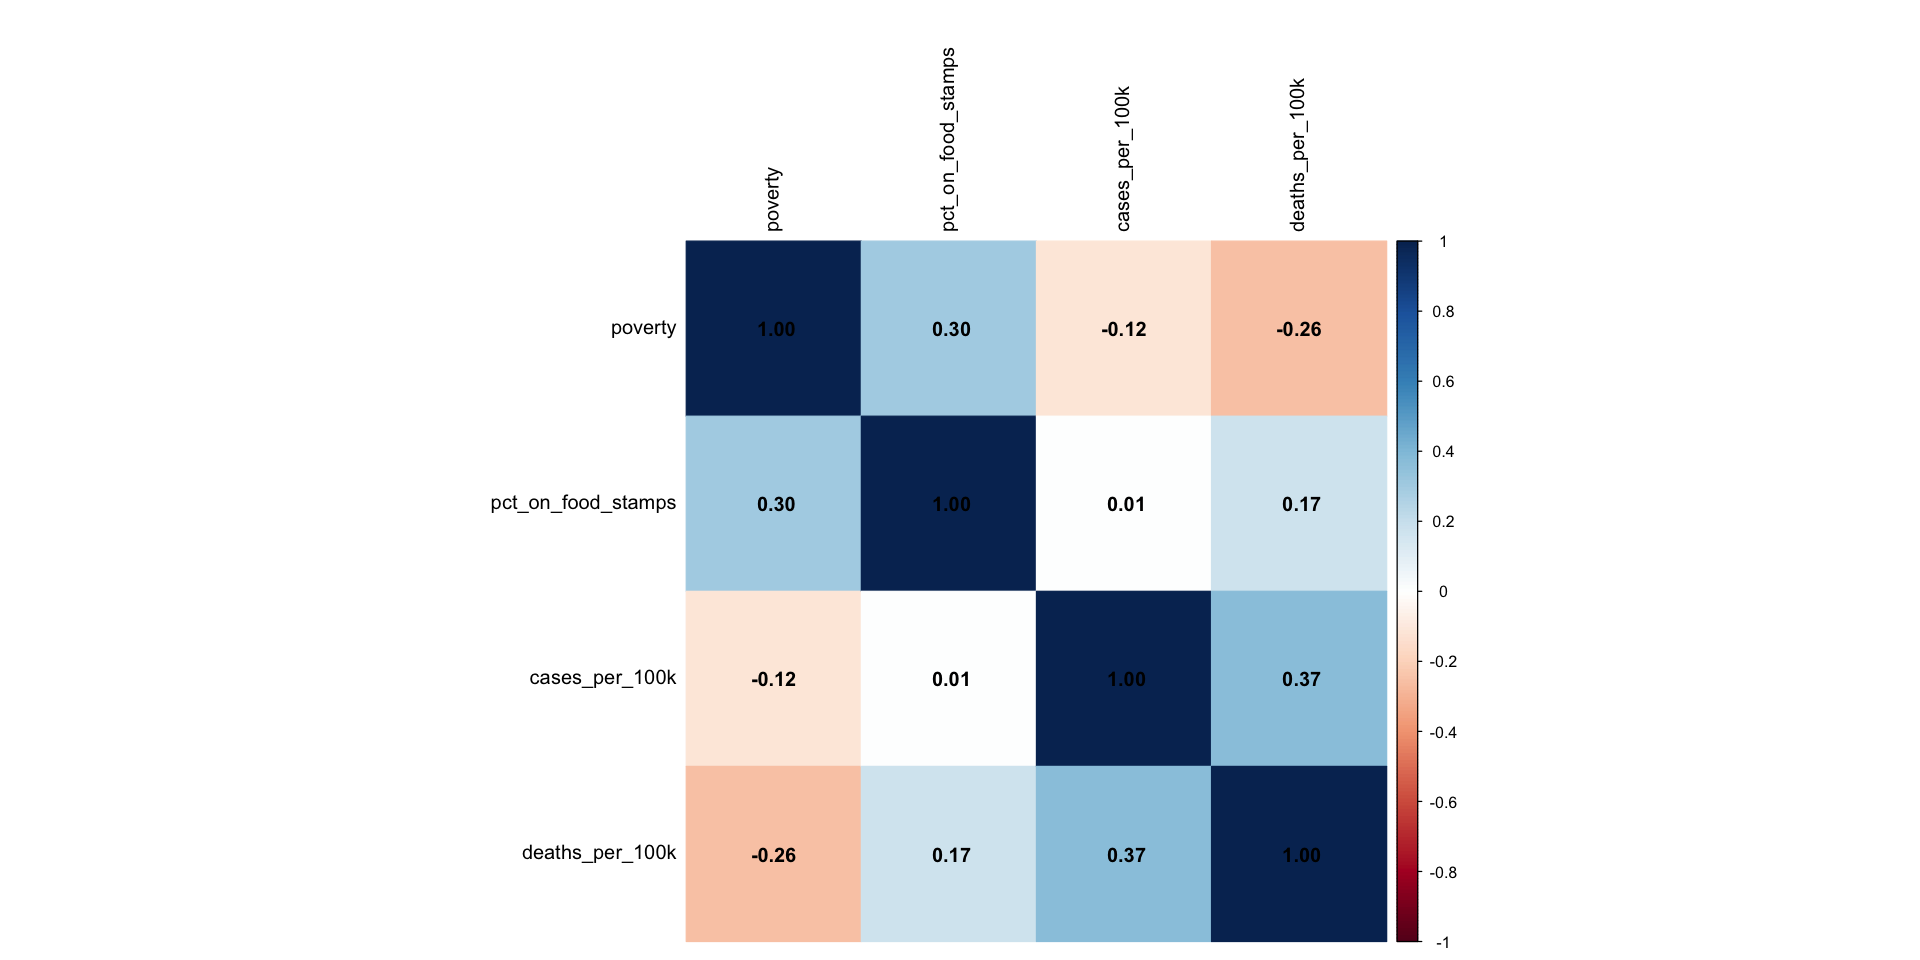

In [62]:
# Correlation: pverty, Public Assistance & COVID-19
cor_matrix <- covid_census_tx_clustered %>%
  select(poverty, pct_on_food_stamps, cases_per_100k, deaths_per_100k) %>%
  cor(use = "complete.obs")

corrplot(cor_matrix, method = "color", tl.col = "black", addCoef.col = "black")

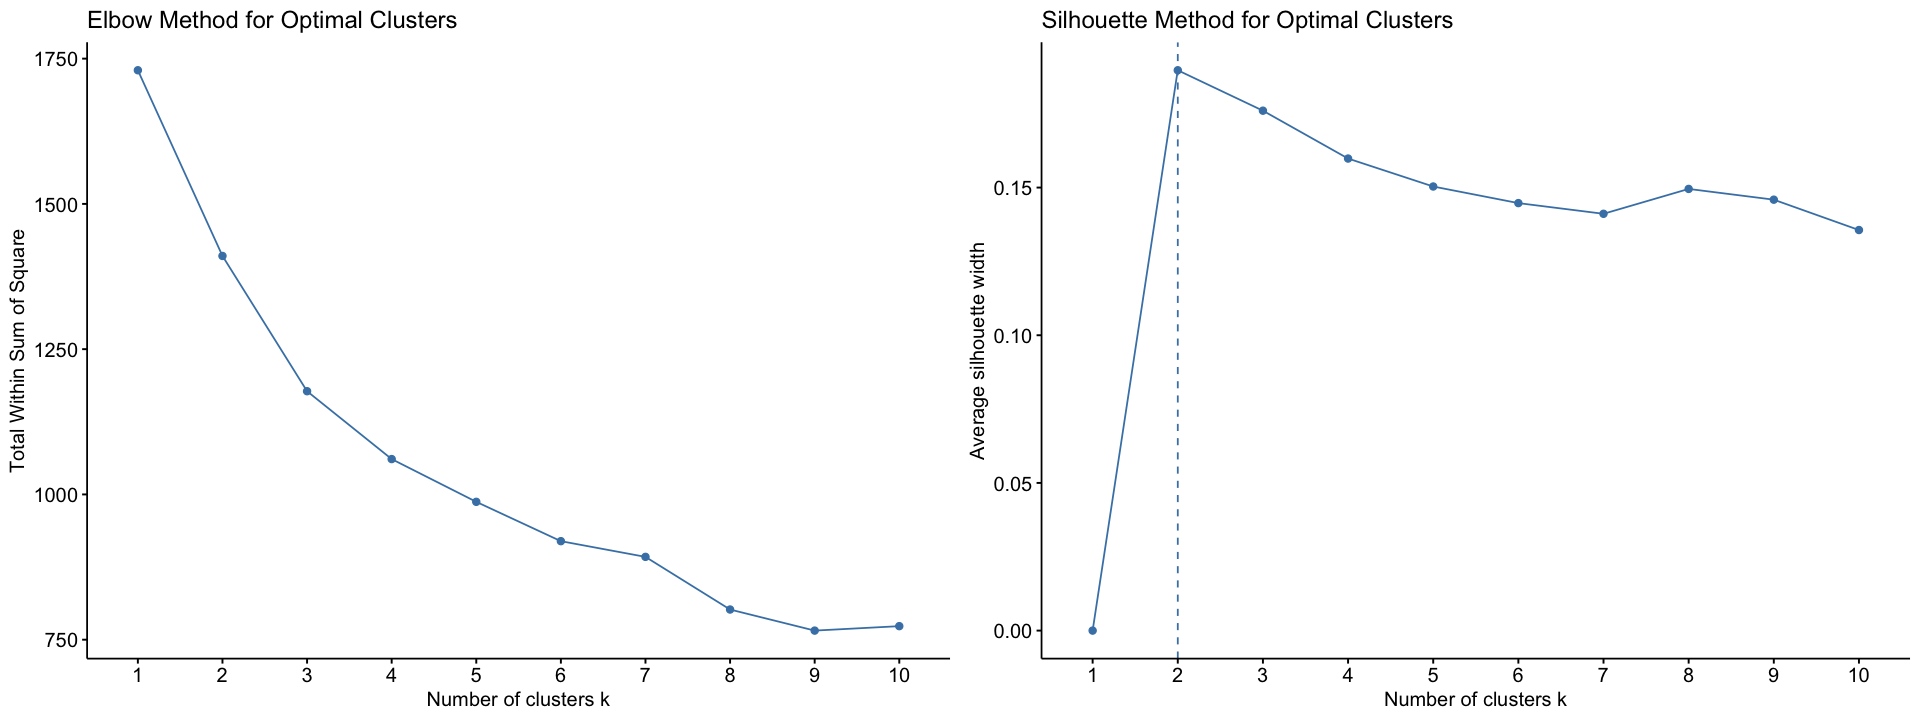

In [64]:
# Expand plot area (useful in Jupyter)
options(repr.plot.width = 16, repr.plot.height = 6)

# Create elbow and silhouette plots
elbow_plot <- fviz_nbclust(scaled_df, kmeans, method = "wss") +
  labs(title = "Elbow Method for Optimal Clusters")

silhouette_plot <- fviz_nbclust(scaled_df, kmeans, method = "silhouette") +
  labs(title = "Silhouette Method for Optimal Clusters")

# Arrange side-by-side
grid.arrange(elbow_plot, silhouette_plot, ncol = 2)

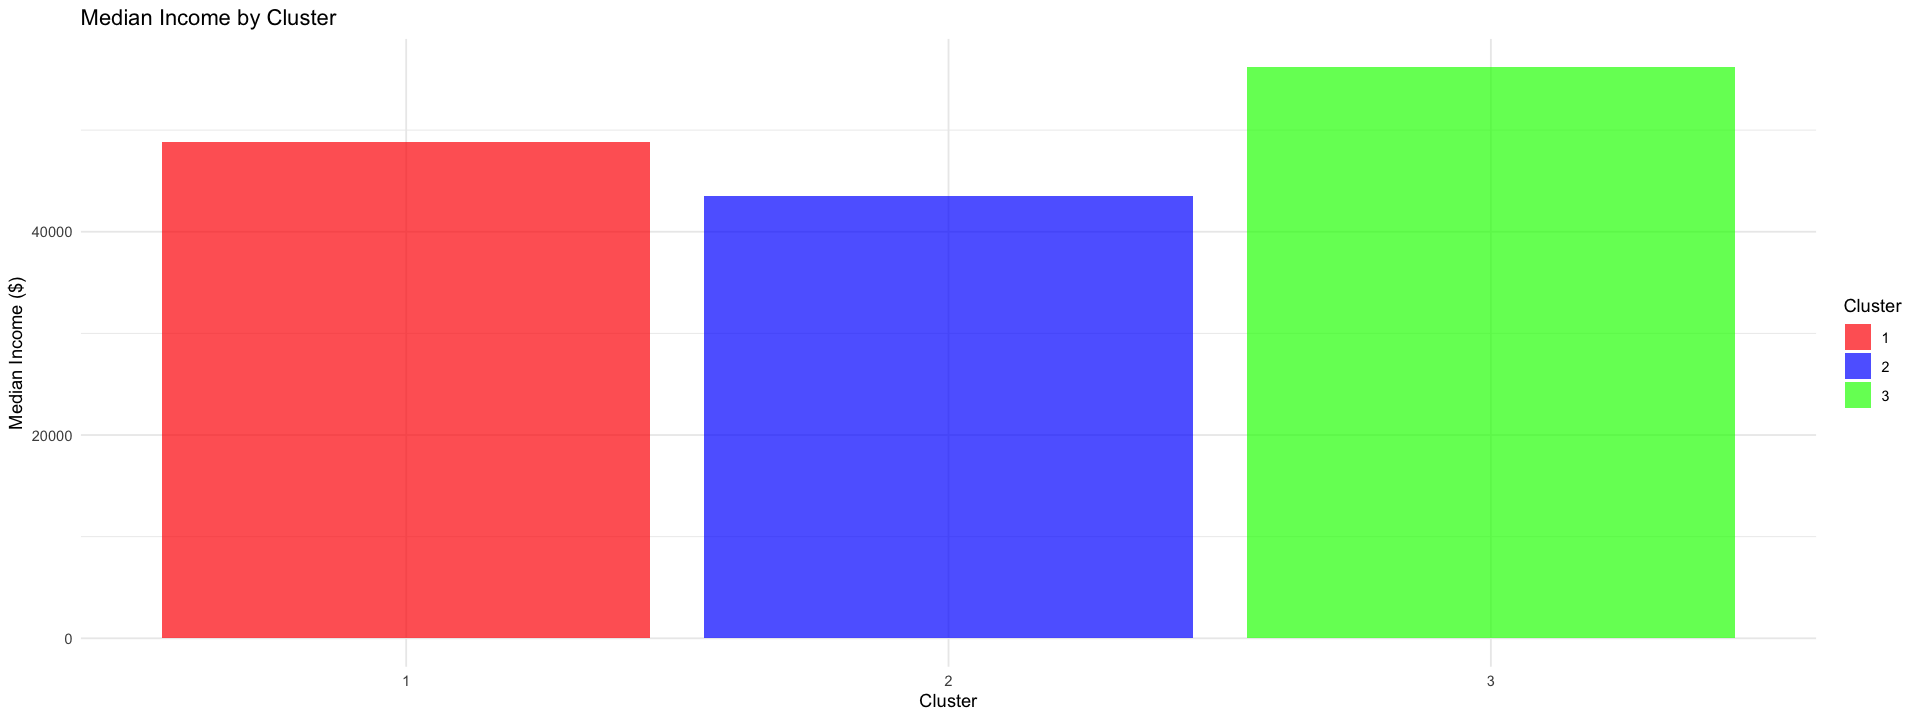

In [66]:
# Bar chart: median income by cluster
ggplot(covid_census_tx_clustered, aes(x = factor(cluster), y = median_income, fill = factor(cluster))) +
  geom_bar(stat = "summary", fun = "mean", alpha = 0.7) +
  scale_fill_manual(values = c("red", "blue", "green")) +
  theme_minimal() +
  labs(
    title = "Median Income by Cluster",
    x = "Cluster",
    y = "Median Income ($)",
    fill = "Cluster"
  )

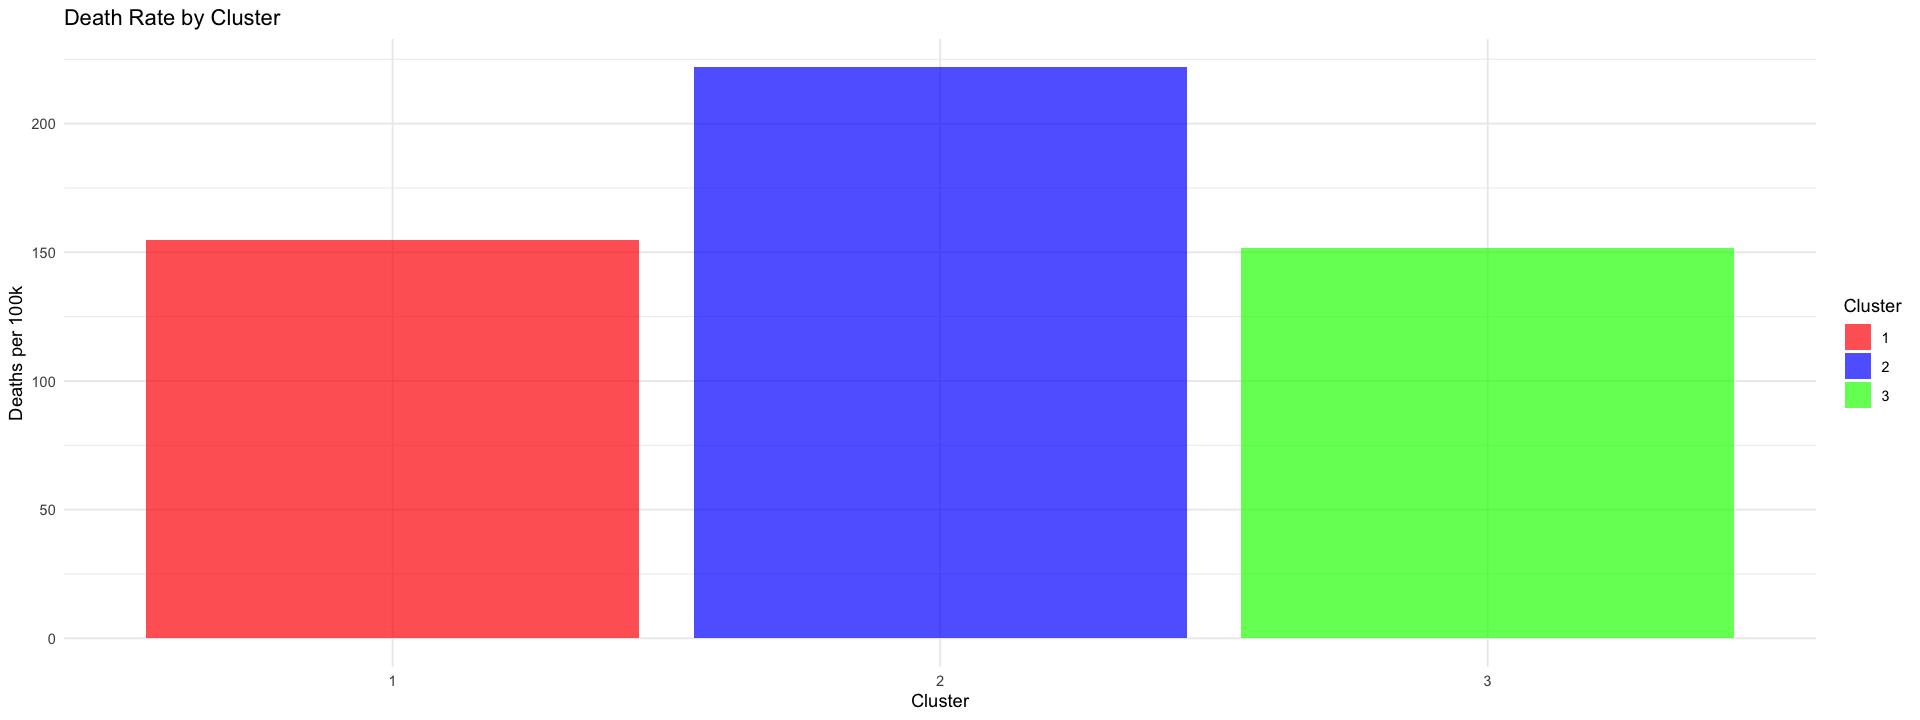

In [68]:
# Bar plot: death rate by cluster
ggplot(covid_census_tx_clustered, aes(x = factor(cluster), y = deaths_per_100k, fill = factor(cluster))) +
  geom_bar(stat = "summary", fun = "mean", alpha = 0.7) +
  scale_fill_manual(values = c("red", "blue", "green")) +
  theme_minimal() +
  labs(
    title = "Death Rate by Cluster",
    x = "Cluster",
    y = "Deaths per 100k",
    fill = "Cluster"
  )

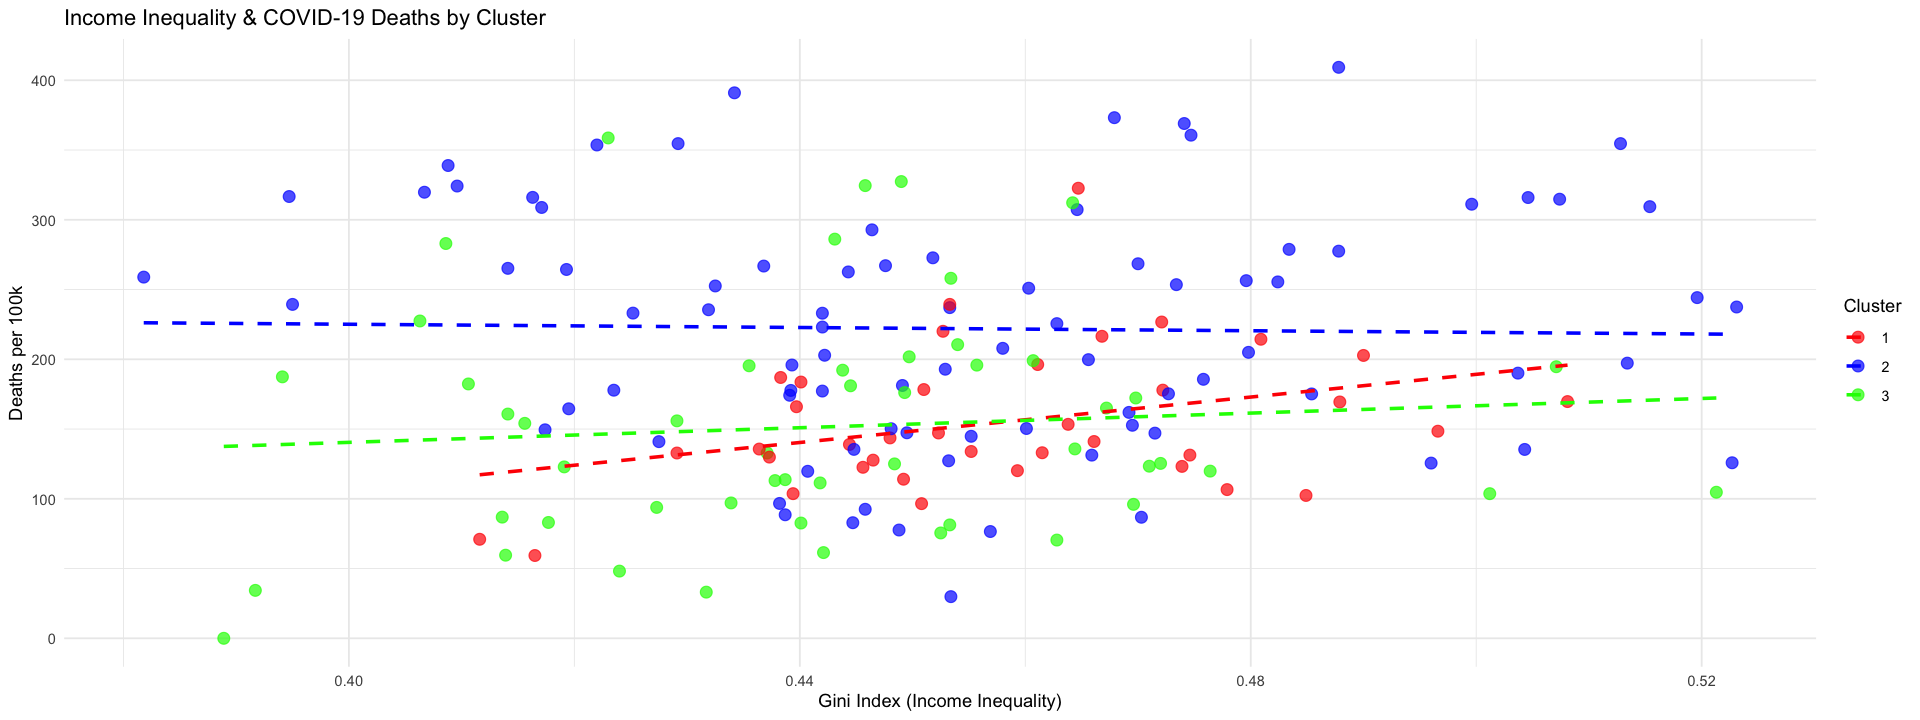

In [70]:
# scatter plot: income inequality & covid-19 
ggplot(covid_census_tx_clustered, aes(x = gini_index, y = deaths_per_100k, color = factor(cluster))) +
  geom_point(size = 3, alpha = 0.7) +
  geom_smooth(method = "lm", formula = y~x, se = FALSE, linetype = "dashed") +
  scale_color_manual(values = c("red", "blue", "green")) +
  theme_minimal() +
  labs(
    title = "Income Inequality & COVID-19 Deaths by Cluster",
    x = "Gini Index (Income Inequality)",
    y = "Deaths per 100k",
    color = "Cluster"
  )

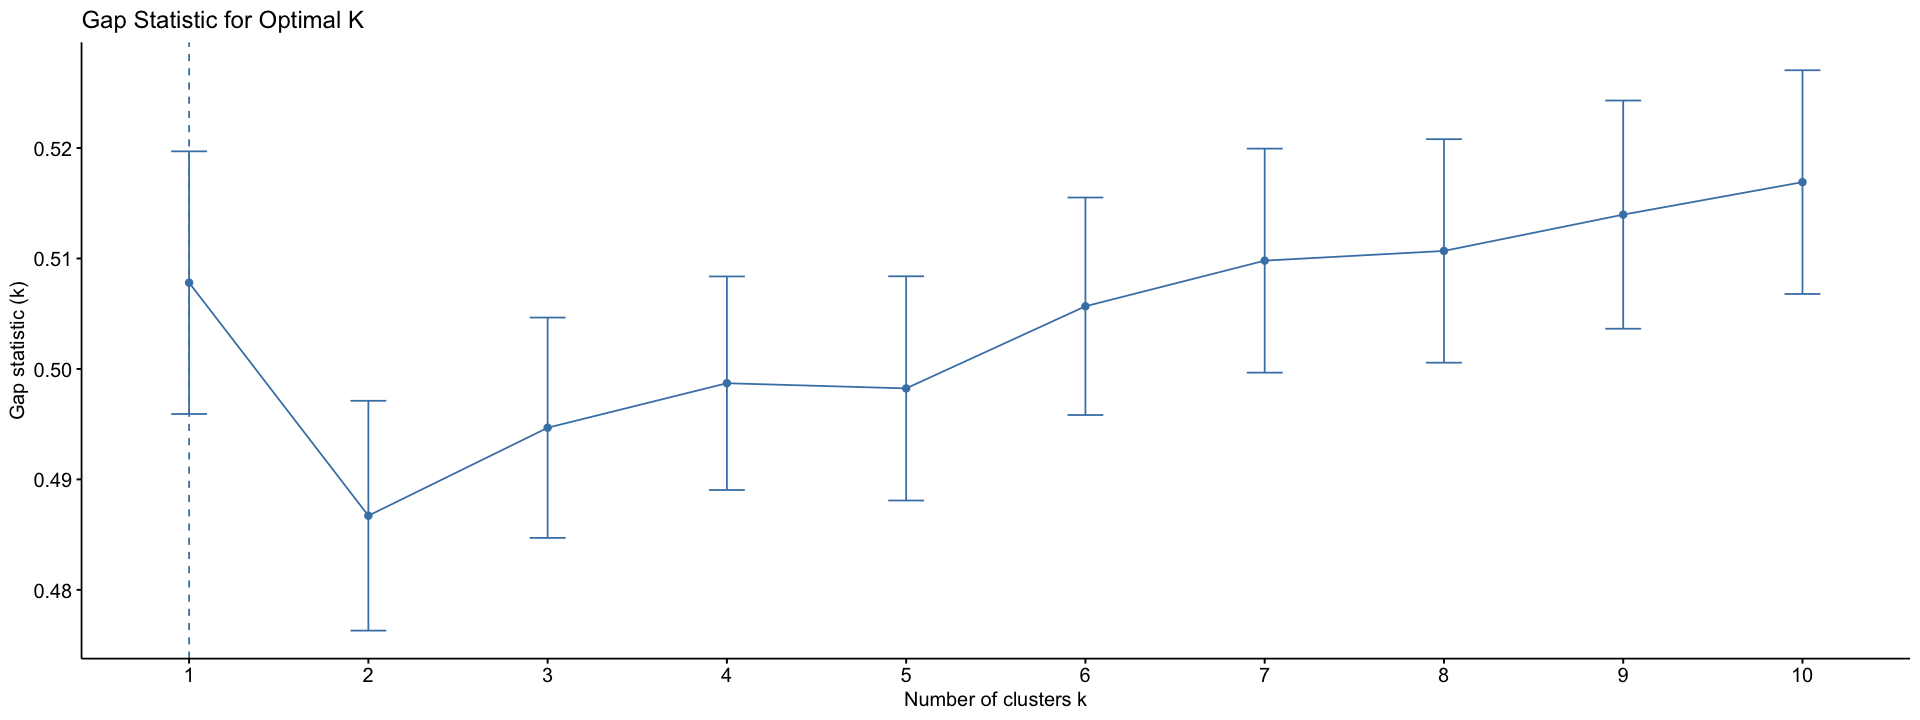

In [72]:
# Gap statistic to determine the optimal number of clusters
set.seed(123)

gap_stat <- clusGap(scaled_df, FUN = kmeans, nstart = 25, K.max = 10, B = 50)

# Visualize the gap statistic
fviz_gap_stat(gap_stat) +
  labs(title = "Gap Statistic for Optimal K")

In [74]:
# K-means with k = 3
set.seed(42)
kmeans_3 <- kmeans(scaled_df, centers = 3, nstart = 25)

# K-means with k = 4
set.seed(42)
kmeans_4 <- kmeans(scaled_df, centers = 4, nstart = 25)

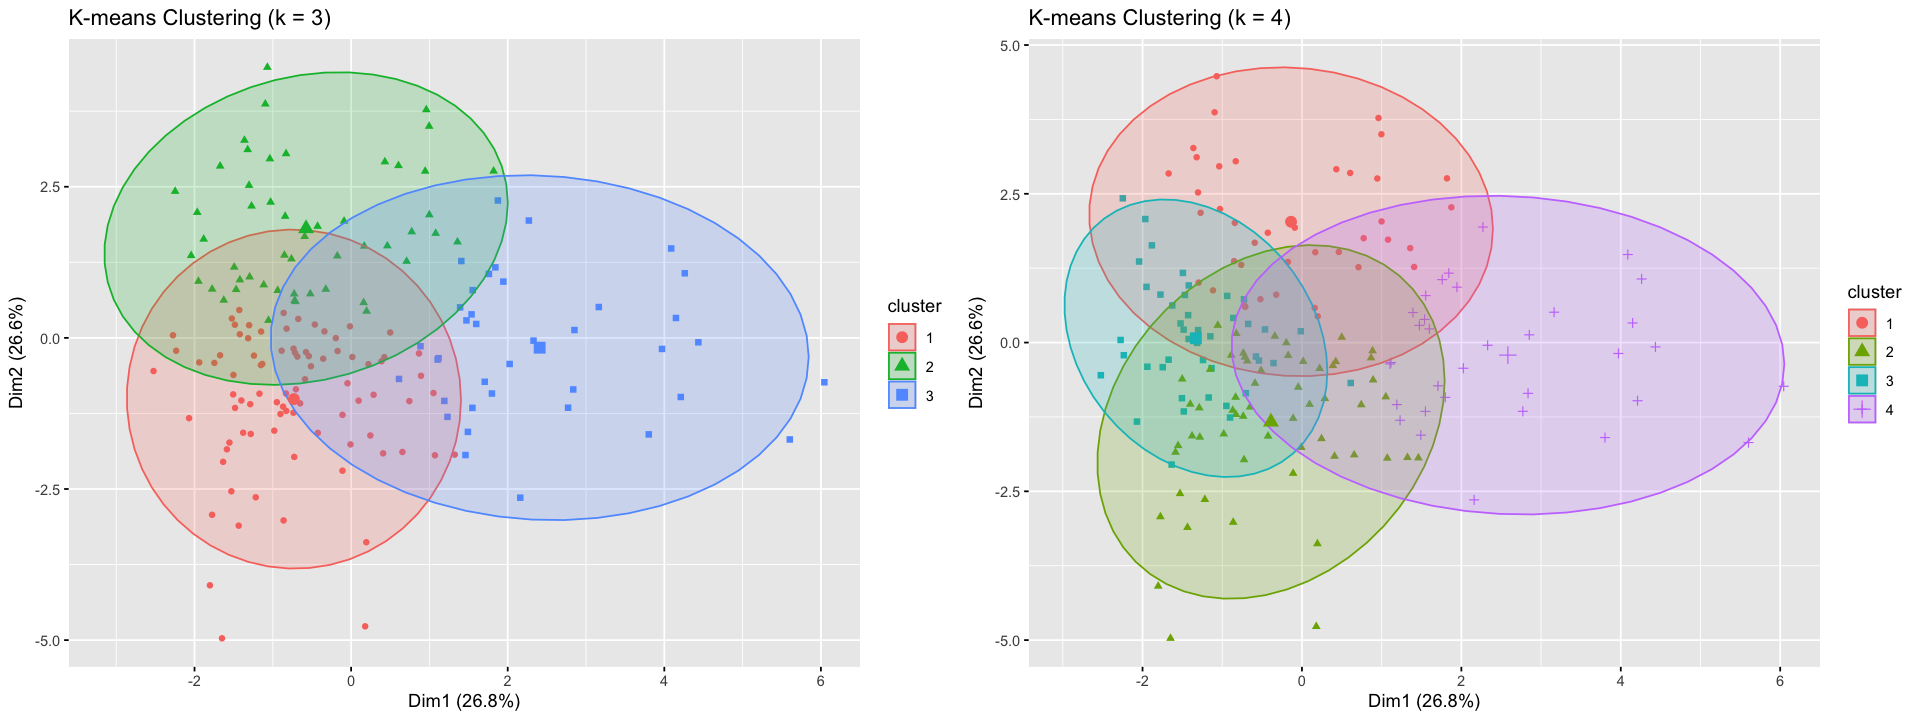

In [76]:
# Make output area wider 
options(repr.plot.width = 16, repr.plot.height = 6)

# --- K-means cluster plots ---
km3_plot <- fviz_cluster(kmeans_3, data = scaled_df, geom = "point", ellipse.type = "norm") +
  labs(title = "K-means Clustering (k = 3)")

km4_plot <- fviz_cluster(kmeans_4, data = scaled_df, geom = "point", ellipse.type = "norm") +
  labs(title = "K-means Clustering (k = 4)")

# --- Display side-by-side ---
# First row: K-means clusters
grid.arrange(km3_plot, km4_plot, ncol = 2)

In [78]:
# Top 5 counties by population in each cluster
top_counties <- covid_census_tx_clustered %>%
  group_by(cluster) %>%
  slice_max(order_by = total_pop, n = 5) %>%
  select(cluster, county, total_pop, cases_per_100k, poverty)

kable(top_counties, caption = "Top 5 Most Populous Counties per Cluster")



Table: Top 5 Most Populous Counties per Cluster

|cluster |county      | total_pop| cases_per_100k| poverty|
|:-------|:-----------|---------:|--------------:|-------:|
|1       |bowie       |     93635|       5207.454|   15750|
|1       |hunt        |     90322|       5045.282|   16430|
|1       |angelina    |     87700|       7713.797|   16222|
|1       |orange      |     83909|       7086.248|   11759|
|1       |bastrop     |     80306|       5445.421|   10322|
|2       |jasper      |     35444|       5543.957|    5772|
|2       |bee         |     32729|       9416.725|    4926|
|2       |kleberg     |     31540|       6280.913|    7003|
|2       |cass        |     30118|       4977.090|    5471|
|2       |san jacinto |     27436|       2310.832|    4679|
|3       |wilson      |     47205|       5910.391|    4705|
|3       |burnet      |     45017|       4878.157|    5473|
|3       |chambers    |     39283|       8734.058|    5031|
|3       |cooke       |     39064|       7183.084

In [80]:
# Hierarchical clustering - Ward
hc_ward <- hclust(dist(scaled_df), method = "ward.D2")

# Hierarchical clustering - Complete Linkage
hc_complete <- hclust(dist(scaled_df), method = "complete")

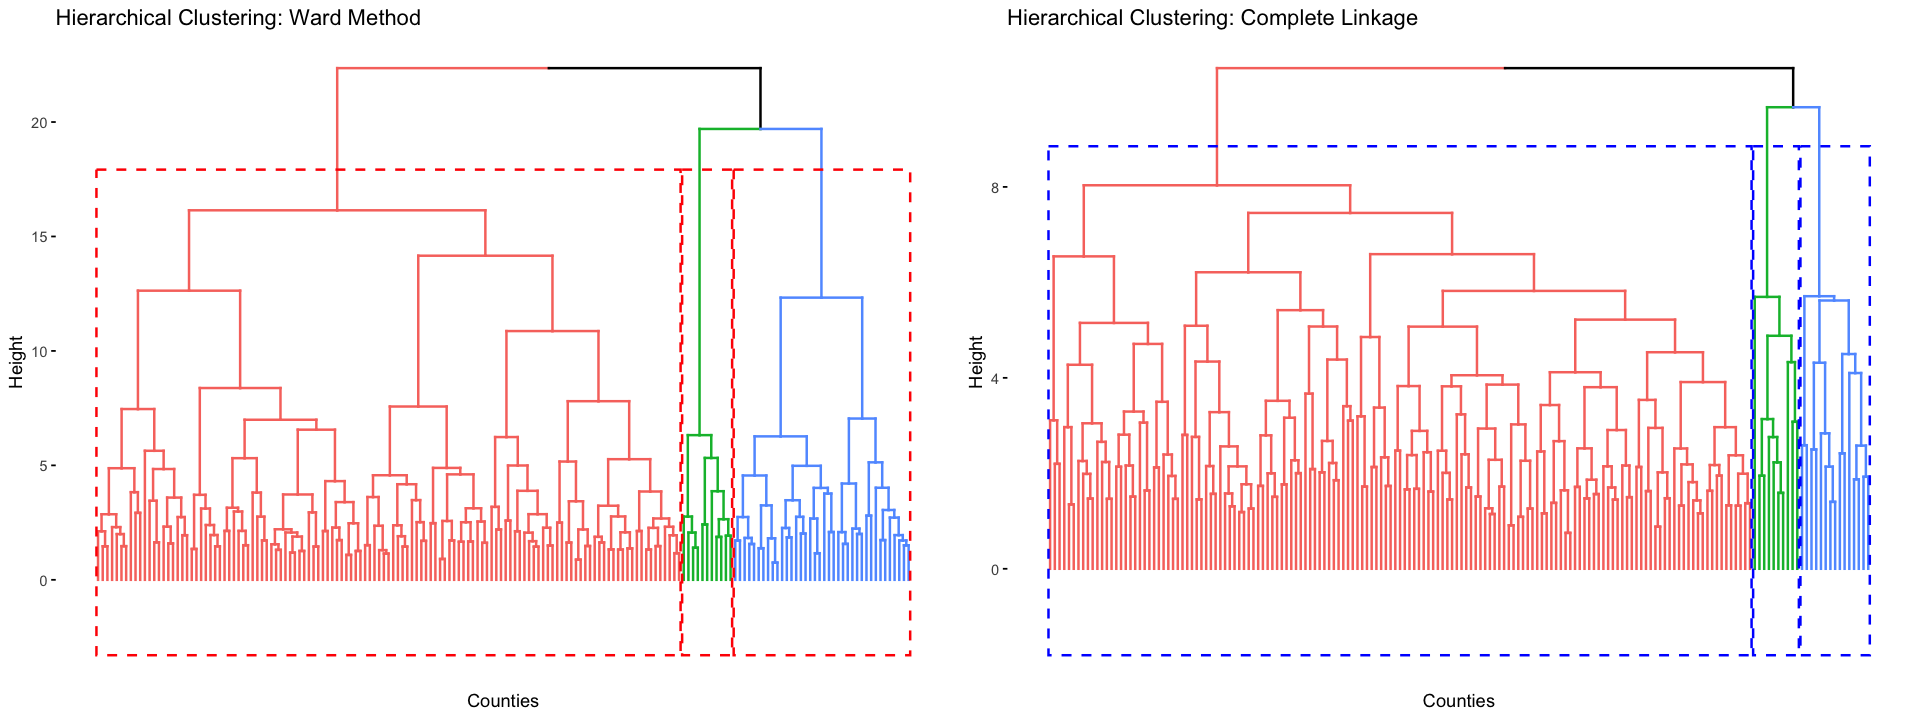

In [82]:
# Hierarchical dendrograms
dist_matrix <- dist(scaled_df)

suppressWarnings({
  dend_ward <- fviz_dend(
    hclust(dist_matrix, method = "ward.D2"),
    k = 3, show_labels = FALSE,
    main = "Hierarchical Clustering: Ward Method",
    rect = TRUE, rect_border = "red", cex = 0.8
  ) +
  labs(x = "Counties", y = "Height") +
  guides(color = "none", fill = "none")

  dend_complete <- fviz_dend(
    hclust(dist_matrix, method = "complete"),
    k = 3, show_labels = FALSE,
    main = "Hierarchical Clustering: Complete Linkage",
    rect = TRUE, rect_border = "blue", cex = 0.8
  ) +
  labs(x = "Counties", y = "Height") +
  guides(color = "none", fill = "none")

  grid.arrange(dend_ward, dend_complete, ncol = 2)
})

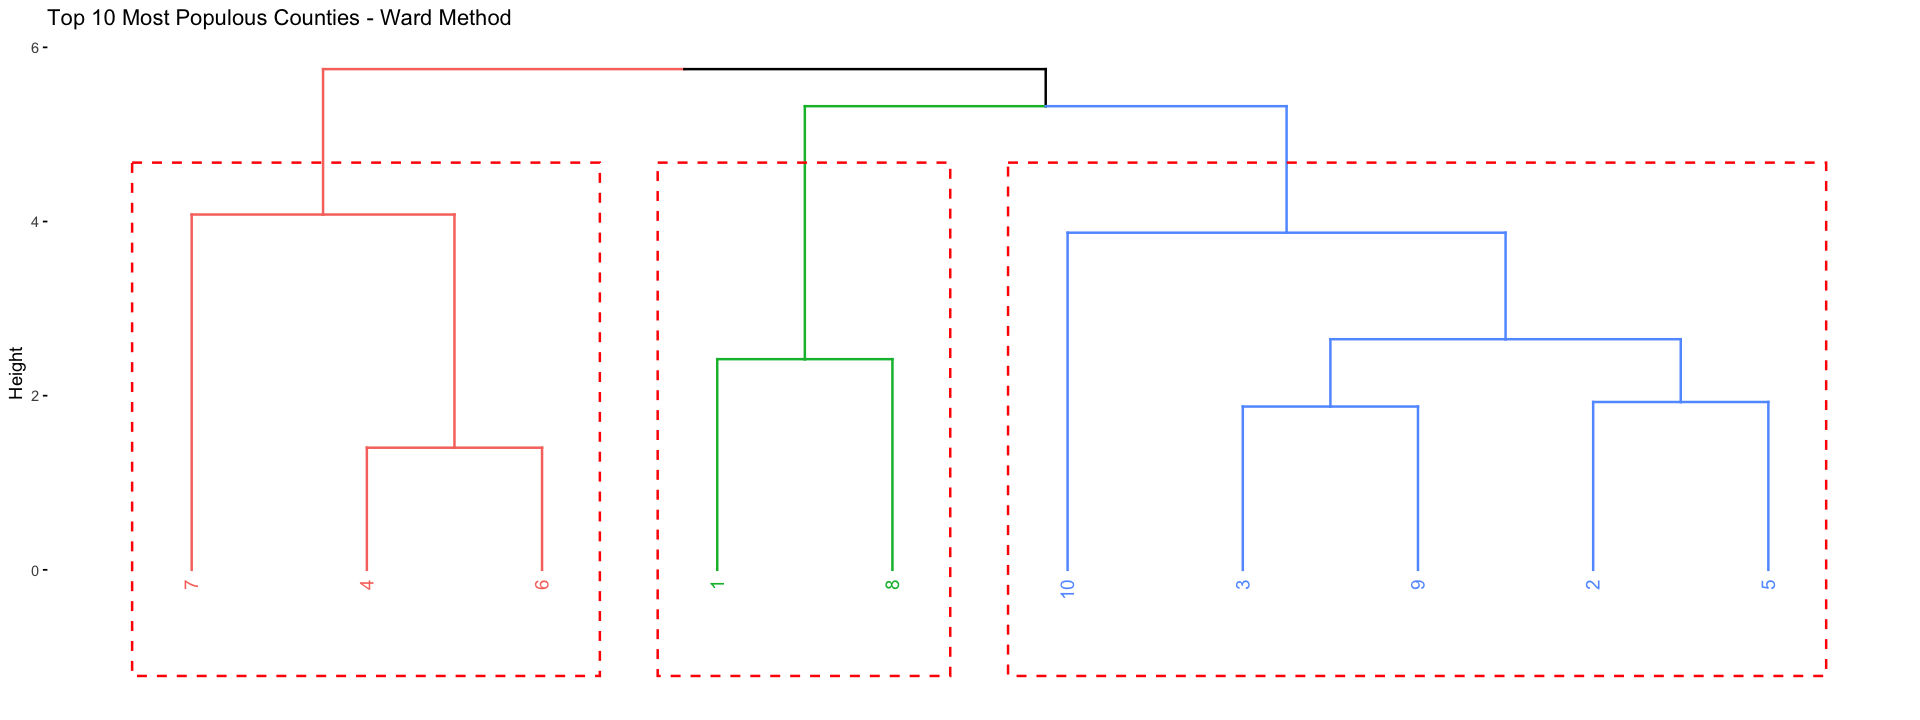

In [83]:
# Convert scaled_df to data frame
scaled_df_15 <- as.data.frame(scaled_df)

# Add the 'county' column 
scaled_df_15$county <- covid_census_tx_clustered$county  # Ensure this matches your full dataset

# Top 10 counties by population 
top10_pop_names <- covid_census_tx_clustered %>%
  arrange(desc(total_pop)) %>%
  slice_head(n = 10) %>%
  pull(county)

# Subset top 10 populous counties
subset_df <- scaled_df_15 %>% 
  filter(county %in% top10_pop_names)

# Dendrogram
dist_subset <- dist(subset_df %>% select(-county))

fviz_dend(hclust(dist_subset, method = "ward.D2"),
          k = 3,
          show_labels = TRUE,
          main = "Top 10 Most Populous Counties - Ward Method",
          rect = TRUE,
          rect_border = "red",
          cex = 0.8)

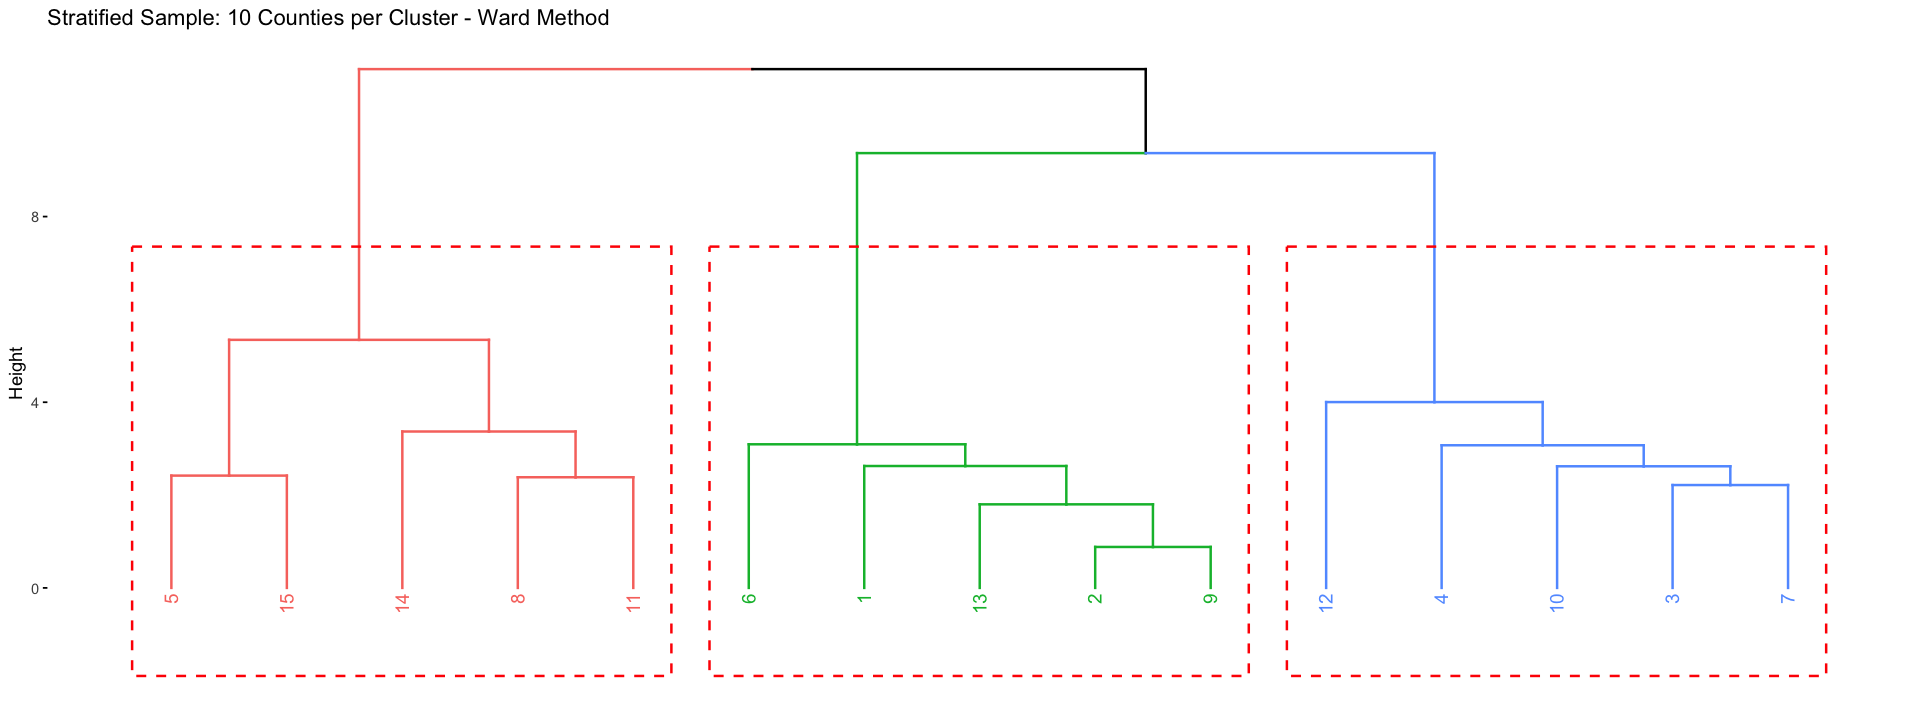

In [86]:
# Stratified sample from top_counties (10 per cluster)
set.seed(42)
strat_subset <- top_counties %>%
  group_by(cluster) %>%
  slice_sample(n = 10) %>%
  ungroup()

# Ensure scaled_df_15 has the county column 
scaled_df_15 <- as.data.frame(scaled_df)  
scaled_df_15$county <- covid_census_tx_clustered$county 

# Filter scaled_df_15 to keep only the 15 counties in top_counties
scaled_df_15 <- scaled_df_15 %>% filter(county %in% top_counties$county)

# Distance matrix and plot dendrogram
dist_subset <- dist(scaled_df_15 %>% select(-county))

fviz_dend(hclust(dist_subset, method = "ward.D2"),
          k = 3,
          show_labels = TRUE,
          main = "Stratified Sample: 10 Counties per Cluster - Ward Method",
          rect = TRUE,
          rect_border = "red",
          cex = 0.8)


In [88]:
# Numeric columns for distance matrix
numeric_columns <- c("cases_per_100k", "deaths_per_100k", "poverty", "median_income",
                     "pct_on_food_stamps", "commuters_by_public_transportation",
                     "pct_work_from_home", "income_per_capita", "gini_index", "total_pop")

# Create distance matrix
dist_matrix <- dist(scale(covid_census_tx_cleaned[, numeric_columns]))

# Perform ward clustering
ward_clusters <- cutree(hclust(dist_matrix, method = "ward.D2"), k = 3)

# Add Ward cluster labels to dataset
covid_census_tx_ward <- covid_census_tx_cleaned %>%
  mutate(ward_cluster = factor(ward_clusters))

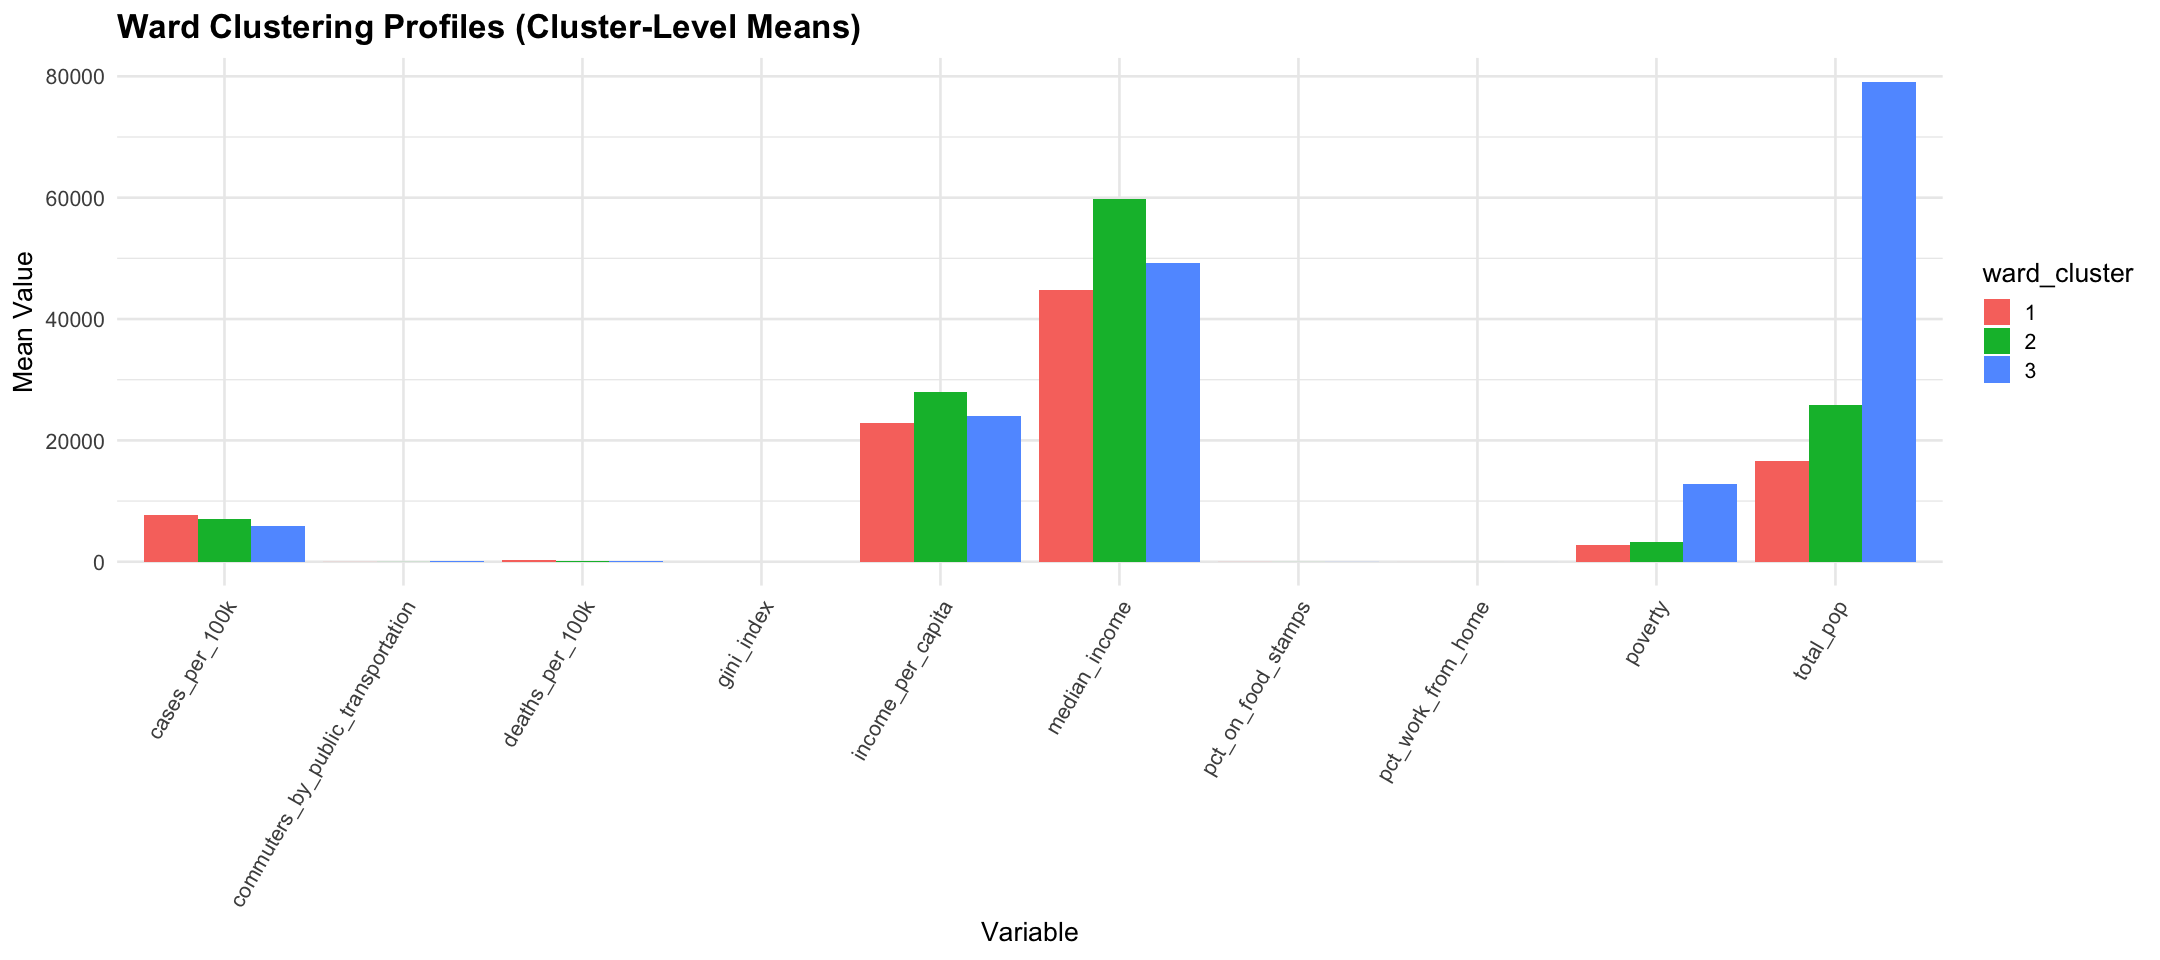

In [90]:
# Compute average variable values for each Ward cluster
ward_summary <- covid_census_tx_ward %>%
  group_by(ward_cluster) %>%
  summarize(across(
    c(cases_per_100k, deaths_per_100k, poverty, median_income, pct_on_food_stamps,
      commuters_by_public_transportation, pct_work_from_home, income_per_capita,
      gini_index, total_pop),
    mean,
    .names = "avg_{.col}"
  ))

# Reshape for plotting
ward_means_long <- ward_summary %>%
  pivot_longer(cols = starts_with("avg_"), names_to = "variable", values_to = "mean_value") %>%
  mutate(variable = gsub("avg_", "", variable))

# Set plot size
options(repr.plot.width = 18, repr.plot.height = 8)

# Plot ward cluster
ggplot(ward_means_long, aes(x = variable, y = mean_value, fill = ward_cluster)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Ward Clustering Profiles (Cluster-Level Means)",
       x = "Variable", y = "Mean Value") +
  theme_minimal(base_size = 16) +
  theme(
    axis.text.x = element_text(angle = 60, hjust = 1),
    plot.title = element_text(size = 20, face = "bold"),
    legend.position = "right"
  )

In [92]:
# Top 5 counties by population in each Ward cluster
top_ward_counties <- covid_census_tx_clustered %>%
  mutate(ward_cluster = factor(ward_clusters)) %>%
  group_by(ward_cluster) %>%
  slice_max(order_by = total_pop, n = 5) %>%
  select(ward_cluster, county, total_pop, cases_per_100k, poverty)

kable(top_ward_counties, caption = "Top 5 Most Populous Counties per Ward Cluster")



Table: Top 5 Most Populous Counties per Ward Cluster

|ward_cluster |county    | total_pop| cases_per_100k| poverty|
|:------------|:---------|---------:|--------------:|-------:|
|1            |walker    |     70818|       9895.789|   12653|
|1            |anderson  |     57747|       9654.181|    6935|
|1            |cherokee  |     51594|       6766.291|    9090|
|1            |lamar     |     49401|      10032.186|    8644|
|1            |val verde |     48976|      12926.740|    9849|
|2            |wise      |     63247|       8512.657|    8042|
|2            |hardin    |     55993|       7286.625|    6669|
|2            |hood      |     55418|       9112.563|    6722|
|2            |van zandt |     53607|       5883.560|    7489|
|2            |rusk      |     53026|       5780.183|    7576|
|3            |bowie     |     93635|       5207.454|   15750|
|3            |hunt      |     90322|       5045.282|   16430|
|3            |angelina  |     87700|       7713.797|   16222|

In [94]:
# Create contingency table
comparison_table <- table(KMeans = km$cluster, Ward = ward_clusters)

# Convert contingency table to data frame
comparison_df <- as.data.frame.matrix(comparison_table)
comparison_df$KMeans_Cluster <- rownames(comparison_df)
comparison_df <- comparison_df[, c("KMeans_Cluster", "1", "2", "3")]

# Datatable 
datatable(comparison_df, 
          caption = "Contingency Table: K-means vs Ward Clustering (k = 3)",
          rownames = FALSE,
          options = list(dom = 't', pageLength = 5))

HTML widgets cannot be represented in plain text (need html)

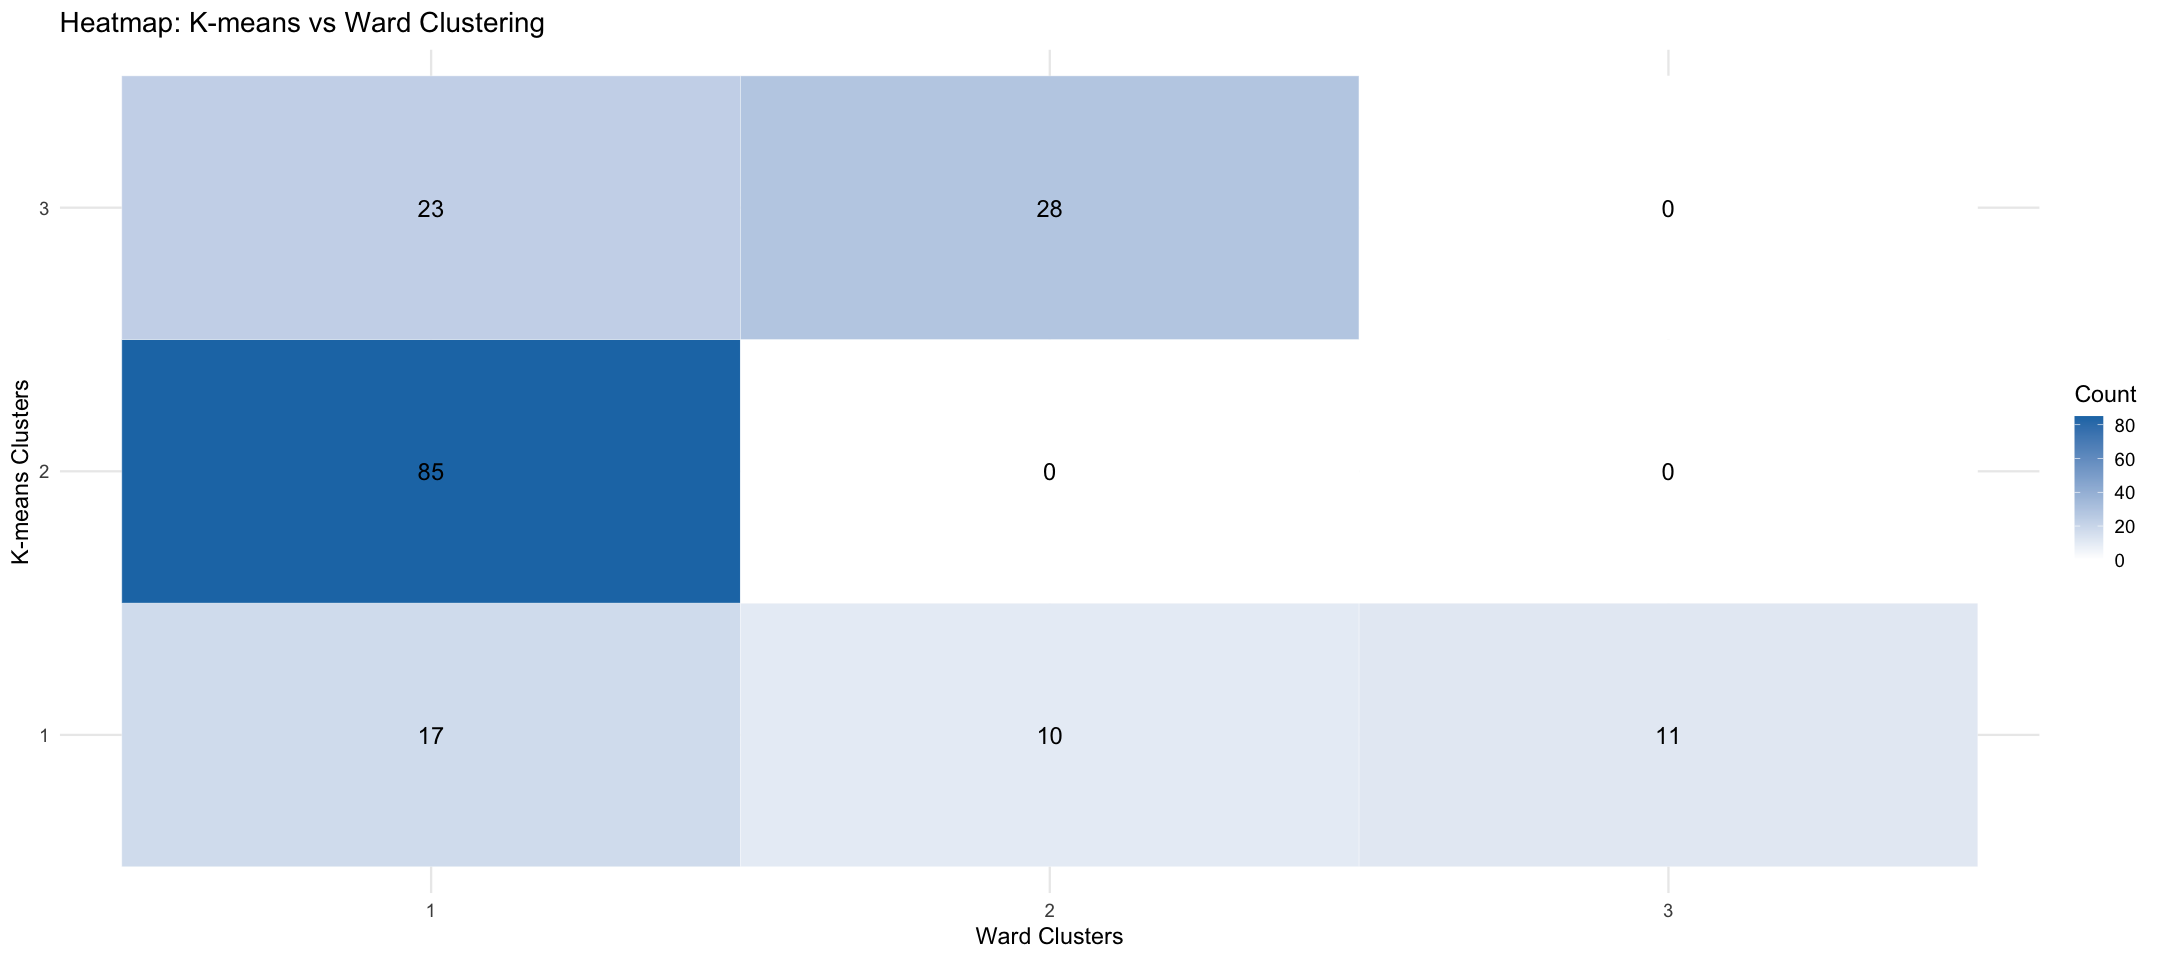

In [96]:
# Convert to data frame
heat_df <- as.data.frame(comparison_table)

# Rename columns 
colnames(heat_df) <- c("KMeans", "Ward", "Count")

# Heatmap plot: KMEANS vs Ward
ggplot(heat_df, aes(x = Ward, y = KMeans, fill = Count)) +
  geom_tile(color = "white") +
  geom_text(aes(label = Count), color = "black", size = 5) +
  scale_fill_gradient(low = "white", high = "#1f78b4") +
  labs(
    title = "Heatmap: K-means vs Ward Clustering",
    x = "Ward Clusters",
    y = "K-means Clusters",
    fill = "Count"
  ) +
  theme_minimal(base_size = 14)

  cluster size ave.sil.width
1       1   38          0.21
2       2   85          0.17
3       3   51          0.16
  cluster size ave.sil.width
1       1  125          0.13
2       2   38          0.19
3       3   11          0.40


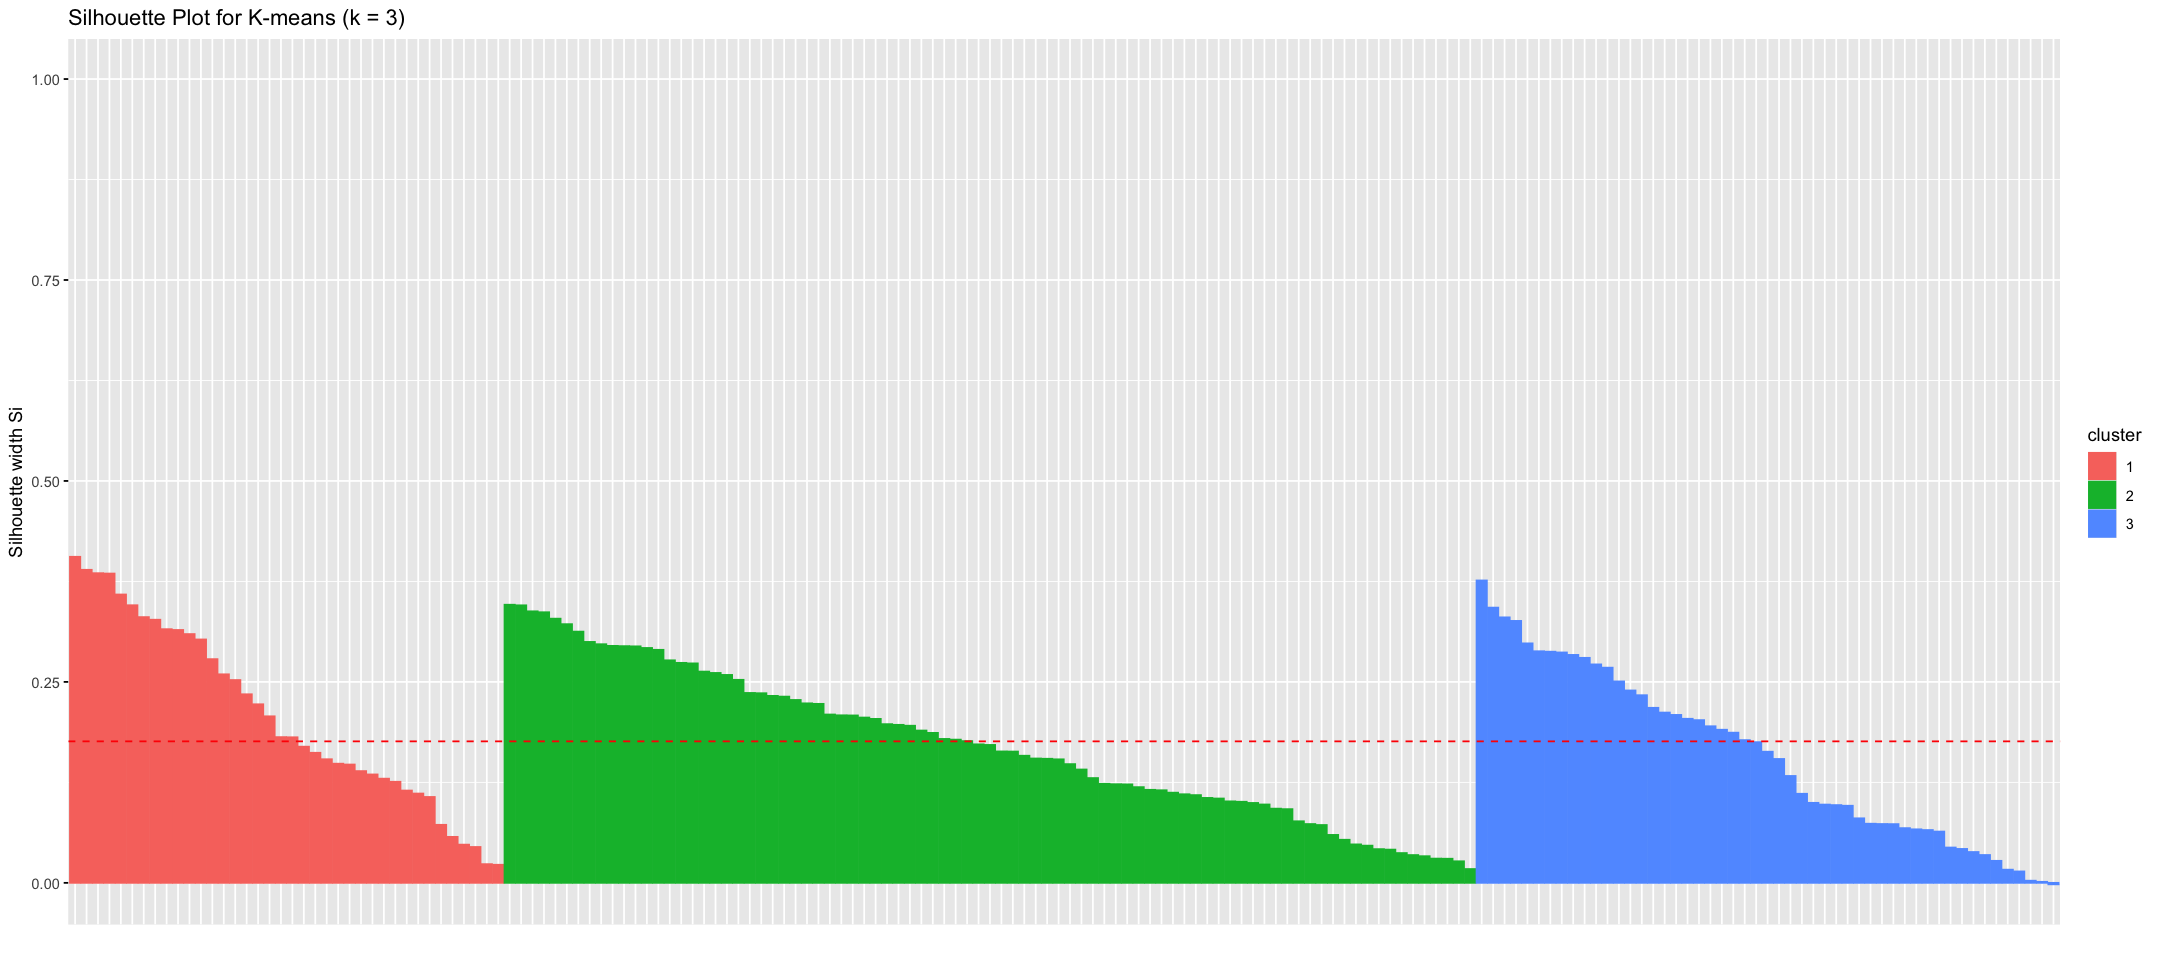

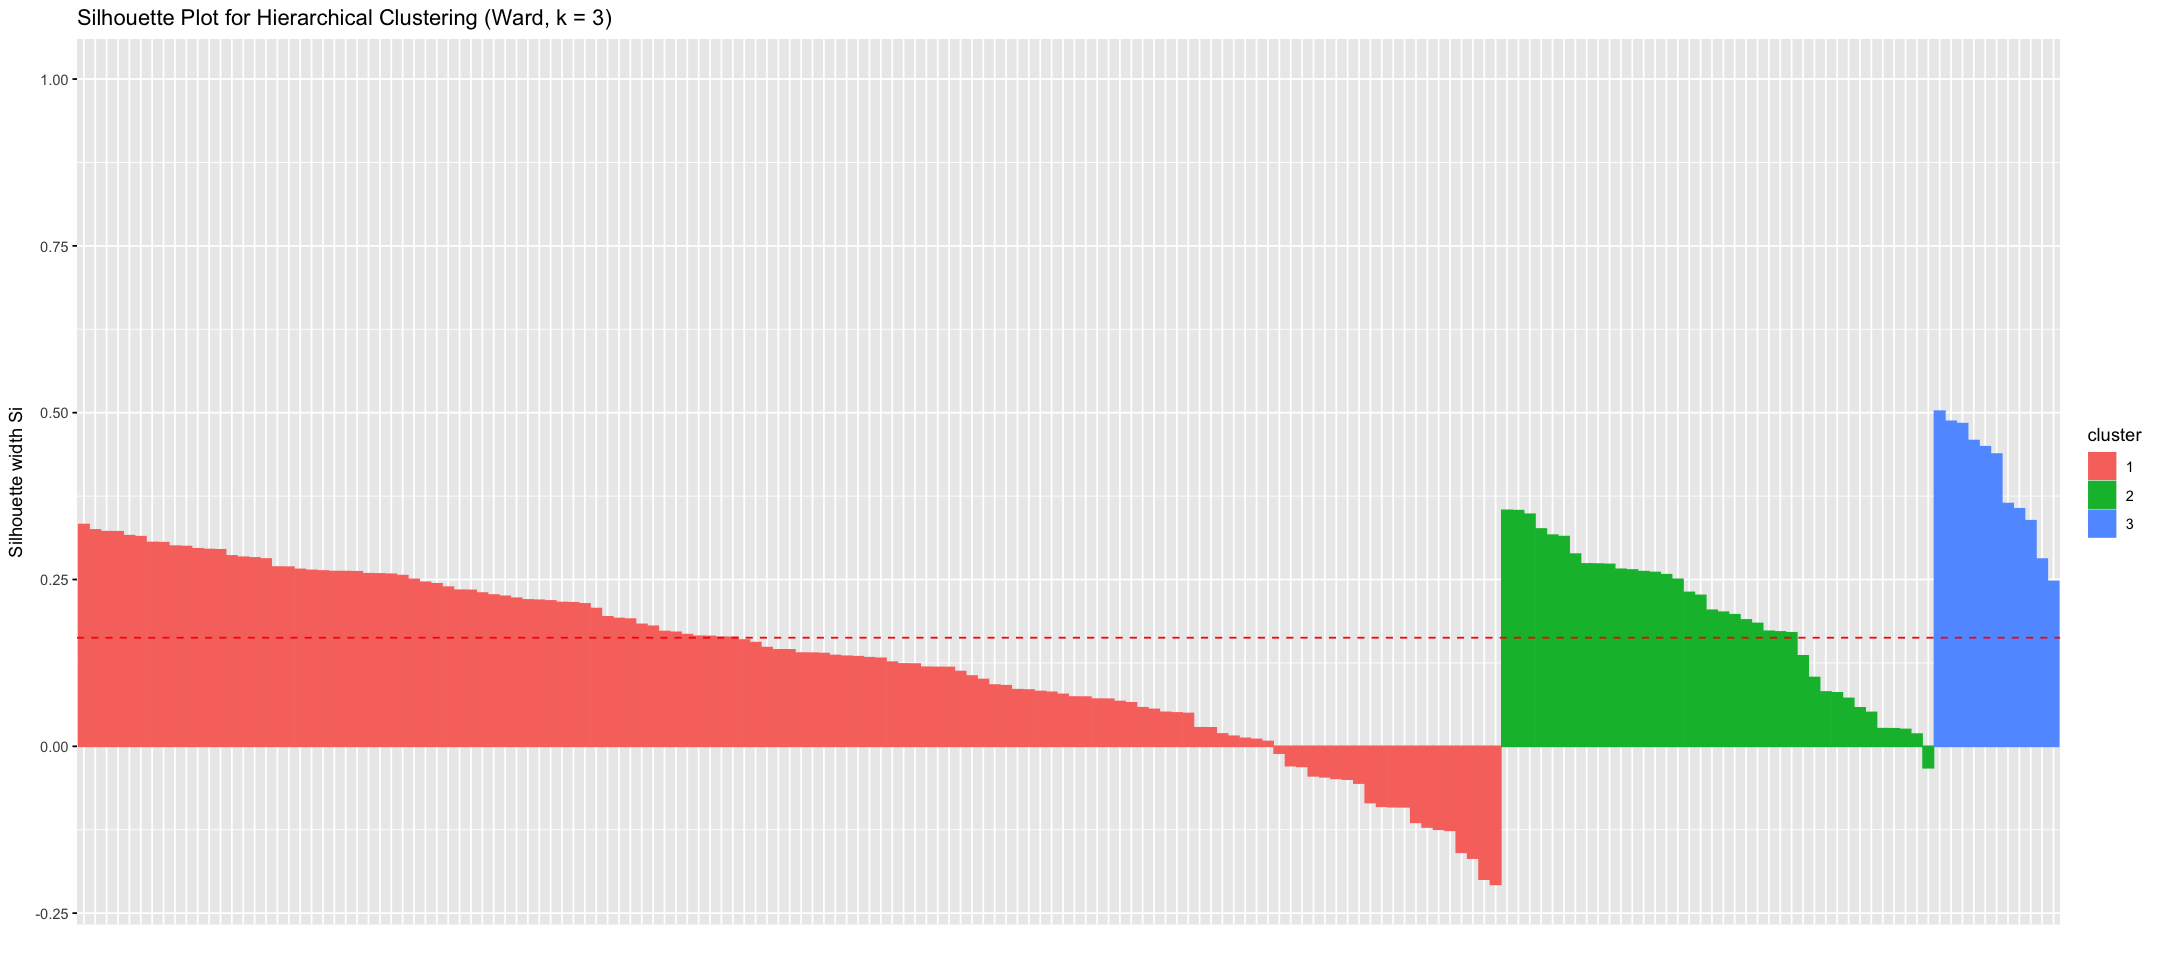

In [98]:
# ---- Silhouette score for K-means with k = 3 ----
sil_k3 <- silhouette(km$cluster, dist(scaled_df))
fviz_silhouette(sil_k3) +
  labs(title = "Silhouette Plot for K-means (k = 3)")

# ---- Silhouette score for Ward Clustering ----
ward_sil <- silhouette(ward_clusters, dist(scaled_df))
fviz_silhouette(ward_sil) +
  labs(title = "Silhouette Plot for Hierarchical Clustering (Ward, k = 3)")

In [100]:
# Compute Adjusted Rand Index between K-means and Ward clusters
ari_score <- adjustedRandIndex(km$cluster, ward_clusters)
cat("Adjusted Rand Index (K-means vs Ward):", round(ari_score, 3), "\n")

Adjusted Rand Index (K-means vs Ward): 0.334 


In [102]:
# Define the ground truth: mortality severity tiers
comparison_ari_df <- covid_census_tx_cleaned %>%
  mutate(
    death_severity_tier = case_when(
      deaths_per_100k <= 100 ~ "Low",
      deaths_per_100k > 100 & deaths_per_100k <= 200 ~ "Medium",
      deaths_per_100k > 200 ~ "High"
    ),
    kmeans_cluster = km$cluster,
    ward_cluster = cutree(hclust(dist(scaled_df), method = "ward.D2"), k = 3)
  )

# Compute ARI scores
ari_kmeans_truth <- adjustedRandIndex(comparison_ari_df$kmeans_cluster, comparison_ari_df$death_severity_tier)
ari_ward_truth   <- adjustedRandIndex(comparison_ari_df$ward_cluster, comparison_ari_df$death_severity_tier)

# Output the results
cat("K-means vs Ground Truth ARI:", round(ari_kmeans_truth, 3), "\n")
cat("Ward vs Ground Truth ARI:", round(ari_ward_truth, 3), "\n")

K-means vs Ground Truth ARI: 0.077 
Ward vs Ground Truth ARI: 0.068 


## 3.10 Graduate-Level Analysis by Salissa Hernandez

In [105]:
# Standardize
scaled_df <- scale(clustering_df)

## 3.14 Graduate-Level Analysis by Juan Carlos Dominguez

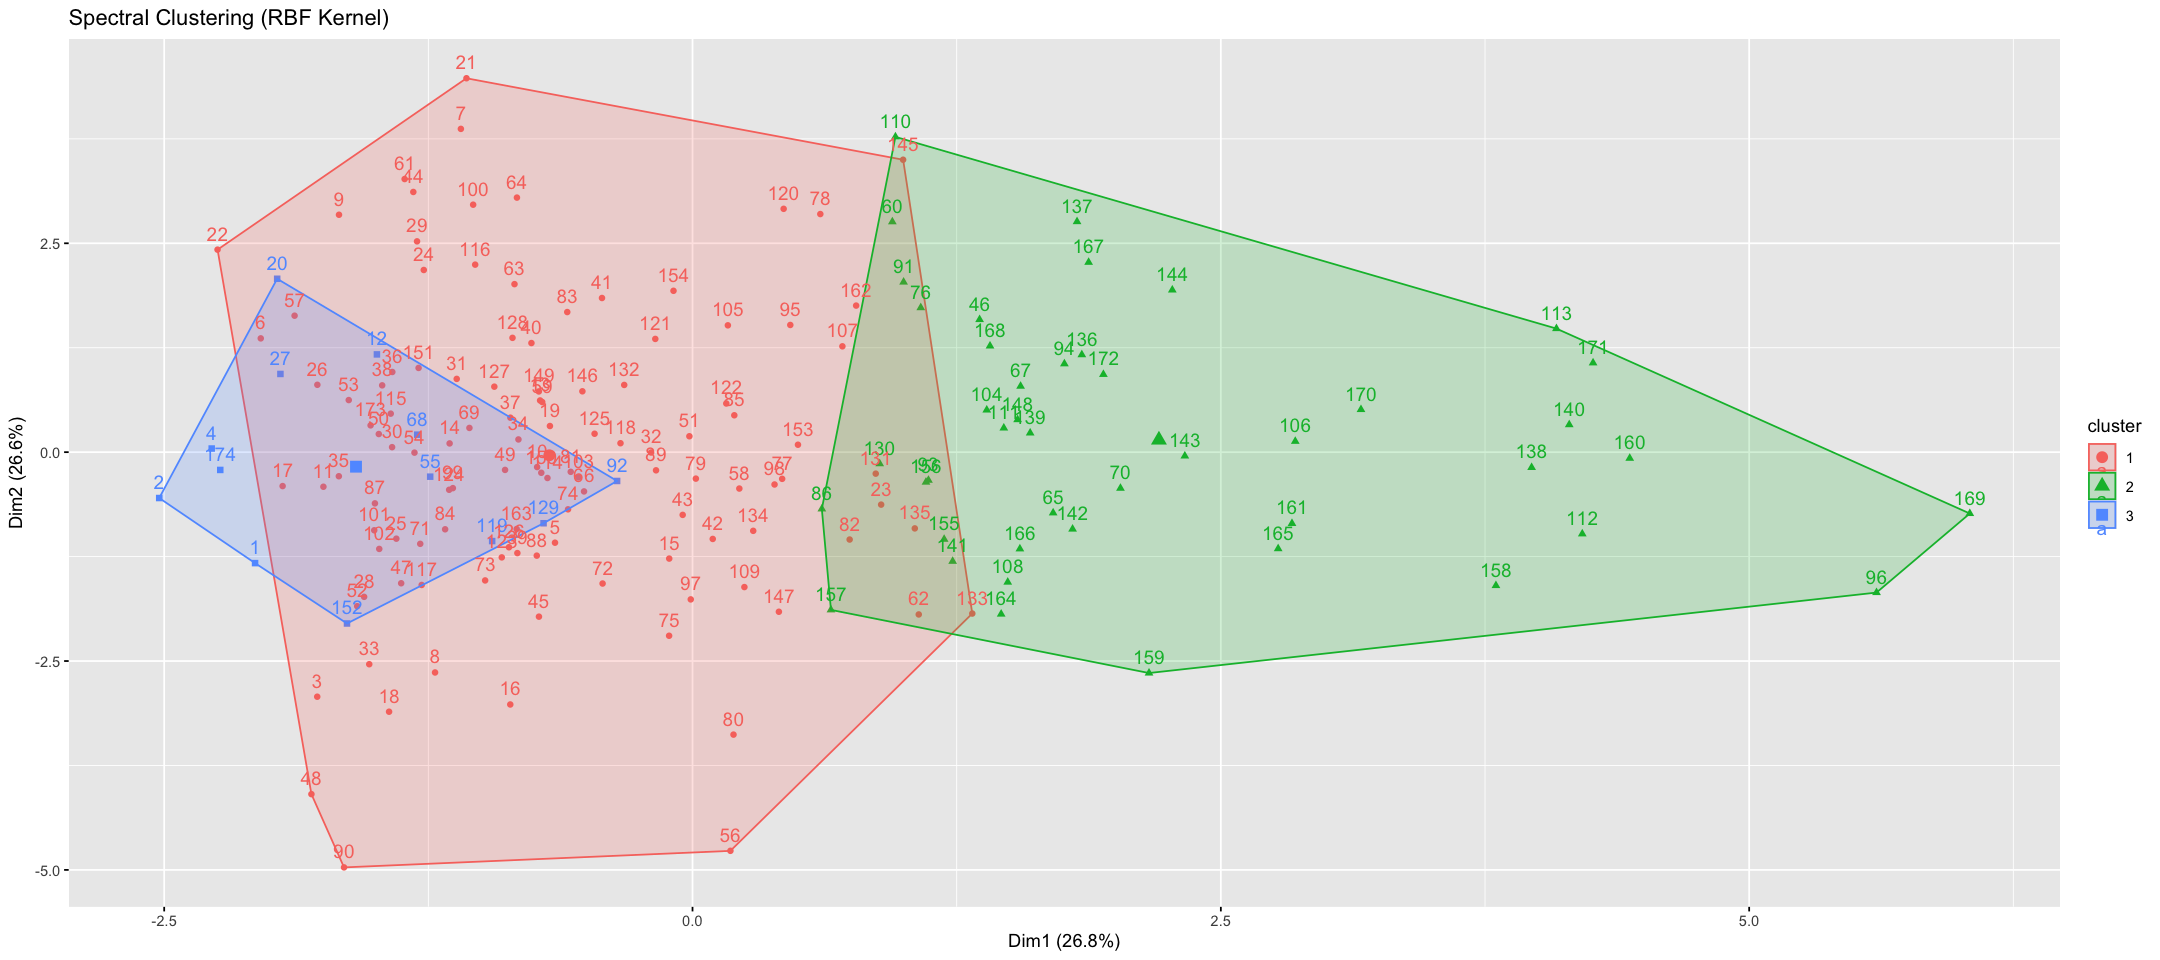

In [108]:
# Spectral clustering
spec_model <- specc(scaled_df, centers = 3)
spec_clusters <- as.numeric(spec_model)

# Sisplay
fviz_cluster(list(data = scaled_df, cluster = spec_clusters), 
             main = "Spectral Clustering (RBF Kernel)")

In [110]:
# Make sure covid_census_tx has 174 rows, matching the cluster assignments
covid_census_tx_reduced <- covid_census_tx[1:174, ]

# Now, mutate the cluster assignment
covid_census_tx_clustered <- covid_census_tx_reduced %>%
  mutate(cluster = factor(spec_clusters))

# Summarize the data by cluster
covid_census_tx_clustered %>%
  group_by(cluster) %>%
  summarize(
    avg_cases_per_100k = mean(cases_per_100k, na.rm = TRUE),
    avg_deaths_per_100k = mean(deaths_per_100k, na.rm = TRUE),
    n = n()
  )

cluster avg_cases_per_100k avg_deaths_per_100k n  
1 1       7614.451           206.4380            116
2 2       7436.168           184.2199             45
3 3       8109.346           212.7532             13

In [112]:
# Scale the dataset
scaled_df <- scale(clustering_df)

# Run Spectral Clustering
spectral_model <- specc(scaled_df, centers = 3)

# Add spectral cluster labels 
spectral_clusters <- as.integer(spectral_model)
covid_census_tx_cleaned$cluster <- factor(spectral_clusters)

# Summarize variables by spectral cluster
summary_result <- covid_census_tx_cleaned %>%
  group_by(cluster) %>%
  summarize(
    avg_cases_per_100k = mean(cases_per_100k, na.rm = TRUE),
    avg_deaths_per_100k = mean(deaths_per_100k, na.rm = TRUE),
    avg_poverty = mean(poverty, na.rm = TRUE),
    avg_median_income = mean(median_income, na.rm = TRUE),
    avg_pct_on_food_stamps = mean(pct_on_food_stamps, na.rm = TRUE),
    avg_commuters_by_public_transportation = mean(commuters_by_public_transportation, na.rm = TRUE),
    avg_pct_work_from_home = mean(pct_work_from_home, na.rm = TRUE),
    avg_income_per_capita = mean(income_per_capita, na.rm = TRUE),
    avg_gini_index = mean(gini_index, na.rm = TRUE),
    avg_total_pop = mean(total_pop, na.rm = TRUE),
    n = n()
  )

# View the summary
summary_result

cluster avg_cases_per_100k avg_deaths_per_100k avg_poverty avg_median_income
1 1        7026.252          187.6466            2021.729    47555.61         
2 2       11346.801          299.5324            1606.385    51581.00         
3 3        7412.799          149.9073            8186.791    49683.81         
  avg_pct_on_food_stamps avg_commuters_by_public_transportation
1 12.80484                6.974576                             
2 10.02766               15.384615                             
3 13.94488               50.651163                             
  avg_pct_work_from_home avg_income_per_capita avg_gini_index avg_total_pop n  
1 3.195335               23980.54              0.4549551      13139.50      118
2 1.804262               23439.62              0.4172538      10397.46       13
3 3.489391               24513.40              0.4563907      52235.19       43

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


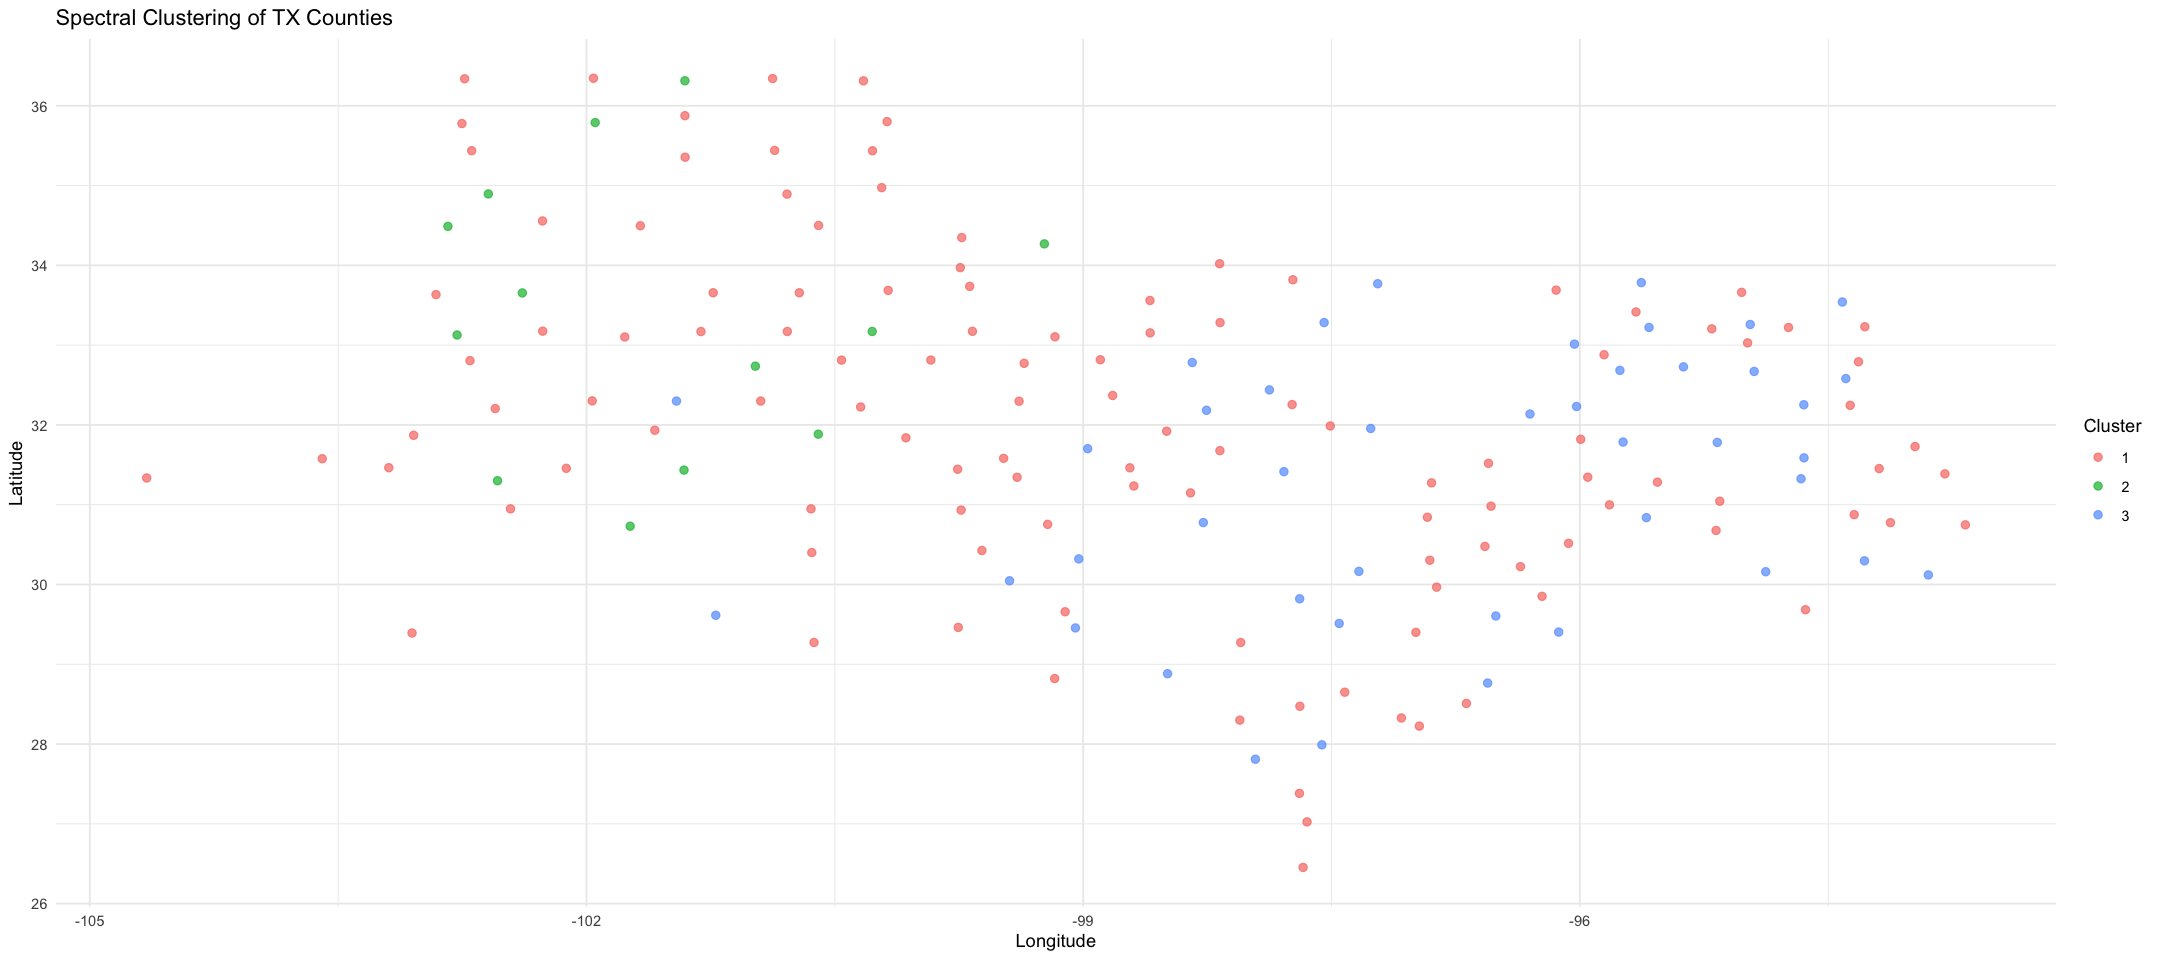

In [114]:
# Assign Spectral Clustering labels
covid_census_tx_cleaned$cluster <- factor(spectral_clusters)

# Get all US county map data
county_data <- map_data("county")

# Filter for Texas only
tx_map <- county_data %>%
  filter(region == "texas")

# Get longitude/latitude centroid per Texas county
tx_coords_df <- tx_map %>%
  group_by(subregion) %>%
  summarize(
    longitude = mean(long),
    latitude = mean(lat)
  ) %>%
  rename(county = subregion)

# Clean county names 
covid_census_tx_cleaned$county <- covid_census_tx_cleaned$county %>%
  str_to_lower() %>%
  str_replace(" county$", "") %>%
  str_trim()

# Merge coordinate data 
covid_census_tx_cleaned <- left_join(covid_census_tx_cleaned, tx_coords_df, by = "county")

# Plot Spectral Clustering 
ggplot(covid_census_tx_cleaned, aes(x = longitude, y = latitude, color = cluster)) +
  geom_point(size = 2, alpha = 0.7) +
  labs(
    title = "Spectral Clustering of TX Counties",
    x = "Longitude", y = "Latitude", color = "Cluster"
  ) +
  theme_minimal()

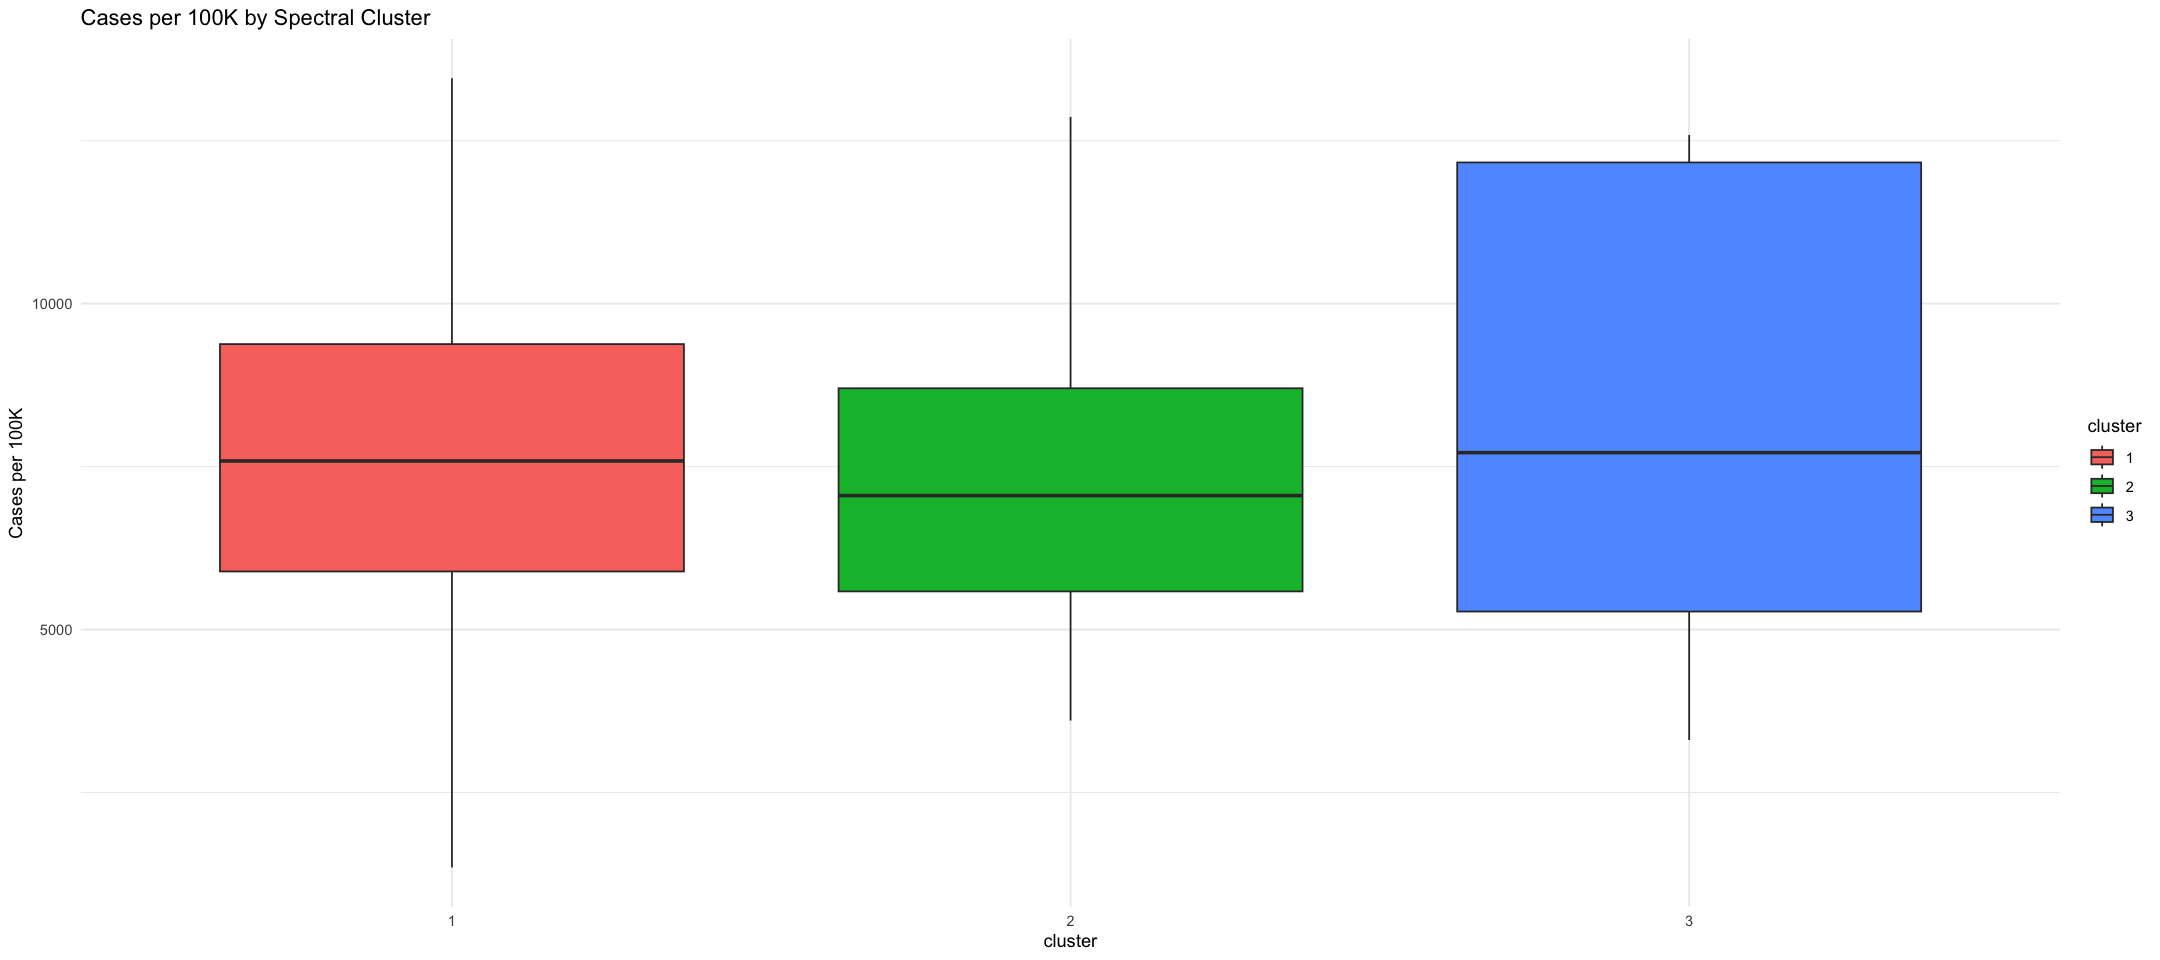

In [116]:
# Box Plot: Cases per 100K by Spectral Cluster
ggplot(covid_census_tx_clustered, aes(x = cluster, y = cases_per_100k, fill = cluster)) +
  geom_boxplot() +
  labs(title = "Cases per 100K by Spectral Cluster", y = "Cases per 100K") +
  theme_minimal()

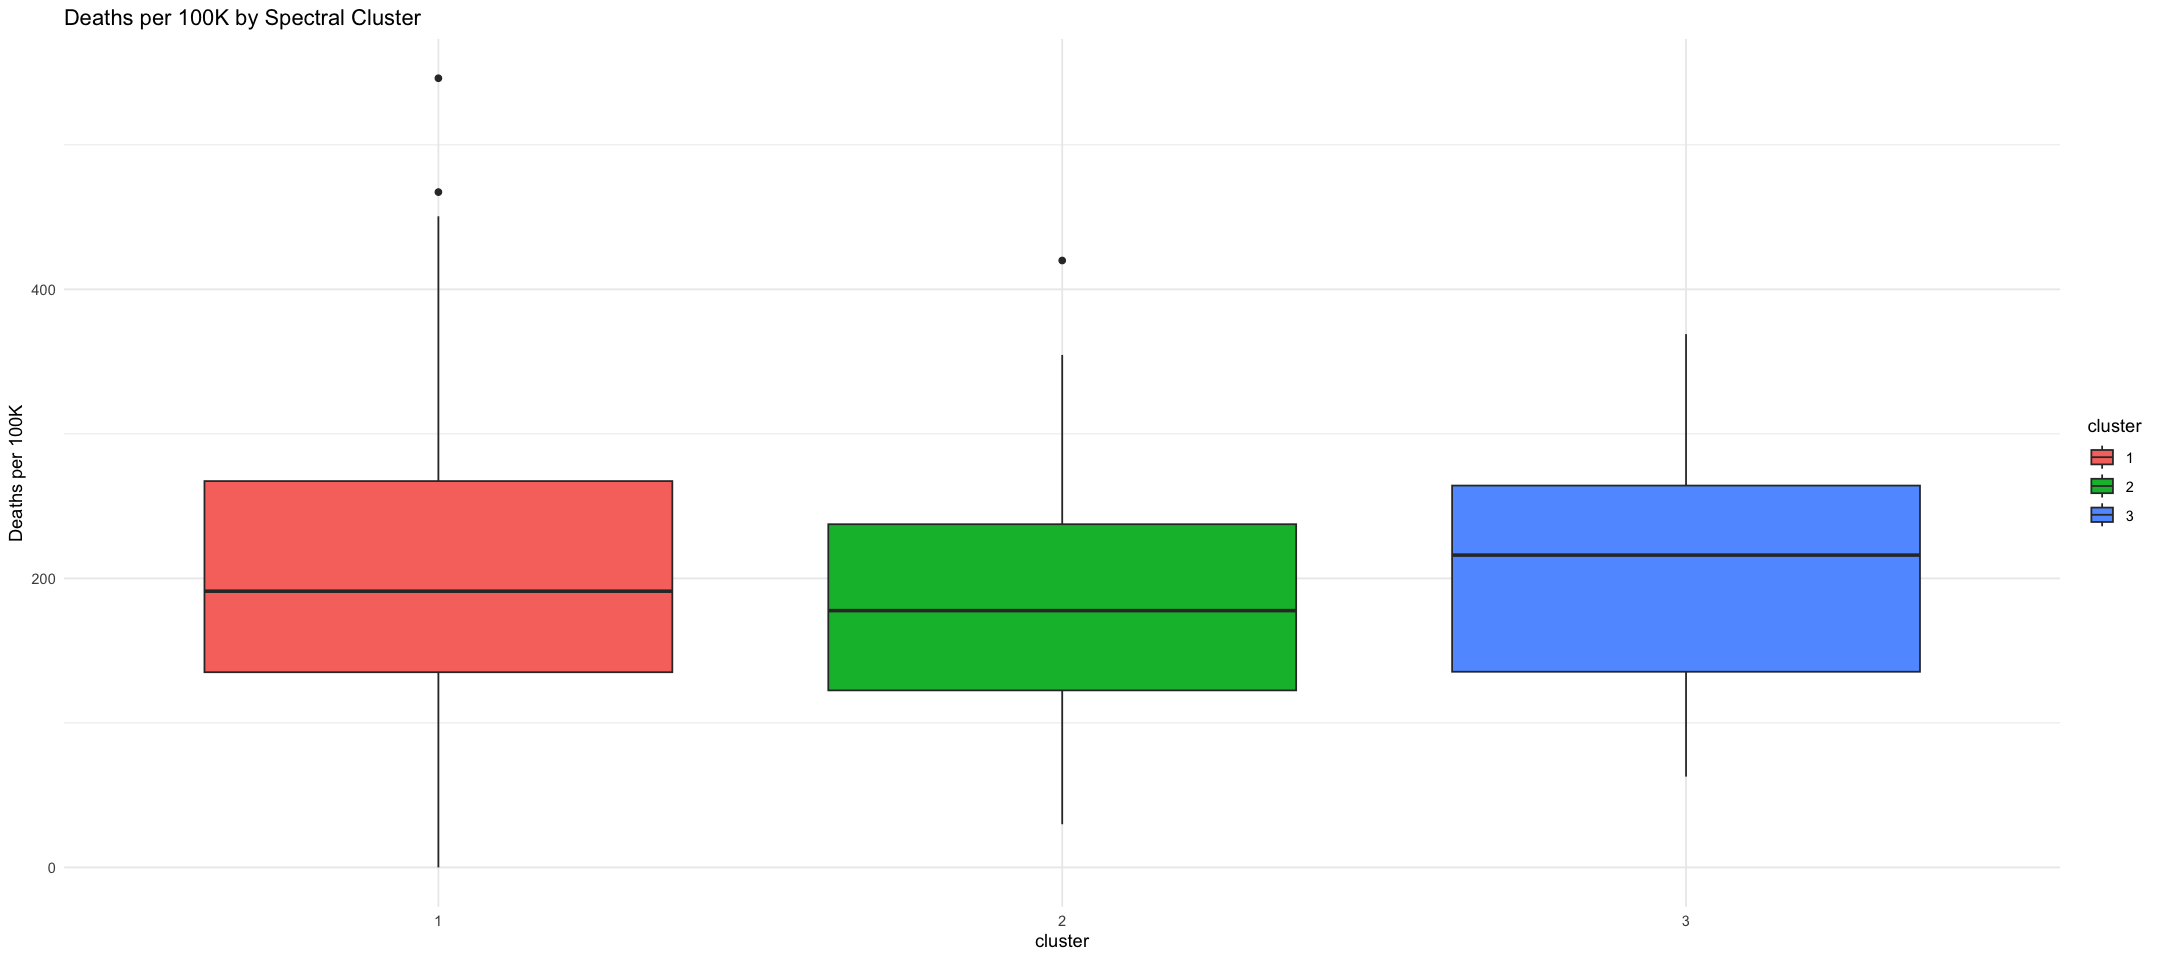

In [118]:
# Box plot: Deaths per 100K 
ggplot(covid_census_tx_clustered, aes(x = cluster, y = deaths_per_100k, fill = cluster)) +
  geom_boxplot() +
  labs(title = "Deaths per 100K by Spectral Cluster", y = "Deaths per 100K") +
  theme_minimal()

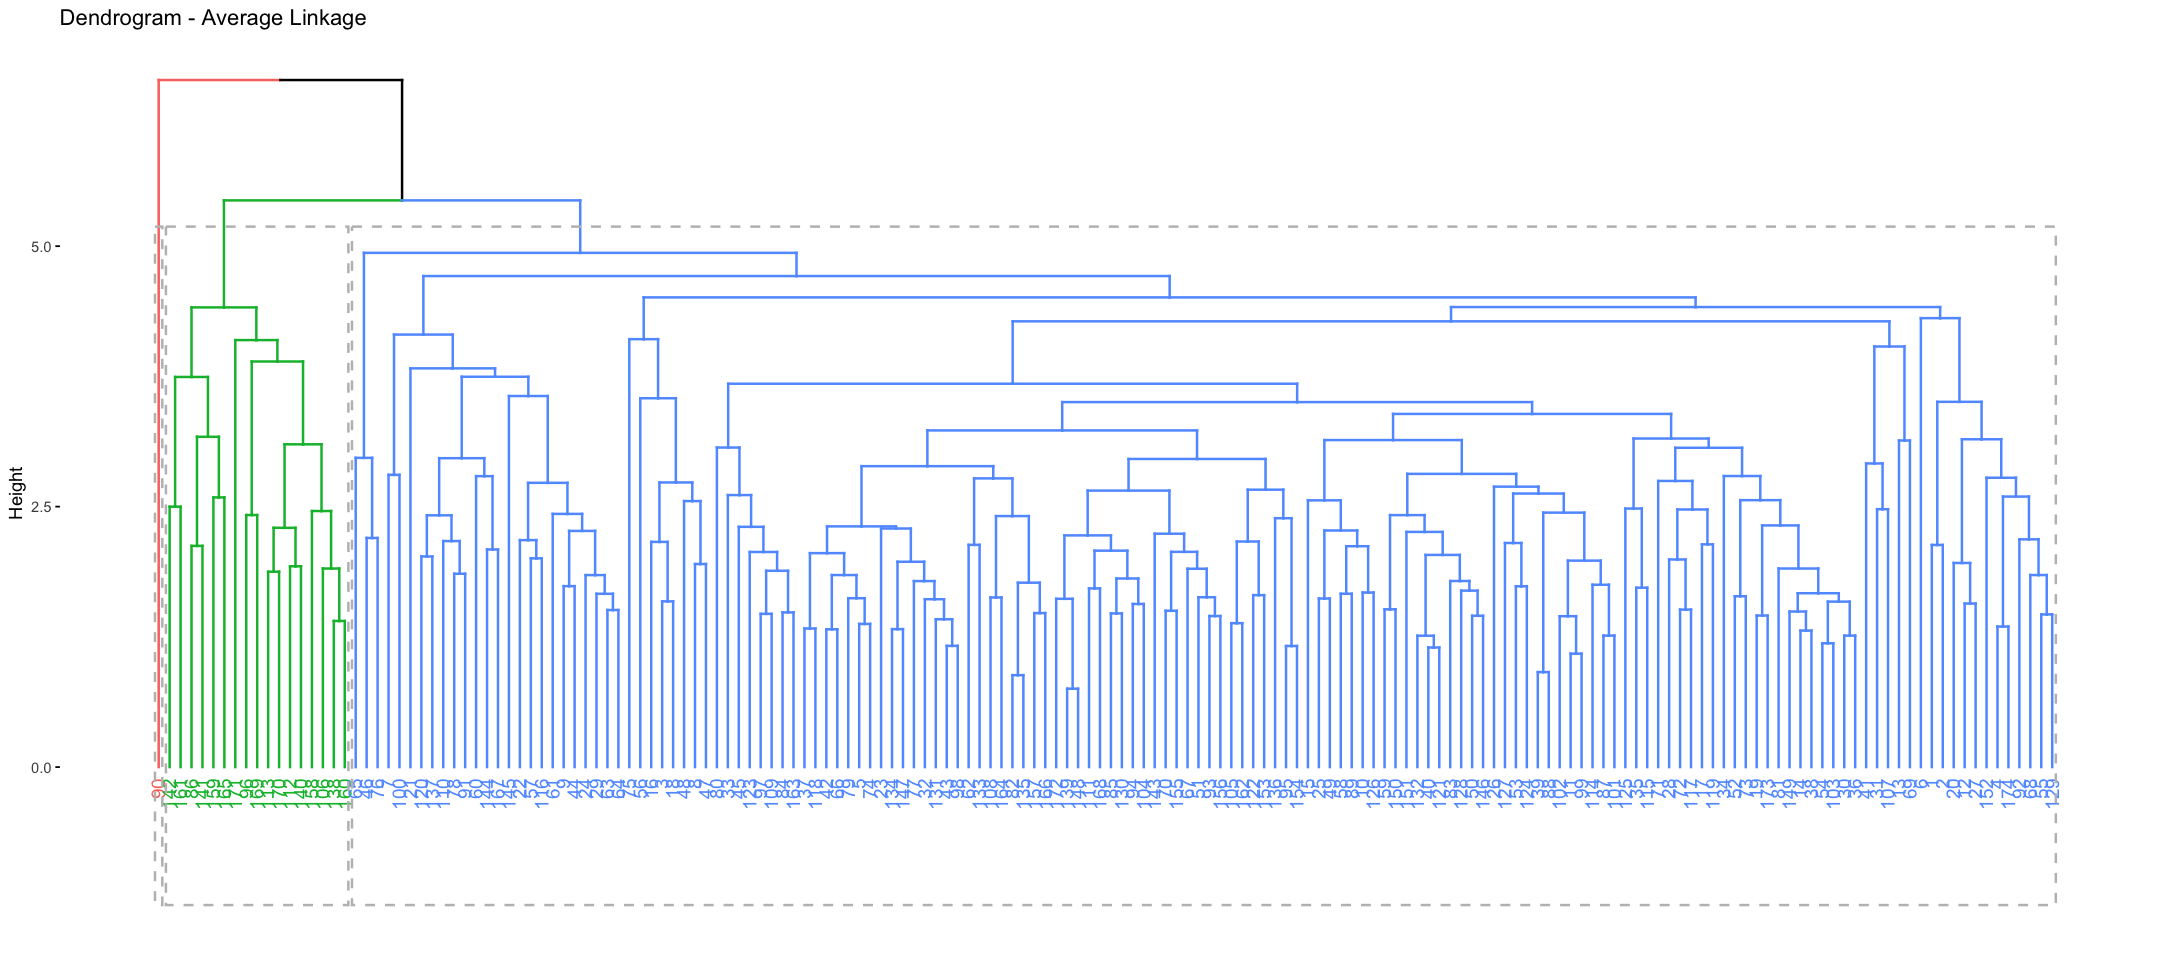

In [120]:
# Agglomerative Clustering (Average Linkage)
# Dendrogram avg linkage
dist_matrix <- dist(scaled_df)
hc_avg <- hclust(dist_matrix, method = "average")
avg_clusters <- cutree(hc_avg, k = 3)

# Plot dendrogram
fviz_dend(hc_avg, k = 3, rect = TRUE, main = "Dendrogram - Average Linkage")

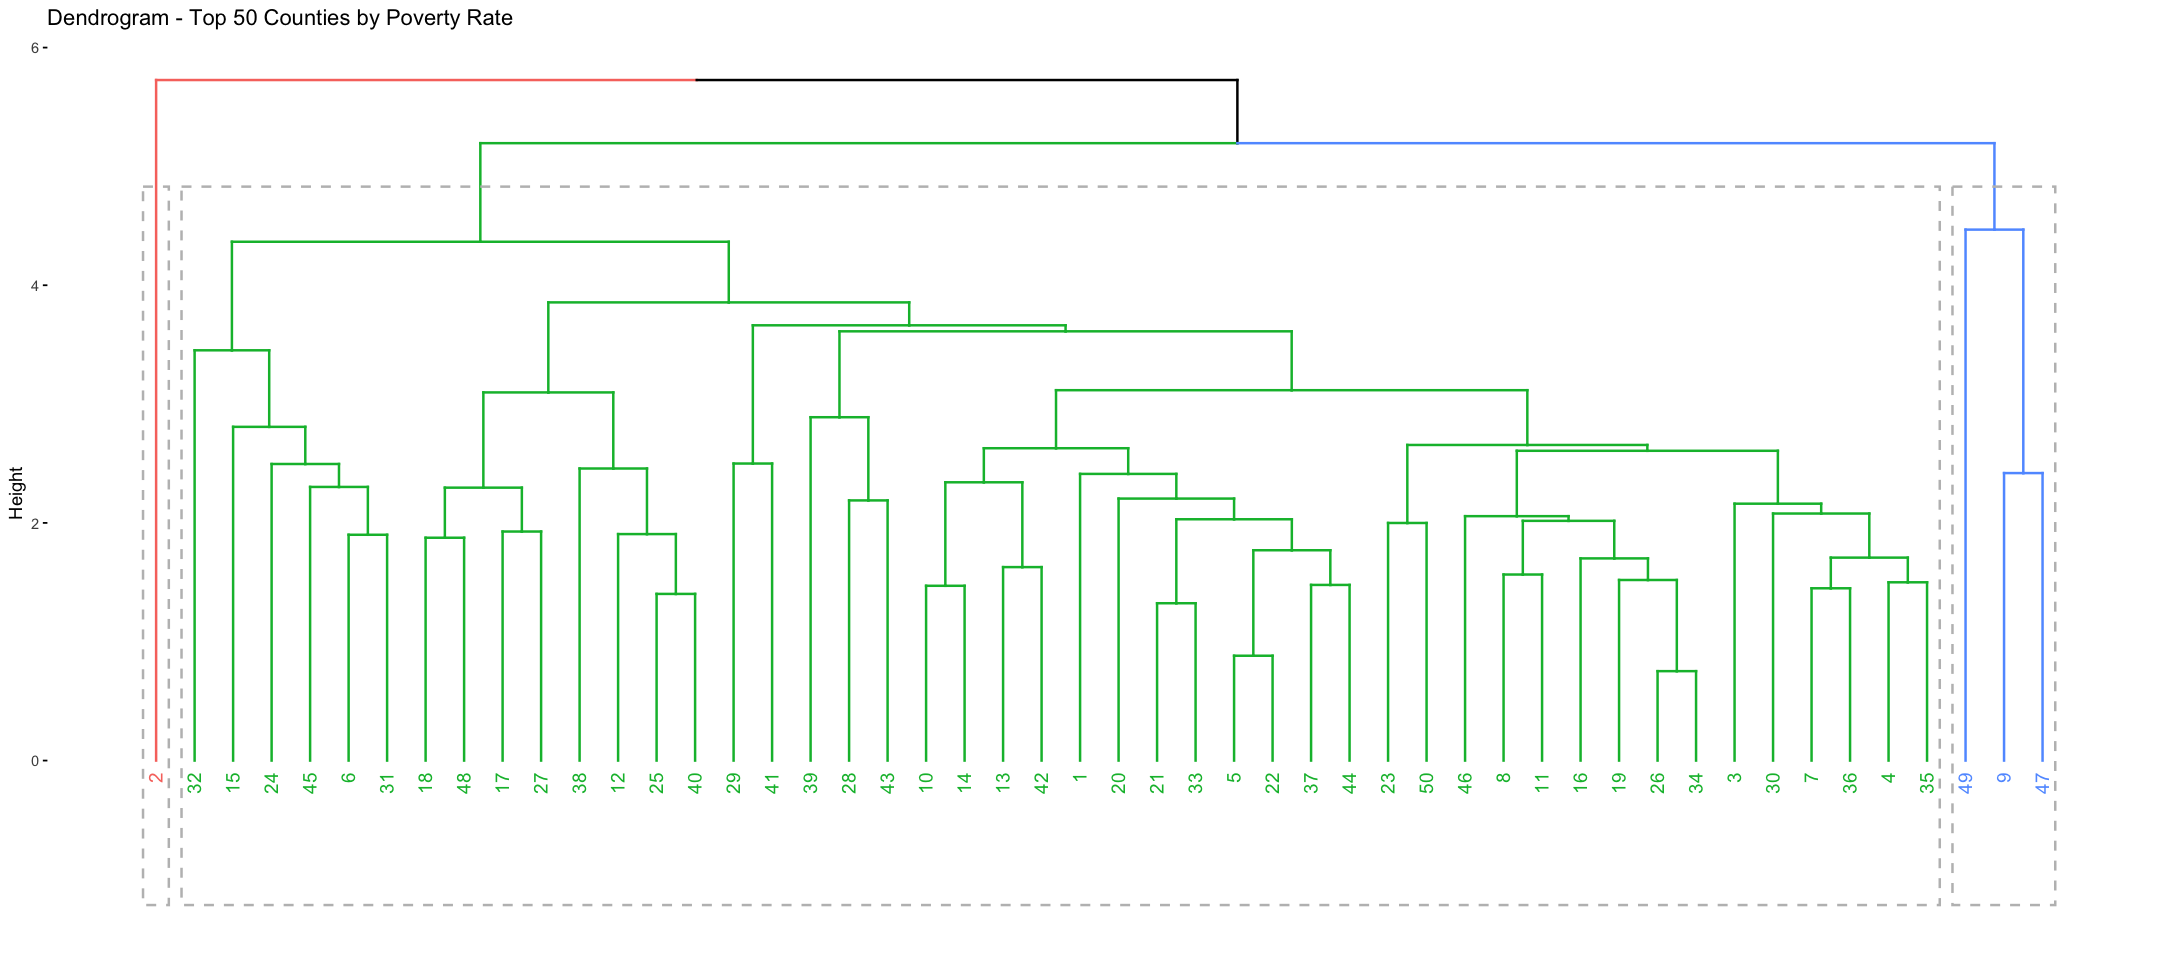

In [121]:
# Get the indices of the top 50 counties by poverty rate
top_50_indices <- covid_census_tx_cleaned %>%
  arrange(desc(poverty)) %>%
  slice(1:50) %>%
  pull(county)  # Extract county names

# Subset the scaled dataframe using these indices
top_50_scaled <- scaled_df[which(covid_census_tx_cleaned$county %in% top_50_indices), ]

# Perform hierarchical clustering on this subset
dist_matrix <- dist(top_50_scaled)
hc_avg <- hclust(dist_matrix, method = "average")
avg_clusters <- cutree(hc_avg, k = 3)

# Plot dendrogram
fviz_dend(hc_avg, k = 3, rect = TRUE, main = "Dendrogram - Top 50 Counties by Poverty Rate")


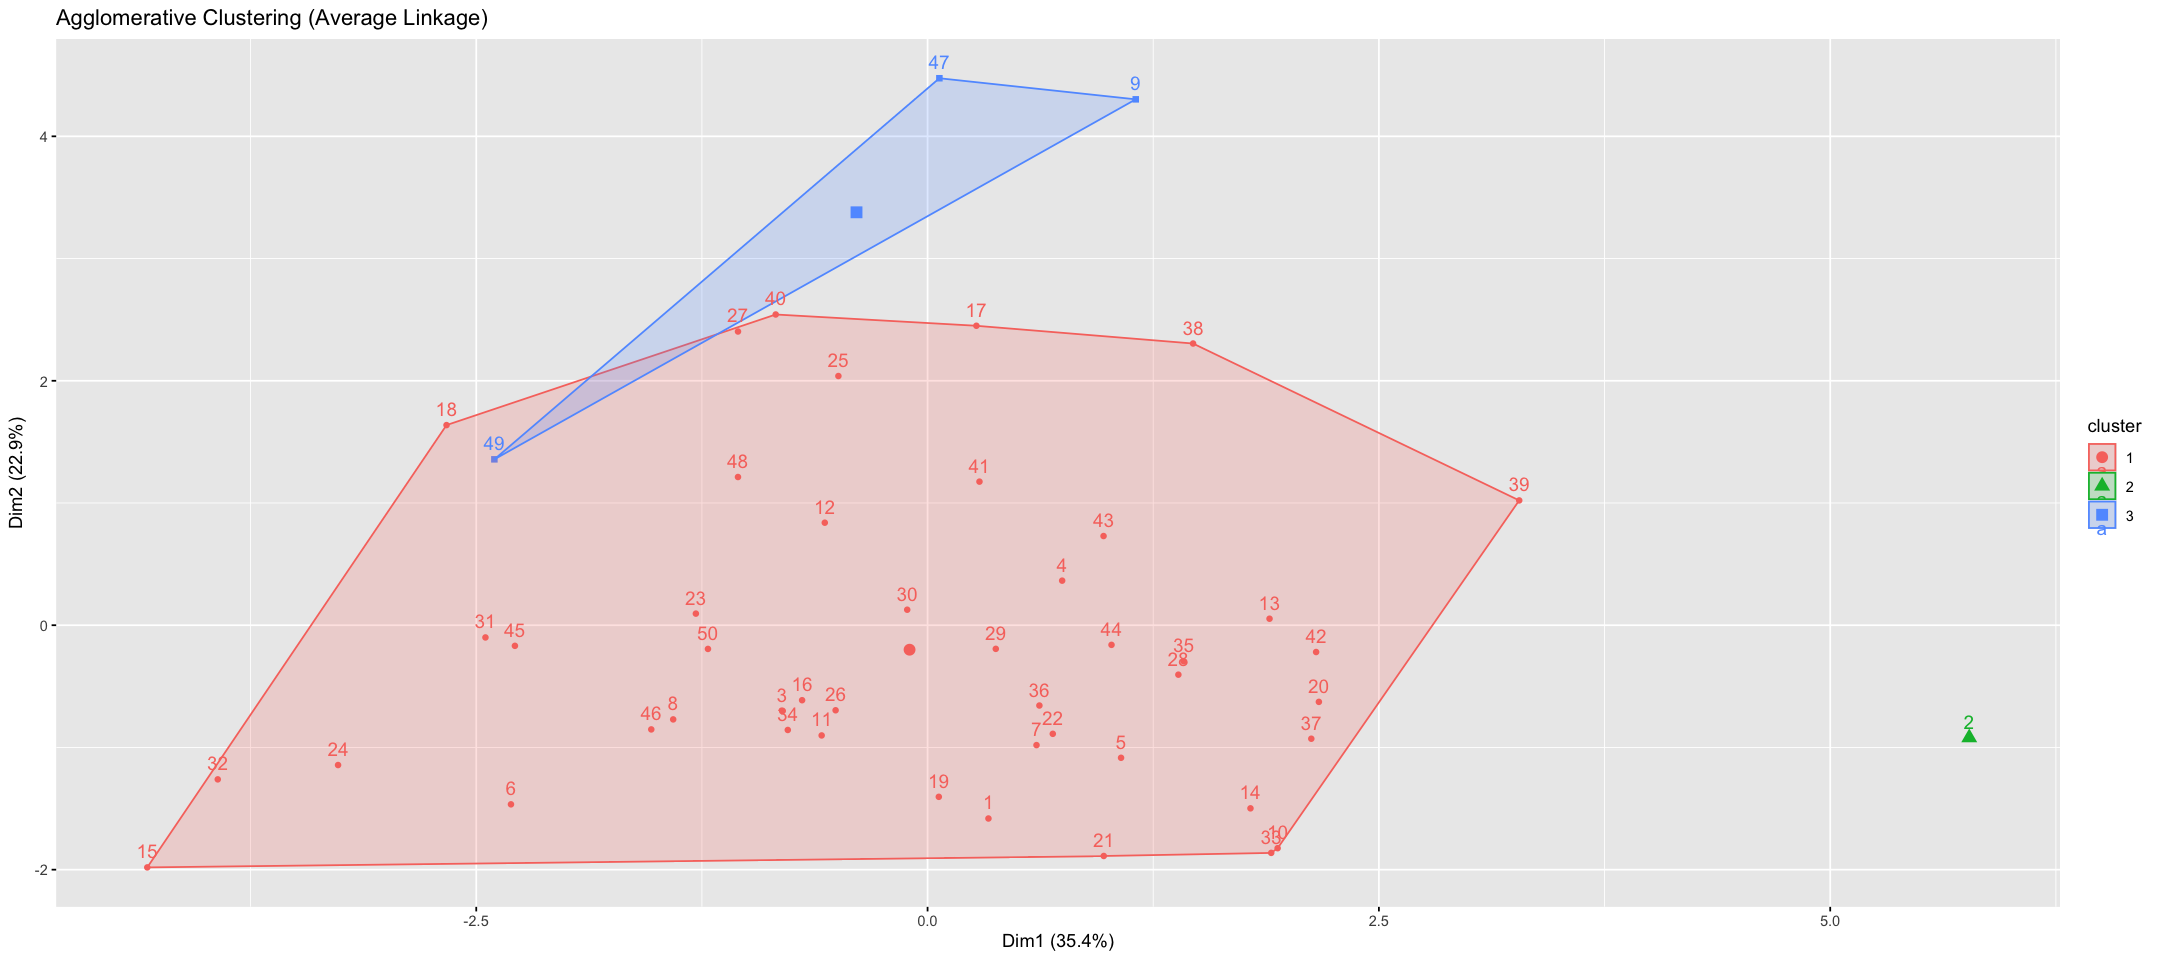

In [124]:
# Visualize the clustering results
fviz_cluster(list(data = top_50_scaled, cluster = avg_clusters), 
             main = "Agglomerative Clustering (Average Linkage)")

In [126]:
# Create filtered dataset of top 50 counties with cluster labels
covid_census_tx_clustered <- covid_census_tx_cleaned %>%
  filter(county %in% top_50_indices) %>%
  mutate(cluster = factor(avg_clusters))

# Create a lookup table: counties + clusters
cluster_map <- covid_census_tx_clustered %>%
  select(county, cluster)

# Prepare full dataset: standardize county names for join
covid_census_tx <- covid_census_tx %>%
  mutate(county = county %>%
           stringr::str_to_lower() %>%
           stringr::str_replace(" county$", "") %>%
           stringr::str_trim())

# Merge cluster assignments into the full dataset
covid_census_tx <- covid_census_tx %>%
  left_join(cluster_map, by = "county")

# Summarize health outcomes by cluster
covid_census_tx %>%
  group_by(cluster) %>%
  summarize(
    avg_cases_per_100K = mean(cases_per_100k, na.rm = TRUE),
    avg_deaths_per_100K = mean(deaths_per_100k, na.rm = TRUE),
    n = n()
  )

cluster avg_cases_per_100K avg_deaths_per_100K n  
1 1       7122.308           148.2285             46
2 2       9020.560           315.9485              1
3 3       6202.852           142.6233              3
4 NA      7968.970           193.9202            204

In [128]:
# Demographic Characteristics by Cluster
covid_census_tx_clustered %>%
  group_by(cluster) %>%
  summarize(
    avg_public_transit = mean(commuters_by_public_transportation, na.rm = TRUE),
    avg_poverty_rate = mean(poverty, na.rm = TRUE),
    avg_median_income = mean(median_income, na.rm = TRUE)
  )

cluster avg_public_transit avg_poverty_rate avg_median_income
1 1        32.30435           7698.87         48748.89         
2 2         0.00000           7157.00         29104.00         
3 3       121.33333          13382.00         47873.33

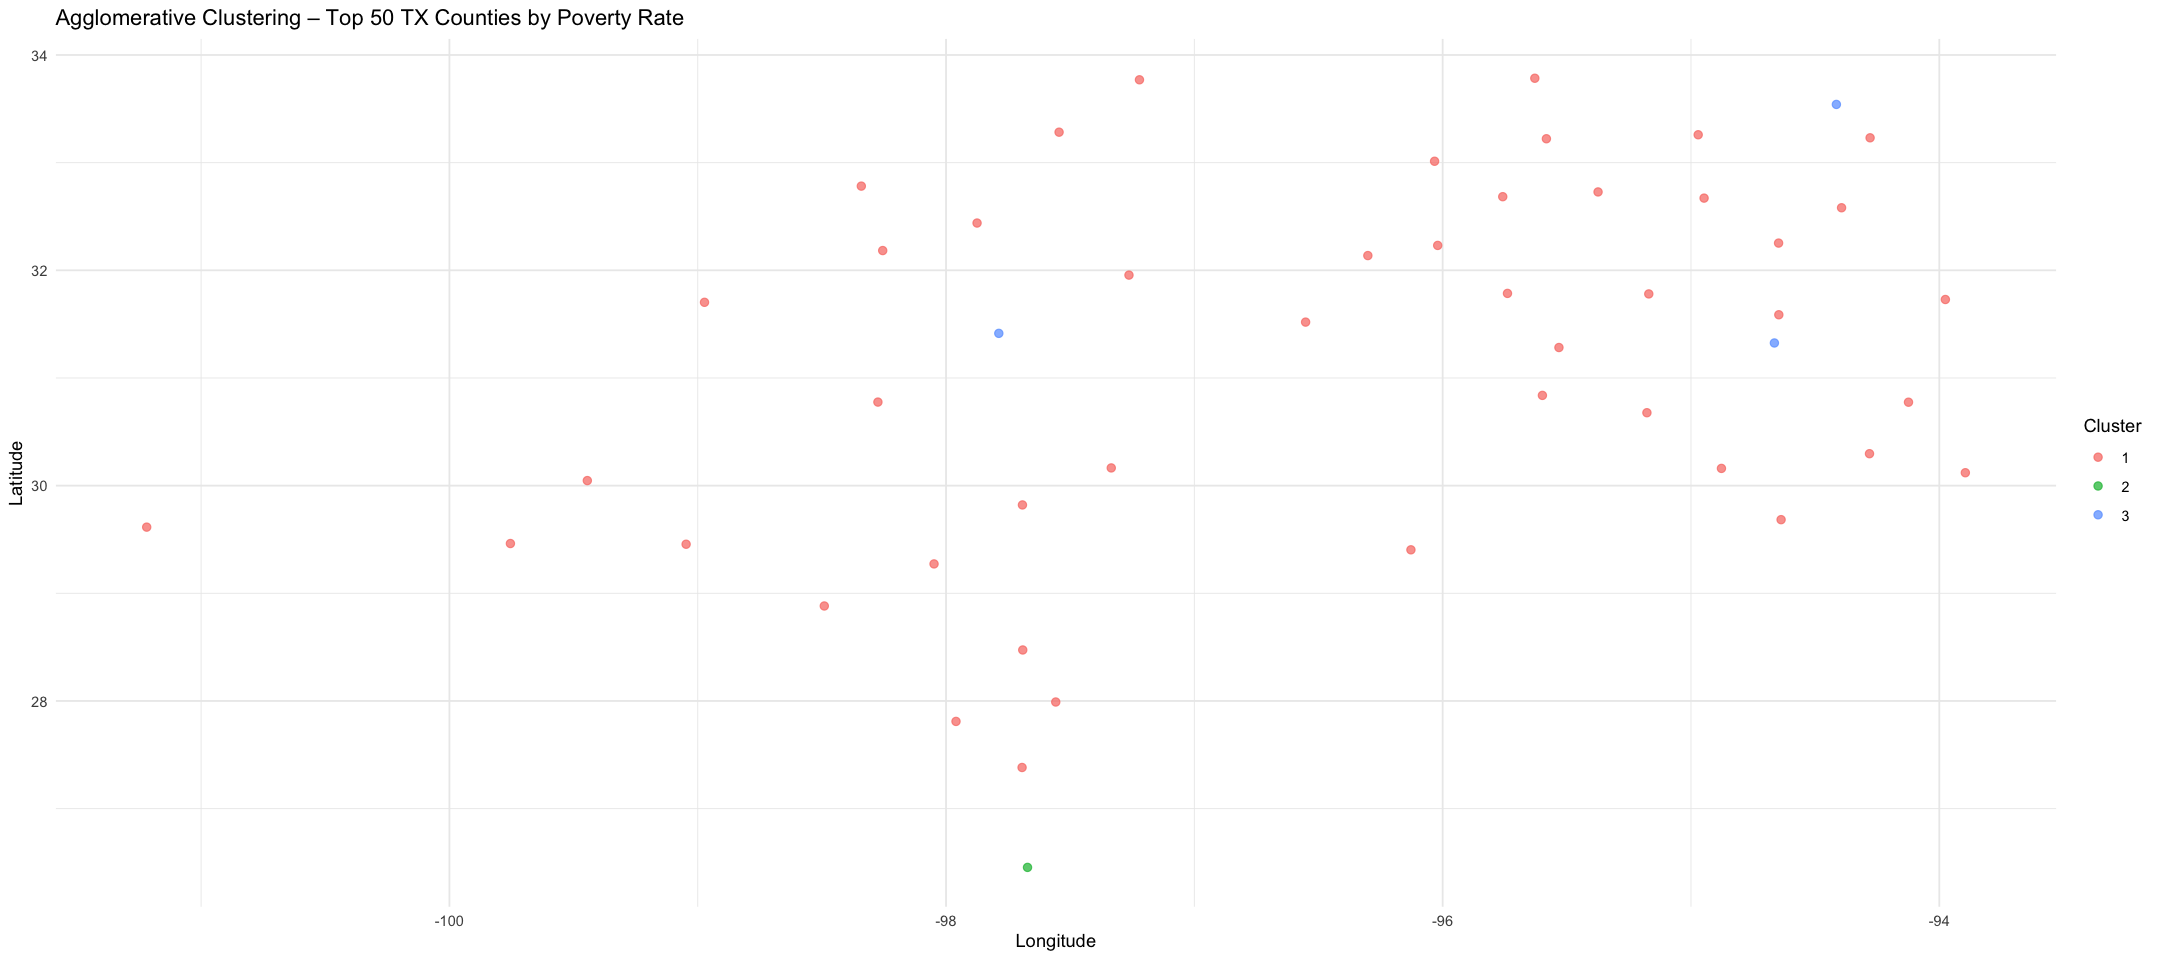

In [132]:
# Load centroids for Texas counties
tx_coords_df <- map_data("county") %>%
  filter(region == "texas") %>%
  group_by(subregion) %>%
  summarize(
    longitude = mean(long),
    latitude = mean(lat),
    .groups = "drop"
  ) %>%
  rename(county = subregion) %>%
  mutate(county = str_to_lower(county) %>% str_trim())

# Clean county names 
covid_census_tx_clustered <- covid_census_tx_clustered %>%
  mutate(county = str_to_lower(county) %>%
                 str_replace("county$", " ") %>%
                 str_trim())

# Join geographic coordinates
covid_census_tx_clustered <- left_join(covid_census_tx_clustered, tx_coords_df, by = "county")

# Filter for top 50 counties by poverty rate
covid_census_tx_clustered_top_50 <- covid_census_tx_clustered %>%
  filter(county %in% top_50_indices)  

# Plot 
ggplot(covid_census_tx_clustered_top_50, aes(x = longitude, y = latitude, color = cluster)) +
  geom_point(size = 2, alpha = 0.7) +
  labs(
    title = "Agglomerative Clustering – Top 50 TX Counties by Poverty Rate",
    x = "Longitude", y = "Latitude", color = "Cluster"
  ) +
  theme_minimal()

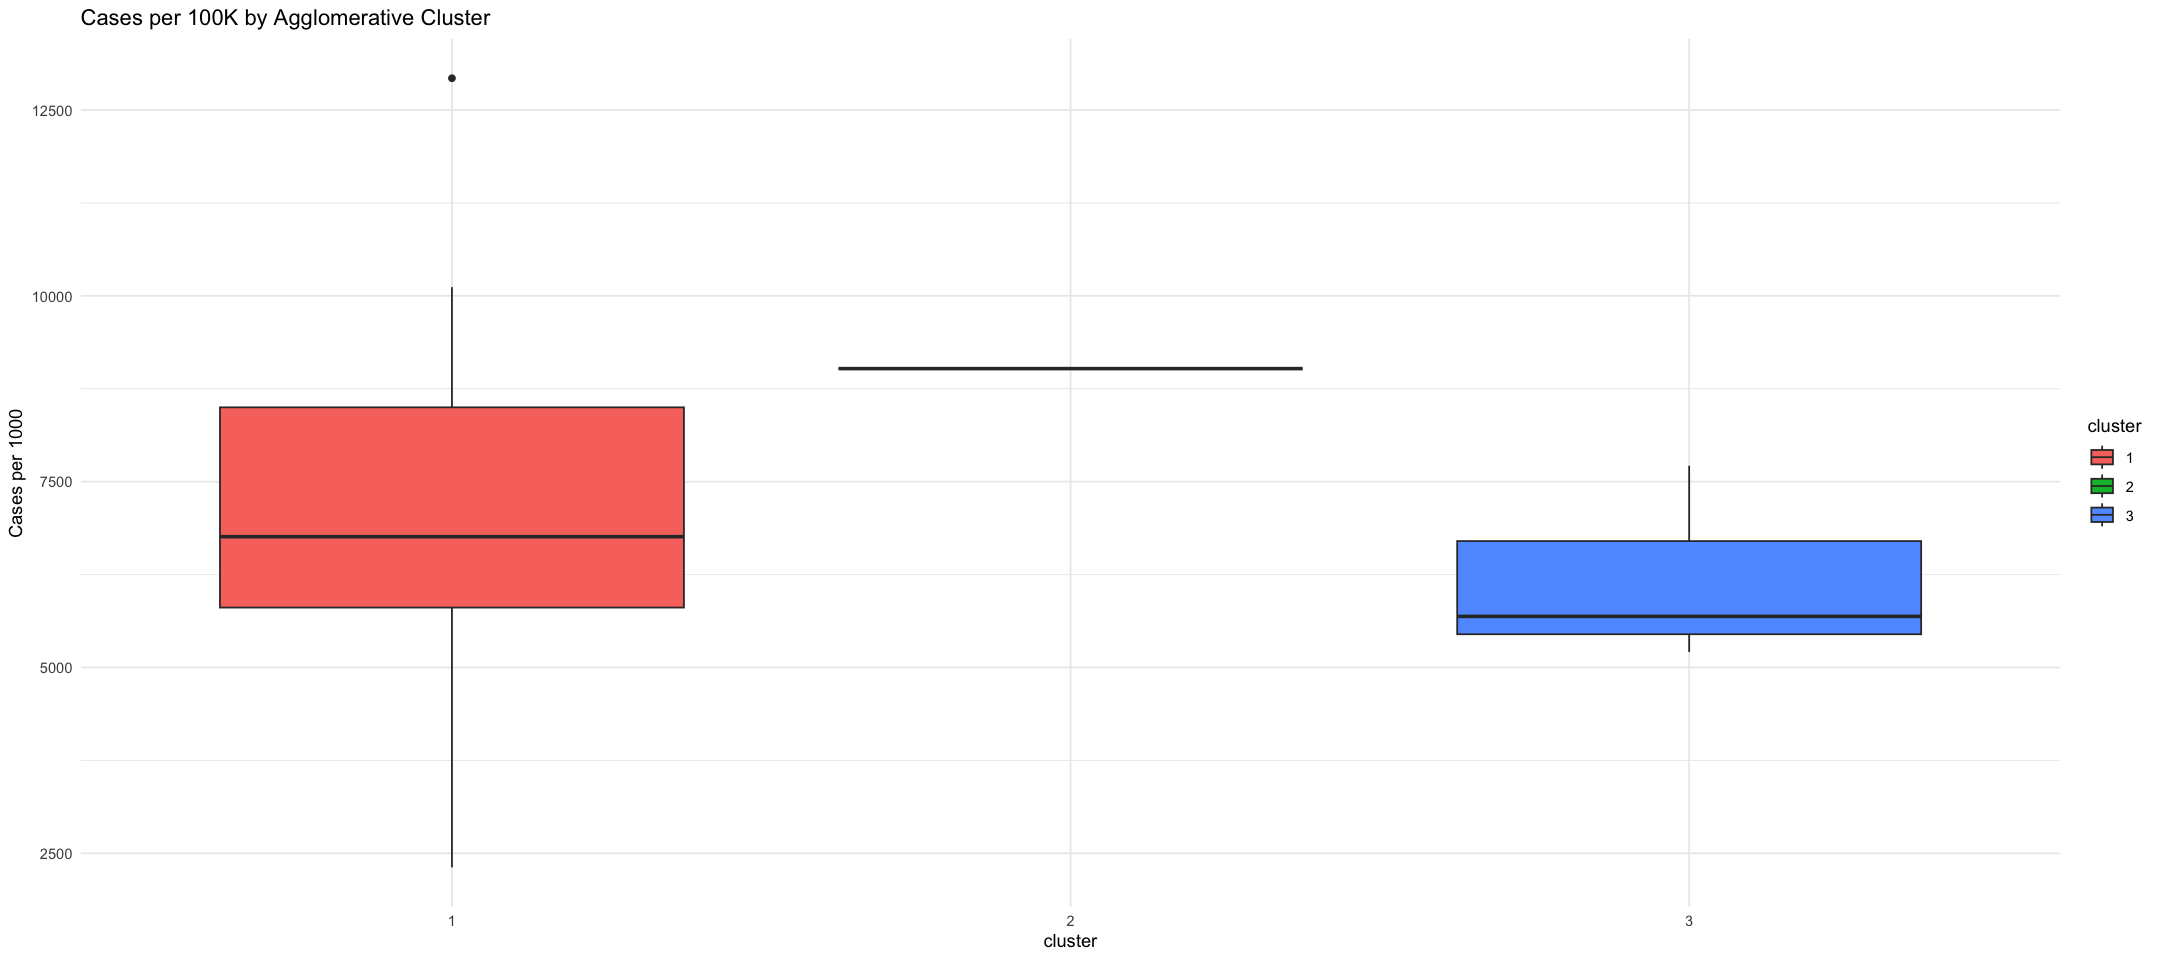

In [134]:
# Boxplots: Cases per 100K by Agglomerative Cluster
ggplot(covid_census_tx_clustered, aes(x = cluster, y = cases_per_100k, fill = cluster)) +
  geom_boxplot() +
  labs(title = "Cases per 100K by Agglomerative Cluster", y = "Cases per 1000") +
  theme_minimal()

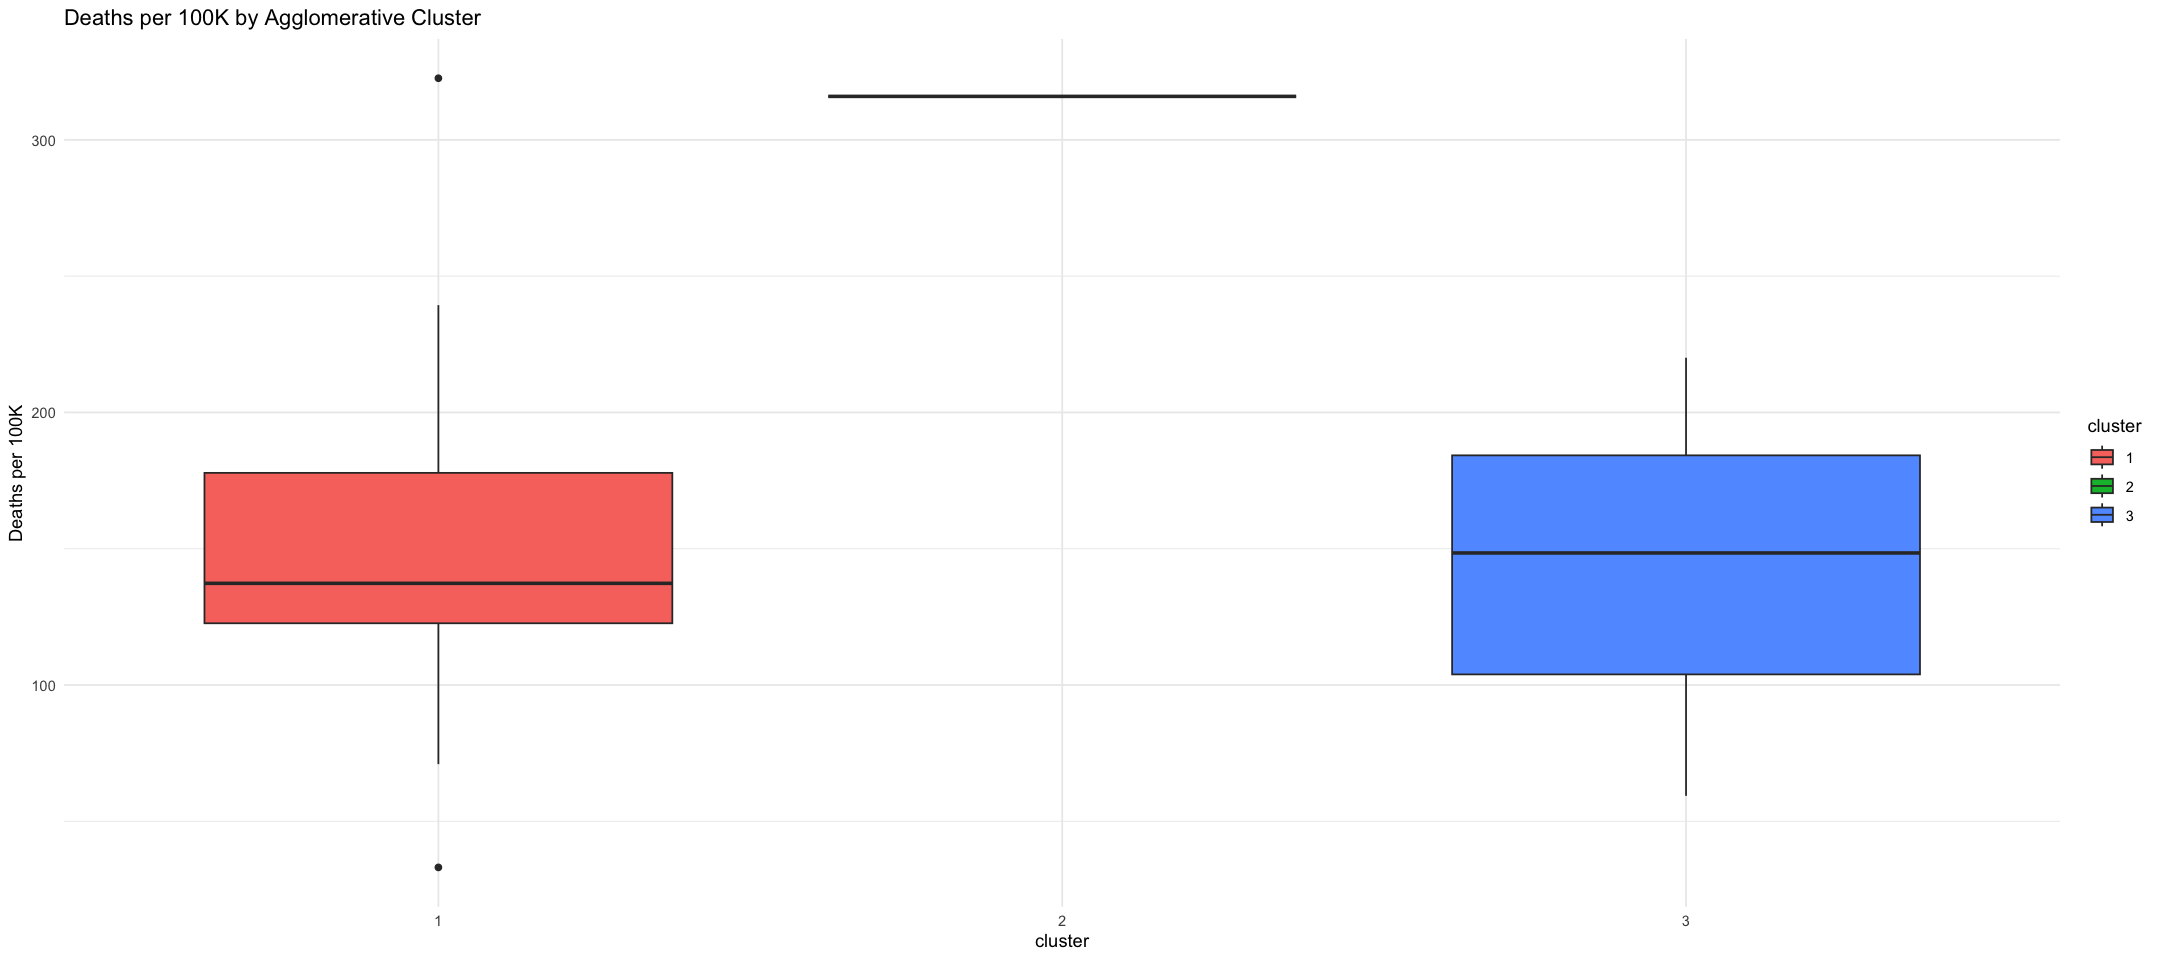

In [136]:
# Box plot: Deaths per 100K by Agglomerative Cluster
ggplot(covid_census_tx_clustered, aes(x = cluster, y = deaths_per_100k, fill = cluster)) +
  geom_boxplot() +
  labs(title = "Deaths per 100K by Agglomerative Cluster", y = "Deaths per 100K") +
  theme_minimal()